# Part B: Figures and analysis
# Introduction
This notebook contains all code that has been used to generate the anaylsis and figures of the  "How landscape data quality affects our perception of dominant processes in large-sample hydrology studies?" paper by do Nascimento et al. (in review). To be able to run this notebook, please ensure that you have downloaded the acompanying data of the paper. All links can be found in the data section of the paper.

Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

# Import modules

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import spearmanr
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import BoundaryNorm
import matplotlib as mpl
from utils.functions import find_unique_nested_catchments, find_max_unique_rows
from utils.plots import plot_watershed_groups_from_dict
from utils.plots import generate_legend_and_color_mapping
import math


Cannot find header.dxf (GDAL_DATA is not defined)



# Configurations

In [2]:
# Only editable variables:
# Relative path to your local directory
PATH = ".."

# Set the directory:
os.chdir(PATH)

warnings.simplefilter(action='ignore', category=Warning)

# Import data

### - Network information

In [99]:
network_estreams = pd.read_csv('data/EStreams/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

network_estreams

gauge_id           gauge_name gauge_country gauge_provider  \
basin_id                                                              
AT000001   200014                Bangs            AT        AT_EHYD   
AT000002   200048  Schruns (Vonbunweg)            AT        AT_EHYD   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD   
AT000004   200592    Kloesterle (OEBB)            AT        AT_EHYD   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD   
...           ...                  ...           ...            ...   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   
UAGR0018  6682500                YALTA            UA        UA_GRDC   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC   

              river   lon_snap   lat_snap        lon        lat elevation  \
basin_id                                                                    
AT000001      Rhein   9.534835  47.273748   9.534835  47.273748       420   
AT000002       Litz   9.913677  47.080301   9.913677  47.080301       673   
AT000003        Ill   9.847765  47.132821   9.847765  47.132821       579   
AT000004     Alfenz  10.061843  47.128994  10.061843  47.128994      1014   
AT000005     Alvier   9.802668  47.150770   9.802668  47.150770       564   
...             ...        ...        ...        ...        ...       ...   
UAGR0017      KACHA  33.894739  44.691884  33.900000  44.683333       NaN   
UAGR0018  DERE-KIOY  34.166667  44.500000  34.166667  44.500000        16   
UAGR0019     SALHYR  34.199841  44.887685  34.200000  44.883333       307   
UAGR0020     TOKMAK  35.705833  47.251389  35.705833  47.251389       NaN   
UAGR0021     KRYNKA  38.144722  48.153333  38.144722  48.153333       118   

          ...  num_continuous_days  num_days_gaps  num_days_reliable  \
basin_id  ...                                                          
AT000001  ...                 9497            0.0                0.0   
AT000002  ...                23103            0.0                0.0   
AT000003  ...                13513            0.0                0.0   
AT000004  ...                 8765            0.0                0.0   
AT000005  ...                10957            0.0                0.0   
...       ...                  ...            ...                ...   
UAGR0017  ...                 3652            0.0                0.0   
UAGR0018  ...                 3652            0.0                0.0   
UAGR0019  ...                 3652            0.0                0.0   
UAGR0020  ...                 3652            0.0                0.0   
UAGR0021  ...                 3652            0.0                0.0   

          num_days_noflag num_days_suspect gauge_flag  duplicated_suspect  \
basin_id                                                                    
AT000001           9497.0              0.0          B          [CH000197]   
AT000002          23103.0              0.0          B          [CH000221]   
AT000003          13513.0              0.0          B          [CH000215]   
AT000004           8765.0              0.0          B          [CH000227]   
AT000005          10957.0              0.0          B          [CH000214]   
...                   ...              ...        ...                 ...   
UAGR0017           3652.0              0.0          B                 NaN   
UAGR0018           3652.0              0.0          B                 NaN   
UAGR0019           3652.0              0.0          B                 NaN   
UAGR0020           3652.0              0.0          B                 NaN   
UAGR0021           3652.0              0.0          B                 NaN   

          watershed_group  gauges_upstream  \
basin_id                                     
AT000001                1               16   
AT0000

### - Filtered attributes

In [4]:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 
estreams_attributes

gauge_id           gauge_name gauge_country gauge_provider   river  \
basin_id                                                                      
AT000001   200014                Bangs            AT        AT_EHYD   Rhein   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD     Ill   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD  Alvier   
AT000007   231688            Beschling            AT        AT_EHYD     Ill   
AT000008   200501           Amerluegen            AT        AT_EHYD  Samina   
...           ...                  ...           ...            ...     ...   
UAGR0016  6681500      NOVOGOROZHENOYE            UA        UA_GRDC   INHUL   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   KACHA   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC  SALHYR   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC  TOKMAK   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC  KRYNKA   

           lon_snap   lat_snap        lon        lat elevation  ...  \
basin_id                                                        ...   
AT000001   9.534835  47.273748   9.534835  47.273748       420  ...   
AT000003   9.847765  47.132821   9.847765  47.132821       579  ...   
AT000005   9.802668  47.150770   9.802668  47.150770       564  ...   
AT000007   9.678850  47.200301   9.678850  47.200301       485  ...   
AT000008   9.614203  47.205978   9.614203  47.205978       603  ...   
...             ...        ...        ...        ...       ...  ...   
UAGR0016  32.350000  47.516667  32.350000  47.516667         8  ...   
UAGR0017  33.894739  44.691884  33.900000  44.683333       NaN  ...   
UAGR0019  34.199841  44.887685  34.200000  44.883333       307  ...   
UAGR0020  35.705833  47.251389  35.705833  47.251389       NaN  ...   
UAGR0021  38.144722  48.153333  38.144722  48.153333       118  ...   

          lulc_2006_agriculture  dam_num  res_num  lakes_num lakes_tot_area  \
basin_id                                                                      
AT000001                  0.127     23.0     10.0       10.0           6.62   
AT000003                  0.040      4.0      4.0        3.0           1.46   
AT000005                  0.023      1.0      1.0        1.0           0.89   
AT000007                  0.058      7.0      6.0        5.0           2.67   
AT000008                  0.016      0.0      0.0        0.0           0.00   
...                         ...      ...      ...        ...            ...   
UAGR0016                  0.000      0.0      0.0       95.0          29.74   
UAGR0017                  0.000      0.0      0.0        1.0           1.43   
UAGR0019                  0.000      0.0      0.0        1.0           0.31   
UAGR0020                  0.000      0.0      0.0        7.0           2.06   
UAGR0021                  0.000      0.0      0.0        7.0           3.72   

         lakes_tot_vol  sno_cov_mean  irri_1990  irri_2005  \
basin_id                                                     
AT000001        542.33        33.844     23.025     29.307   
AT000003         12.91        36.927      0.000      0.204   
AT000005          8.27        34.486      0.000      0.084   
AT000007         23.90        32.887      0.000      0.399   
AT000008          0.00        27.201      0.000      0.000   
...                ...           ...        ...        ...   
UAGR0016        124.55         8.705    163.532    152.585   
UAGR0017         16.43         3.805      0.000      0.000   
UAGR0019          1.54         4.928      0.000      0.000   
UAGR0020          6.95         8.310      0.000      0.000   
UAGR0021         19.48         9.131     17.737     16.757   

          stations_num_p_mean  
basin_id                       
AT000001                 22.0  
AT000003                 18.0  
AT000005                 10.0  
AT000007                 40.0  
AT000008                  8.0 

In [5]:
nested_catchments = pd.DataFrame(estreams_attributes['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

nested_catchments

nested_catchments
basin_id                                                   
AT000001  [AT000001, CH000010, CH000046, CH000048, CH000...
AT000003                     [AT000002, AT000003, CH000221]
AT000005                               [AT000005, CH000214]
AT000007  [AT000002, AT000003, AT000004, AT000005, AT000...
AT000008                                         [AT000008]
...                                                     ...
UAGR0016                                         [UAGR0016]
UAGR0017                                         [UAGR0017]
UAGR0019                                         [UAGR0019]
UAGR0020                                         [UAGR0020]
UAGR0021                                         [UAGR0021]

[9340 rows x 1 columns]

### - Geological attributes (Regional: Not in EStreams)

In [6]:
geology_regional_31_classes_moselle = pd.read_csv("data/new_attributes/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl'],
    
    "low": ['lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "verylow": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low", "area_perm_verylow"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]]
estreams_attributes

gauge_id           gauge_name gauge_country gauge_provider   river  \
basin_id                                                                      
AT000001   200014                Bangs            AT        AT_EHYD   Rhein   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD     Ill   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD  Alvier   
AT000007   231688            Beschling            AT        AT_EHYD     Ill   
AT000008   200501           Amerluegen            AT        AT_EHYD  Samina   
...           ...                  ...           ...            ...     ...   
UAGR0016  6681500      NOVOGOROZHENOYE            UA        UA_GRDC   INHUL   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   KACHA   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC  SALHYR   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC  TOKMAK   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC  KRYNKA   

           lon_snap   lat_snap        lon        lat elevation  ...  \
basin_id                                                        ...   
AT000001   9.534835  47.273748   9.534835  47.273748       420  ...   
AT000003   9.847765  47.132821   9.847765  47.132821       579  ...   
AT000005   9.802668  47.150770   9.802668  47.150770       564  ...   
AT000007   9.678850  47.200301   9.678850  47.200301       485  ...   
AT000008   9.614203  47.205978   9.614203  47.205978       603  ...   
...             ...        ...        ...        ...       ...  ...   
UAGR0016  32.350000  47.516667  32.350000  47.516667         8  ...   
UAGR0017  33.894739  44.691884  33.900000  44.683333       NaN  ...   
UAGR0019  34.199841  44.887685  34.200000  44.883333       307  ...   
UAGR0020  35.705833  47.251389  35.705833  47.251389       NaN  ...   
UAGR0021  38.144722  48.153333  38.144722  48.153333       118  ...   

          lakes_tot_area  lakes_tot_vol  sno_cov_mean  irri_1990 irri_2005  \
basin_id                                                                     
AT000001            6.62         542.33        33.844     23.025    29.307   
AT000003            1.46          12.91        36.927      0.000     0.204   
AT000005            0.89           8.27        34.486      0.000     0.084   
AT000007            2.67          23.90        32.887      0.000     0.399   
AT000008            0.00           0.00        27.201      0.000     0.000   
...                  ...            ...           ...        ...       ...   
UAGR0016           29.74         124.55         8.705    163.532   152.585   
UAGR0017            1.43          16.43         3.805      0.000     0.000   
UAGR0019            0.31           1.54         4.928      0.000     0.000   
UAGR0020            2.06           6.95         8.310      0.000     0.000   
UAGR0021            3.72          19.48         9.131     17.737    16.757   

         stations_num_p_mean  perm_high_regi  perm_medium_regi  perm_low_regi  \
basin_id                                                                        
AT000001                22.0             NaN               NaN            NaN   
AT000003                18.0             NaN               NaN            NaN   
AT000005                10.0             NaN               NaN            NaN   
AT000007                40.0             NaN               NaN            NaN   
AT000008                 8.0             NaN               NaN            NaN   
...                      ...             ...               ...            ...   
UAGR0016                 4.0             NaN               NaN            NaN   
UAGR0017                 3.0             NaN               NaN            NaN   
UAGR0019                 1.0             NaN               NaN            NaN   
UAGR0020                 1.0             NaN               NaN            NaN   
UAGR0021                 1.0             NaN               NaN        

### - Catchment boundaries

In [36]:
catchment_boundaries = gpd.read_file('data/EStreams/shapefiles/estreams_catchments.shp')
catchment_boundaries

basin_id gauge_id country  area_offic  area_estre  area_flag  area_rel  \
0      AT000001   200014      AT      4647.9    4668.379          0 -0.440608   
1      AT000002   200048      AT       102.0     102.287          0 -0.281373   
2      AT000003   231662      AT       535.2     536.299          0 -0.205344   
3      AT000004   200592      AT        66.6      66.286          0  0.471471   
4      AT000005   200097      AT        72.2      72.448          0 -0.343490   
...         ...      ...     ...         ...         ...        ...       ...   
17125  UAGR0017  6682300      UA       321.0     325.370          0 -1.361371   
17126  UAGR0018  6682500      UA        49.7      47.594          0  4.237425   
17127  UAGR0019  6683010      UA       261.0     244.731          1  6.233333   
17128  UAGR0020  6683200      UA       760.0     731.073          0  3.806184   
17129  UAGR0021  6683300      UA       582.0     599.600          0 -3.024055   

       start_date    end_date gauge_flag  upstream  group  \
0      1996-01-01  2021-12-31          B        16      1   
1      1958-10-01  2021-12-31          B         1      1   
2      1985-01-02  2021-12-31          B         2      1   
3      1998-01-02  2021-12-31          B         1      1   
4      1990-01-01  2019-12-31          B         3      1   
...           ...         ...        ...       ...    ...   
17125  1978-01-01  1987-12-31          B         1   1988   
17126  1978-01-01  1987-12-31          B         1   1989   
17127  1978-01-01  1987-12-31          B         1   1990   
17128  1978-01-01  1987-12-31          B         1   1991   
17129  1978-01-01  1987-12-31          B         1   1992   

                                                geometry  
0      POLYGON Z ((9.69406 46.54322 0.00000, 9.69570 ...  
1      POLYGON Z ((10.13650 47.02949 0.00000, 10.1349...  
2      POLYGON Z ((10.11095 46.89437 0.00000, 10.1122...  
3      POLYGON Z ((10.14189 47.09706 0.00000, 10.1404...  
4      POLYGON Z ((9.67851 47.06249 0.00000, 9.67888 ...  
...                                                  ...  
17125  POLYGON Z ((33.96791 44.63291 0.00000, 33.9679...  
17126  POLYGON Z ((34.19958 44.58291 0.00000, 34.2029...  
17127  POLYGON Z ((34.19624 44.88375 0.00000, 34.1962...  
17128  POLYGON Z ((35.78708 47.28708 0.00000, 35.7870...  
17129  POLYGON Z ((38.10125 48.15791 0.00000, 38.1004...  

[17130 rows x 13 columns]

### - Geological maps (in .shp)

In [14]:
# Import the geological maps (in .shp), downloaded and stored from their respective official providers.
## Global geology map
GLiM = gpd.read_file("../estreams_part_b/data/lithology/GLiM.shp")

attribute_field = 'xx'
GLiM_dissolved = GLiM.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_dissolved["class"] = GLiM_dissolved.index

# Reproject the map
print("CRS of GLiM:", GLiM_dissolved.crs)
GLiM_reprojected = GLiM_dissolved.to_crs("EPSG:4326")

## Continental geology map
IHME = gpd.read_file("../estreams_part_b/data/lithology/ihme1500_litho12345_ec4060_v12_poly.shp")

# Check for and fix invalid geometries
if not IHME.geometry.is_valid.all():
    IHME.geometry = IHME.geometry.buffer(0)

attribute_field = 'LEVEL3'
IHME_dissolved = IHME.dissolve(by=attribute_field)

## Now we create a new feature with the lithology class:
IHME_dissolved["class"] = IHME_dissolved.index

# Reproject the map
print("CRS of GLiM:", IHME_dissolved.crs)
IHME_reprojected = IHME_dissolved.to_crs("EPSG:4326")

CRS of GLiM: PROJCS["World_Eckert_IV",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Eckert_IV"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54012"]]
CRS of GLiM: epsg:3035


In [15]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

##################################################################################################################
# Global geology clipped to the Moselle catchment
GLiM_moselle = gpd.read_file(r'..\estreams_part_b\data\gis\raster\glim_moselle_wgs.shp')

attribute_field = 'xx'
GLiM_moselle_dissolved = GLiM_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
GLiM_moselle_dissolved["class"] = GLiM_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_glim = {
    "very low": ['ev', 'ig', 'pa', 'pb', 'va', 'vb', "wb"],
    "low": ['mt', 'pi', 'py', 'vi'],
    "medium": ['sc', 'sm'],
    "high": ['su', 'ss']
}

# Create a new column for reclassified permeability
def reclassify_glim_class(class_name):
    for permeability, classes in permeability_columns_glim.items():
        if class_name in classes:
            return permeability
    return None

GLiM_moselle_dissolved['permeability'] = GLiM_moselle_dissolved['class'].apply(reclassify_glim_class)

##################################################################################################################
# Continental geology clipped to the Moselle catchment
geology_median_moselle = gpd.read_file(r'..\estreams_part_b\data\gis\raster\geology_median_moselle_wgs.shp')

attribute_field = 'LEVEL3'
geology_median_moselle_dissolved = geology_median_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_median_moselle_dissolved["class"] = geology_median_moselle_dissolved.index

# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Conglomerates", "Conglomerates and sands", "Gravels", 
             "Sands", "Sandstones", "Sandstones and sands"],
    "medium": ["Conglomerates and clays", "Gneisses", "Limestones", 
               "Limestones and sands", "Sandstones and clays", "Sandstones and marls",
               "Limestones and clays", "Limestones and marls", "Marlstones and sands"],
    "low": ["Claystones and clays", "Marbles",
              "Marls", "Marlstones", "Marlstones and clays", 
              "Marlstones and marls", "Phyllites", "Schists",
              "Silts"],
    "very low": ["Plutonic rocks", "Volcanic rocks", 
                    "Inland water", "Snow field / ice field",
                    "Clays",  'Quartzites', "Shales"]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_median_moselle_dissolved['permeability'] = geology_median_moselle_dissolved['class'].apply(reclassify_geology_class)

##################################################################################################################
# Regional geology clipped to the Moselle catchment
geology_high_moselle = gpd.read_file(r'..\estreams_part_b\data\lithology\moselle_hr_ff.shp')

attribute_field = 'Labels01'
geology_high_moselle_dissolved = geology_high_moselle.dissolve(by=attribute_field)

# Now we create a new feature with the geology class:
geology_high_moselle_dissolved["class"] = geology_high_moselle_dissolved.index

# Set the CRS to WGS84
geology_high_moselle_dissolved = geology_high_moselle_dissolved.to_crs(epsg=4326)


# Define the permeability columns dictionary
permeability_columns_geology = {
    "high": ["Alluvium", 'Coal', 'Conglomerate', 'Gravel and sand',
             'Sand', 'Sand and gravel', 'Sandstone and conglomerate', 'Sandstone'
        ],
    
    "medium": ['Limestone', 'Sandstone and marl', 'Sandstone and schist',
              'Sandstone, conglomerate and marl'],
    
    "low": ['Arkose', 'Dolomite rock', 'Limestone and marl', 'Marl', 
             'Marl and dolomite', 'Marl and limestone', 'Marl and sandstone',
             'Sandstone and siltstone', 'Sandstone, siltstone and schist', 
              'Schist and sandstone', 'Silt',  'Silt and schist', 'Siltstone, sandstone and schist'
              ,"Siltstone"
             ],
    
    "very low": ['Cristallin basement', 'Plutonic rock',  'Quarzite',
                    'Schist','Volcanic rock' 
                   ]
}

# Create a new column for reclassified permeability
def reclassify_geology_class(class_name):
    for permeability, classes in permeability_columns_geology.items():
        if class_name in classes:
            return permeability
    return None

geology_high_moselle_dissolved['permeability'] = geology_high_moselle_dissolved['class'].apply(reclassify_geology_class)

Current CRS: EPSG:4326
Image is already in WGS84 CRS.


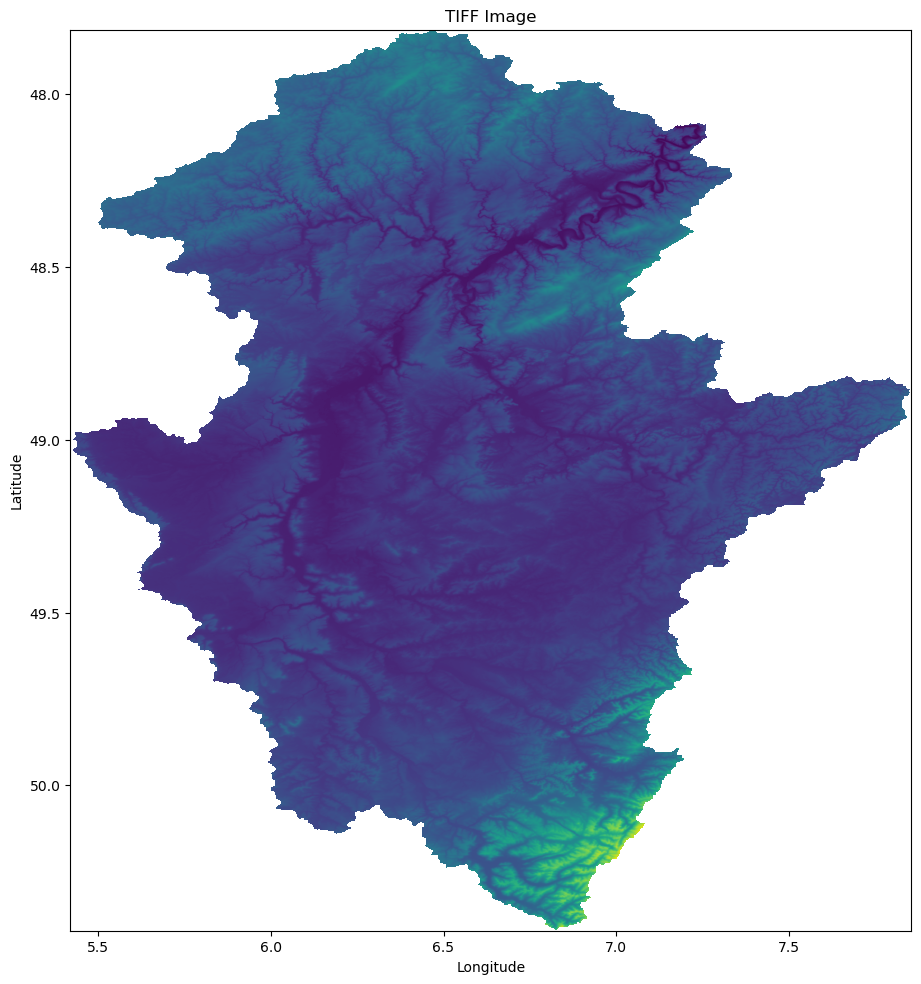

In [16]:
##################################################################################################################
# Terrain (elevation)
# Path to the TIFF file
tiff_path = '..\estreams_part_b\data/elevation/moselle_srtm.tif'

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    # Check the current CRS
    current_crs = src.crs
    print(f'Current CRS: {current_crs}')

    # Define the target CRS (WGS84)
    dst_crs = 'EPSG:4326'  # WGS84

    # If the current CRS is not WGS84, reproject the image
    if current_crs != dst_crs:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Create an in-memory array to hold the reprojected data
        reprojected_image = rasterio.io.MemoryFile().open(**kwargs)

        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(reprojected_image, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

        # Read the reprojected image
        elevation_wgs = reprojected_image.read(1)

        print(f'Image reprojected to WGS84 and stored in-memory.')
    else:
        # Read the original image if it is already in WGS84
        elevation_wgs = src.read(1)
        transform = src.transform
        print('Image is already in WGS84 CRS.')

# Calculate the extent
left, bottom, right, top = transform * (0, 0), transform * (elevation_wgs.shape[1], 0), transform * (elevation_wgs.shape[1], elevation_wgs.shape[0]), transform * (0, elevation_wgs.shape[0])
extent = (left[0], right[0], bottom[1], top[1])

# Plot the image with the correct extent
fig, ax = plt.subplots(1, 1, figsize=(16.6, 11.7))
ax.imshow(elevation_wgs, cmap='viridis', extent=extent)
ax.set_title('TIFF Image')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### - Some extra shapefiles for figures

In [59]:
# Subset of the 5 regional catchments further evaluated: ["PL000936", "FR000867", "DEBU1959", "ES000665", "FR001604"]
rivers_fivesubs = gpd.read_file(r'data\rivers\rivers_merit_five_subs_dissolved.shp')
rivers_fivesubs_es = gpd.read_file(r'data\rivers\rivers_merit_five_subs_withES_dissolved.shp')
rivers_garonne = gpd.read_file(r'data\rivers\rivers_merit_garonne_dissolved.shp')
rivers_cinca = gpd.read_file(r'data\rivers\rivers_merit_cinca_dissolved.shp')

# Delineation of the Moselle catchment
moselle_del = gpd.read_file('../estreams_part_b/data/gis/moselle_delienation.shp')

# Shapefile of the river network (MERIT) over the Mosellle
river_moselle = gpd.read_file('../estreams_part_b/data/gis/river_merit_moselle_clipped_dissolved.shp')

# Analysis and results


## Large-scale: 63 catchments
Here we evaluate the correlation for the 63 regional catchments worked with

In [65]:
# This list of 72 regional catchments was defined using a visual inspection with QGIS:
list_cats_list = ["ES000801", "ES000665","ES001243", "ES000196", "ES000116", "ES000194", "ES001080", "ES000316","ES000397","ES000339","ES000331", 
                  "GB000472", "GB000271", "GB000153","ITTO0361","ITVE0408","ITLC0146", "ITPI0183", "SE000102", "FI000668", "FI000585", "FI000557", 
                  "FI000226", "FI000137", "PL000936","PL000905", "PL000868", "PL000794","HR000048","HUGR0037", "AT000393", "PL000253", 
                  "PL000349", "PL000015","CZ000097","DEST1711", "DEBY0711","DEBY0724", "DEBY0697", "DEBU1953", "NL000008","CH000026", "FR002679", 
                  "FR004615", "NL000016", "BEVL0155", "FR000408", "FR000373", "FR000345", "FR001071", "FR003922", "FR003986", "FR002118", "FR001952",
                  "FR002029", "FR001604", "FR004221", "ES000738","ES001171", "ES001010", "PL001056", "PL000536", "HR000278", "CZ000236","DEST1707", 
                  "DEBE0155","FR002758","FR002462","FR001394", "FR000867", "FR004308", "DEBU1959"] 

In [126]:
## Create the Q5/Qmean column
#estreams_attributes["q_5q_mean"] = estreams_attributes["q_5"]/estreams_attributes["q_mean"]

# Initialize dictionaries and DataFrames to store grouped correlations and geological differences
corr_max_group_dfs_dict = {}
corr_max_geology_diff = pd.DataFrame()
corr_max_geology_diff_abs = pd.DataFrame()
corr_max_geology_diff_above_05 = pd.DataFrame()

# Initialize DataFrames to store correlations for different geological, climate, soil, and land-use variables
corr_low_geology_df = pd.DataFrame()
corr_med_geology_df = pd.DataFrame()
corr_low_geology_df_25 = pd.DataFrame()
corr_med_geology_df_25 = pd.DataFrame()
corr_med_climate_df = pd.DataFrame()
corr_med_soils_df = pd.DataFrame()
corr_med_topography_df = pd.DataFrame()
corr_med_landuse_df = pd.DataFrame()

# DataFrame to store the number of nested catchments per watershed
lens_df = pd.DataFrame()

# Loop over each list of catchments in the main list
for list_cats in tqdm.tqdm(list_cats_list):
    nested_cats_df = nested_catchments.loc[[list_cats], :] # Select rows for the current list of catchments

    # Filter catchments using a function to find the ones with maximum unique rows
    nested_cats_filtered = find_max_unique_rows(nested_cats_df)
    nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]

    # Initialize a dictionary to store data for each selected catchment with more than 20 nested catchments
    estreams_attributes_dfs = {}
    for catchment in nested_cats_filtered:
        nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']              # Retrieve the nested list of catchments for the current catchment
        nested_clip = [value for value in nested_clip if value in estreams_attributes.index]   # Filter values to include only those that exist in the index of estreams_attributes
        cat_clip = estreams_attributes.loc[nested_clip, :]                                     # Filter the estreams_attributes DataFrame based on the filtered nested_clip
        estreams_attributes_dfs[catchment] = cat_clip                                          # Store the resulting DataFrame in the dictionary

    # Create DataFrame to store the number of nested catchments per catchment
    catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
    for catchment, data in estreams_attributes_dfs.items():
        catchment_lens.loc[catchment, "len"] = len(data)                                       # Count of nested catchments


    # Filter catchments with at least 10 nested catchments
    nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
    nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]  # Here we filter the catchemnts for the list (again, after we apply our function):


    # Reinitialize dictionary to store data for selected catchments above 20 nested catchments
    estreams_attributes_dfs = {}
    for catchment in nested_cats_filtered_abovevalue_df.index:
        nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']   # Retrieve the nested list of catchments for the current catchment
        nested_clip = [value for value in nested_clip if value in estreams_attributes.index]   # Filter values to include only those that exist in the index of estreams_attributes
        cat_clip = estreams_attributes.loc[nested_clip, :]                                     # Filter the estreams_attributes DataFrame based on the filtered nested_clip
        estreams_attributes_dfs[catchment] = cat_clip                                          # Store the resulting DataFrame in the dictionary


    # Further filter catchments to include data from 2009 onwards
    estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
    #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]

    nested_cats_filtered_abovevalue["len"] = len(estreams_attributes_dfs_cat)
    # Initialize a dictionary to store correlation DataFrames for each variable in a selected range
    correlation_dict = {}

    signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
                'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']
    
    for variable in signatures:
        correlation_df = pd.DataFrame()                                                        # Initialize an empty DataFrame to store correlations

        # Iterate over each watershed group
        for catchment in estreams_attributes_dfs.keys():

            estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
            'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
            'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
            'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq',
            
            'p_mean', 'pet_mean',
            'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
            'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
            'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
            'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

            "perm_high_glob", "perm_medium_glob", "perm_low_glob", "perm_verylow_glob", 
            "perm_high_cont", "perm_medium_cont", "perm_low_cont", "perm_verylow_cont",
            "perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi",

            'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
            'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
            'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
            'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
            'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
            'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
            'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
            
            # Calculate correlations between the current variable and other variables
            correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
            correlation_df[catchment] = correlations                                               # Store the correlations to the DataFrame

        # Add the correlation DataFrame to the dictionary
        correlation_dict[variable] = correlation_df

    # Create a list to store all correlation DataFrames with a signature column
    correlation_list = []
    # Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
    for signature in correlation_dict.keys():
        corr_df = correlation_dict[signature].T
        corr_df['signature'] = signature                                                           # Add a column to identify the signature
        correlation_list.append(corr_df)

    # Concatenate all correlation DataFrames along the rows
    combined_correlation_df = pd.concat(correlation_list)

    # Preserve the order of the signatures by converting to categorical type
    combined_correlation_df['signature'] = pd.Categorical(
        combined_correlation_df['signature'],
        categories=list(correlation_dict.keys()),
        ordered=True)
    combined_correlation_df.set_index('signature', inplace=True)                                   # Set 'signature' as index

    # Dictionary to classify variables into categories (climatic, topography, geology, etc.)
    variable_dict = {
        'p_mean': 'climatic',
        'pet_mean': 'climatic',
        'aridity': 'climatic',
        'p_seasonality': 'climatic',
        'frac_snow': 'climatic',
        'hp_freq': 'climatic',
        'hp_dur': 'climatic',
        'hp_time': 'climatic',
        'lp_freq': 'climatic',
        'lp_dur': 'climatic',
        'lp_time': 'climatic',
        'ele_mt_max': 'topography',
        'ele_mt_mean': 'topography',
        'ele_mt_min': 'topography',
        'slp_dg_mean': 'topography',
        'flat_area_fra': 'topography',
        'steep_area_fra': 'topography',
        'elon_ratio': 'topography',
        'strm_dens': 'topography',
        'lit_dom': 'geology',
        'bedrk_dep': 'soil',

        'perm_verylow_glob': 'geology_low',
        'perm_low_glob': 'geology_low',
        'perm_medium_glob': 'geology_low',
        'perm_high_glob': 'geology_low',

        'root_dep_mean': 'soil',
        'root_dep_max': 'soil',
        'root_dep_min': 'soil',
        'soil_tawc_mean': 'soil',
        'soil_fra_sand_mean': 'soil',
        'soil_fra_silt_mean': 'soil',
        'soil_fra_clay_mean': 'soil',
        'soil_fra_grav_mean': 'soil',
        'soil_bd_mean': 'soil',
        'soil_oc_mean': 'soil',
        'lai_mean': 'lulc',
        'ndvi_mean': 'lulc',
        'lulc_2006_urban': 'lulc',
        'lulc_2006_NonIrriAgri': 'lulc',
        'lulc_2006_Agric': 'lulc',
        'lulc_2006_forest': 'lulc',
        'lulc_2006_grass': 'lulc',
        'lulc_2006_agriculture': 'lulc',
        'dam_num': 'hydrology',
        'res_num': 'hydrology',
        'lakes_num': 'hydrology',
        'sno_cov_mean': 'climatic',
        'irri_1990': 'hydrology',
        'irri_2005': 'hydrology',

        'perm_high_cont': 'geology_med',
        'perm_medium_cont': 'geology_med',
        'perm_low_cont': 'geology_med',
        'perm_verylow_cont': 'geology_med',

        'stations_num_p_mean': 'climatic',

        'perm_high_regi': "geology_high", 
        'perm_medium_regi': "geology_high", 
        'perm_low_regi': "geology_high",
        'perm_verylow_regi': "geology_high",
        "area_estreams": "topography"
    }


    # Define variable classes for grouping
    classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

    # Initialize DataFrame to store maximum correlations by group
    corr_max_group_dfs = pd.DataFrame(columns = signatures)
    for signature in signatures:
        correlation_df = correlation_dict[signature] # Correlation data for each signature
        
        # Initialize the dataframe with columns for each class's maximum correlation and feature
        columns = []
        for cls in classes:
            columns.append(f"corr_max_{cls}")
            columns.append(f"corr_max_feature_{cls}")

        corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

        # Populate the dataframe with the maximum correlations for each class
        for catchment in correlation_df.columns:
            max_corr = {cls: 0 for cls in classes}
            max_feature = {cls: None for cls in classes}

            for feature in correlation_df.index:
                cls = variable_dict[feature]
                corr_value = abs(correlation_df.loc[feature, catchment])

                if corr_value > abs(max_corr[cls]):
                    max_corr[cls] = correlation_df.loc[feature, catchment]
                    max_feature[cls] = feature

            for cls in classes:
                corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
                corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

        for cls in classes:
            corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

        # Format and organize columns
        corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                        'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                        'corr_max_vegetation', 'corr_max_hydrology']]

        # Sort and add additional columns
        corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
        corr_max_group_df = corr_max_group_df.astype(float)
        corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
        corr_max_group_dfs[signature] = corr_max_group_df
    
    corr_max_group_dfs_dict[list_cats] = corr_max_group_dfs

    # Compute the maximum and then the absolute difference:
    corr_max_group_dfs_abs = corr_max_group_dfs.abs()
    corr_max_geology_diff[list_cats] = ((corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"])/corr_max_group_dfs_abs.T["corr_max_geology_low"])*100
    corr_max_geology_diff_abs[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"]

    # Store correlation data for each category
    corr_low_geology_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_low"]
    corr_med_geology_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"]
    corr_med_climate_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_climatic"]
    corr_med_soils_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_soil"]
    corr_med_topography_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_topography"]
    corr_med_landuse_df[list_cats] = corr_max_group_dfs_abs.T["corr_max_lulc"]
    
    # Save length of each catchment with filtered rows
    lens_df[list_cats] = nested_cats_filtered_abovevalue.len.values

    # Filter catchments with at least 30 nested catchments
    if nested_cats_filtered_abovevalue.len.values.max() >=25:
        corr_low_geology_df_25[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_low"]
        corr_med_geology_df_25[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"]

    if corr_max_group_dfs_abs.T["corr_max_geology_med"].baseflow_index > 0.5 or corr_max_group_dfs_abs.T["corr_max_geology_low"].baseflow_index > 0.5:
    #    # Compute the percentage difference and the absolute difference for the filtered rows
        corr_max_geology_diff_above_05[list_cats] = corr_max_group_dfs_abs.T["corr_max_geology_med"] - corr_max_group_dfs_abs.T["corr_max_geology_low"]

100%|██████████| 63/63 [00:35<00:00,  1.76it/s]


In [67]:
# Initialize an empty DataFrame for storing baseflow index (BFI) data
dataframe_BFI = pd.DataFrame()

# Assign baseflow index values from various sources to the BFI DataFrame
dataframe_BFI["geology_global"] = corr_low_geology_df.T["baseflow_index"]            # Baseflow index for global geology
dataframe_BFI["geology_continental"] = corr_med_geology_df.T["baseflow_index"]       # Baseflow index for continental geology
dataframe_BFI["climate"] = corr_med_climate_df.T["baseflow_index"]                   # Baseflow index for climate
dataframe_BFI["soils"] = corr_med_soils_df.T["baseflow_index"]                       # Baseflow index for soils
dataframe_BFI["topography"] = corr_med_topography_df.T["baseflow_index"]             # Baseflow index for topography
dataframe_BFI["landuse"] = corr_med_landuse_df.T["baseflow_index"]                   # Baseflow index for land use

# Calculate the maximum baseflow index from selected categories and store it
dataframe_BFI["max"] = dataframe_BFI[["climate", "soils", "topography", "landuse"]].T.max()

# Add additional attributes: area, dams, lakes, and length
dataframe_BFI["area"] = estreams_attributes.loc[list_cats_list, :].area_estreams     # Area of each catchment
dataframe_BFI["dams"] = estreams_attributes.loc[list_cats_list, :].res_num           # Number of reservoirs (dams)
dataframe_BFI["lakes"] = estreams_attributes.loc[list_cats_list, :].lakes_num        # Number of lakes
dataframe_BFI["len"] = lens_df.T                                                     # Length of each catchment

# Filter the BFI DataFrame to include only rows with a length of 30 or more catchments
dataframe_BFI = dataframe_BFI[dataframe_BFI.len >= 25]

# Initialize an empty DataFrame for storing flow duration curve (FDC) data (q_95 values)
dataframe_other = pd.DataFrame()

# Assign q_95 values from various sources to the FDC DataFrame
dataframe_other["geology_global"] = corr_low_geology_df.T["q_5"]            # q_95 for global geology
dataframe_other["geology_continental"] = corr_med_geology_df.T["q_5"]      # q_95 for continental geology
dataframe_other["climate"] = corr_med_climate_df.T["q_5"]                  # q_95 for climate
dataframe_other["soils"] = corr_med_soils_df.T["q_5"]                      # q_95 for soils
dataframe_other["topography"] = corr_med_topography_df.T["q_5"]            # q_95 for topography
dataframe_other["landuse"] = corr_med_landuse_df.T["q_5"]                  # q_95 for land use

# Calculate the maximum q_95 from selected categories and store it
dataframe_other["max"] = dataframe_other[["climate", "soils", "topography", "landuse"]].T.max()

# Add additional attributes: area, dams, lakes, and length
dataframe_other["area"] = estreams_attributes.loc[list_cats_list, :].area_estreams     # Area of each catchment
dataframe_other["dams"] = estreams_attributes.loc[list_cats_list, :].res_num           # Number of reservoirs (dams)
dataframe_other["lakes"] = estreams_attributes.loc[list_cats_list, :].lakes_num        # Number of lakes
dataframe_other["len"] = lens_df.T                                                     # Length of each catchment

# Filter the FDC DataFrame to include only rows with a length of 30 or more catchments
dataframe_other = dataframe_other[dataframe_other.len >= 25]

In [68]:
# Here we check the final number of catchments left:
print(len(dataframe_BFI))

63


## Export some information about these catchments

In [69]:
estreams_attributes_catchments = estreams_attributes.loc[dataframe_BFI.index, ["gauge_name", "river", "lon_snap", "lat_snap", "area_estreams", "gauges_upstream"]]

estreams_attributes_catchments.gauges_upstream = dataframe_other.len

estreams_attributes_catchments.gauge_name = network_estreams.gauge_name
estreams_attributes_catchments.river = network_estreams.river

estreams_attributes_catchments

gauge_name                        river  \
ES000801  ORELLANA                                                     NaN   
ES000665  PALMA DEL RIO                                                NaN   
ES001243  TALAVERA                                                     NaN   
ES000196  VALLADOLID-PISUERGA                                          NaN   
ES000194  BRETO                                                        NaN   
...                                       ...                          ...   
FR002462                             V3000015              Le Rhône à Lyon   
FR001394                             M4101910            La Maine à Angers   
FR000867                             J9300611           La Vilaine à Rieux   
FR004308         Le Lot Ã  Villeneuve-sur-Lot  Le Lot à Villeneuve-sur-Lot   
DEBU1959                    BundespegelCochem                        Mosel   

          lon_snap   lat_snap  area_estreams  gauges_upstream  
ES000801 -5.650096  39.018443      26470.566               34  
ES000665 -5.288928  37.717447      32359.392               43  
ES001243 -4.816129  39.954353      33576.944               94  
ES000196 -4.732359  41.661169      15578.353               37  
ES000194 -5.765457  41.872234      14406.755               33  
...            ...        ...            ...              ...  
FR002462  4.830957  45.748113      20551.737               88  
FR001394 -0.558903  47.471558      22175.954               91  
FR000867 -2.126360  47.580112      10146.529               45  
FR004308  0.701216  44.409311      10748.554               55  
DEBU1959  7.168000  50.143000      27100.000              152  

[63 rows x 6 columns]

In [70]:
print(estreams_attributes_catchments.gauges_upstream.max())

181


In [525]:
estreams_attributes_catchments.to_csv("results/table_catchments.csv", encoding='utf-8')

## Figure 4: Lineplot with different groups

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

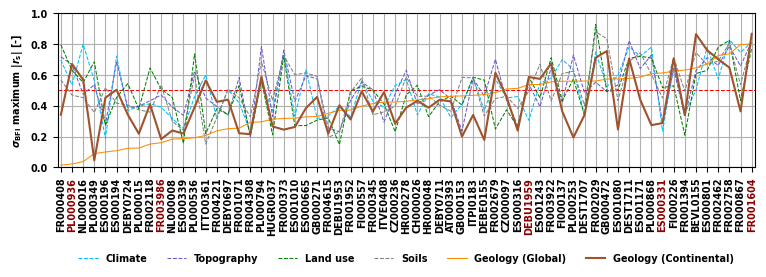

In [72]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
plt.rcParams['font.family'] = 'helvetica'  # Change the font family
plt.rcParams['font.size'] = 7         # Change the font size
plt.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
plt.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Create subplots with shared x-axis and y-axis
fig, axes = plt.subplots(figsize=(9, 2), sharex=True, sharey=True)

dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geology_global', ascending=True)
#dataframe_BFI_sorted = dataframe_BFI.sort_values(by='geology_continental', ascending=True)


# First subplot (axes[0])
axes.axhline(y=0.5, color='red', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['climate'], label='Climate', color='deepskyblue', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['topography'], label='Topography', color='slateblue', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['landuse'], label='Land use', color='green', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['soils'], label='Soils', color='gray', linestyle='--', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geology_global'], label='Geology (Global)', color='darkorange', linewidth=0.75)
axes.plot(dataframe_BFI_sorted.index, dataframe_BFI_sorted['geology_continental'], label='Geology (Continental)', color='sienna')

axes.set_ylim(0, 1)
axes.set_xlim(-0.3, 62.3)
axes.set_ylabel(r'$\sigma_{\mathrm{BFI}}$ maximum |$r_{\mathregular{s}}$| [-]')

# Rotate x-tick labels for the second subplot and set the last x-tick color to red
axes.tick_params(axis='x', rotation=90)
xticks = axes.get_xticklabels()


xticks[42].set_color('darkred')
xticks[-9].set_color('darkred')
xticks[1].set_color('darkred')
xticks[-1].set_color('darkred')
xticks[9].set_color('darkred')

xticks[42].set_fontweight('bold')
xticks[-9].set_fontweight('bold')
xticks[1].set_fontweight('bold')
xticks[-1].set_fontweight('bold')
xticks[9].set_fontweight('bold')

# Apply modified x-tick labels back to the axis
axes.set_xticklabels(xticks)

# Customize the legend
# Define font properties for bold text
bold_font = FontProperties(weight='bold')

# Create the legend with bold title and labels
axes.legend(
    frameon=False,
    title="",
    title_fontsize='medium',  # Adjust title font size as needed
    loc='upper center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=6,
    prop=bold_font  # Apply bold font to labels
)

# Disable grid for second subplot
axes.grid(True)
axes.grid(True)

# Save and show the plot
plt.savefig(r'results\figs\fig_lineplot_orderedBFI.png', dpi=300, bbox_inches='tight')
plt.show()

### Count some results

In [488]:
dataframe_BFI_sorted["max"][dataframe_BFI_sorted["max"] <= 0.5]

PL000015    0.397150
NL000008    0.453683
ES000339    0.337409
FR004221    0.395830
FR004308    0.328402
HUGR0037    0.433823
FR004615    0.334918
DEBU1953    0.395952
FR001952    0.496295
ITVE0408    0.411280
HR000048    0.476934
AT000393    0.462078
CZ000097    0.461196
ES000316    0.460096
DEST1707    0.482924
FR001394    0.494535
Name: max, dtype: float64

In [489]:
len(dataframe_BFI_sorted["max"][dataframe_BFI_sorted["max"] >= 0.5])

47

In [491]:
47/63

0.746031746031746

In [492]:
# Add a new column with the column name having the highest value for each row
dataframe_BFI_sorted_new = dataframe_BFI_sorted.copy()
dataframe_BFI_sorted['Max_Column'] = dataframe_BFI_sorted_new.iloc[:, 0:6].idxmax(axis=1)

# Count the occurrences of each column name in the 'Max_Column'
column_counts = dataframe_BFI_sorted['Max_Column'].value_counts()
column_counts

Max_Column
landuse                15
soils                  13
climate                12
topography             10
geology_global          7
geology_continental     6
Name: count, dtype: int64

## Figure 3: Scatter plots

In [73]:
# Catchments used as example
["PL000936", "ES000665", "DEBU1959", "FR001604", "ES000331"]

['PL000936', 'ES000665', 'DEBU1959', 'FR001604', 'ES000331']

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

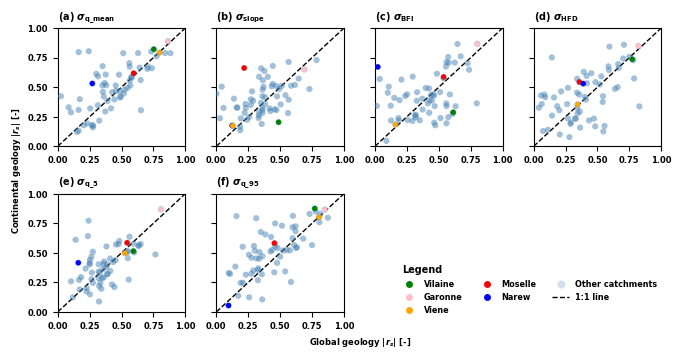

In [75]:
corr_low_geology_df_25_6sig = corr_low_geology_df_25.loc[["q_mean", "slope_sawicz", "baseflow_index", 
                            "hfd_mean", "q_5", "q_95"]]

corr_med_geology_df_25_6sig = corr_med_geology_df_25.loc[["q_mean", "slope_sawicz", "baseflow_index", 
                            "hfd_mean", "q_5", "q_95"]]

from matplotlib.lines import Line2D

# Set up the figure and subplots layout: 2 rows and 7 columns (14 subplots)
fig, axes = plt.subplots(2, 4, figsize=(7, 3.8), sharex=False, sharey=True)
n_cols = 4

# Flatten axes for easy iteration
axes = axes.flatten()
# Create custom x labels (adjust based on your data)
custom_x_labels = [
    '$\sigma_{\mathrm{q\_mean}}$', '$\sigma_{\mathrm{slope}}$', '$\sigma_{\mathrm{BFI}}$', 
    '$\sigma_{\mathrm{HFD}}$', '$\sigma_{\mathrm{q\_5}}$', '$\sigma_{\mathrm{q\_95}}$']

# Example data, using only part of the subplots to simulate "empty" ones
num_plots = len(custom_x_labels)  # or fewer if not all will be used

# Iterate over each column and create scatter plots
for i, column in enumerate(corr_low_geology_df_25_6sig.T.columns):
    x = corr_low_geology_df_25_6sig.T[column]
    y = corr_med_geology_df_25_6sig.T[column]
    
    axes[i].plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1)

    # Create scatter plot for each signature
    axes[i].scatter(x, y, color='steelblue', alpha=0.5, s=20, edgecolor='none', zorder=10)
    axes[i].scatter(corr_low_geology_df_25_6sig.T[column]["DEBU1959"], corr_med_geology_df_25_6sig.T[column]["DEBU1959"], color='red', alpha=1.00, s=15, edgecolor='none', zorder=10)
    axes[i].scatter(corr_low_geology_df_25_6sig.T[column]["PL000936"], corr_med_geology_df_25_6sig.T[column]["PL000936"], color='blue', alpha=1.00, s=15, edgecolor='none', zorder=10)
    axes[i].scatter(corr_low_geology_df_25_6sig.T[column]["ES000331"], corr_med_geology_df_25_6sig.T[column]["ES000331"], color='green', alpha=1.00, s=15, edgecolor='none', zorder=10)
    axes[i].scatter(corr_low_geology_df_25_6sig.T[column]["FR003986"], corr_med_geology_df_25_6sig.T[column]["FR003986"], color='orange', alpha=1.00, s=15, edgecolor='none', zorder=10)
    axes[i].scatter(corr_low_geology_df_25_6sig.T[column]["FR001604"], corr_med_geology_df_25_6sig.T[column]["FR001604"], color='pink', alpha=1.00, s=15, edgecolor='none', zorder=10)

    # Plot the y=x line
    min_val = min(min(x), min(y))
    max_val = max(max(x), max(y))
    
    # Calculate and plot regression line spanning [0, 1]
    if len(x) > 1:  # Ensure there are enough points for regression
        slope, intercept = np.polyfit(x, y, 1)
        x_range = np.linspace(0, 1, 100)  # Generate x values from 0 to 1
        y_range = slope * x_range + intercept
        #axes[i].plot(x_range, y_range, color='blue', linestyle='--', linewidth=1, alpha=0.5)


    # Set title for each subplot
    axes[i].set_title(f"({chr(97 + i)}) {custom_x_labels[i]}", fontsize=7, loc="left", fontweight="bold")
    axes[i].set_xlim(0,1)
    axes[i].set_ylim(0,1)

    # Ensure 0.5 is included in both x and y ticks
    axes[i].set_xticks([0, 0.25, 0.5, 0.75, 1], ['0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=6)
    axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1], ['0.00', '0.25', '0.50', '0.75', '1.00'], fontsize=6)


# Delete any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Create custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=6, label='Vilaine'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', markersize=6, label='Garonne'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=6, label='Viene'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=6, label='Moselle'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=6, label='Narew'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=6, label='Other catchments', alpha=0.25),
    Line2D([0], [0], color='black', linestyle='--', lw=1, label='1:1 line'),
    #Line2D([0], [0], color='blue', linestyle='--', lw=1, label='Linear trend line')
]

# Add the legend with title and font size adjustments
fig.legend(
    handles=legend_elements,
    loc='lower right',
    bbox_to_anchor=(0.975, 0.1),
    ncol=3,
    frameon=False,
    title="",                  # Title for the legend
    title_fontsize='medium',         # Title font size
    fontsize='small'                 # Font size for legend items
)

# Add the title manually
title = "Legend"
fig.text(0.6, 0.23, title, fontsize='medium', fontweight='bold', ha='left')

# Set common labels
fig.text(0.54, 0.04, "Global geology |$r_s$| [-]", ha='center', fontsize=6, fontweight="bold")
fig.text(0.04, 0.5, "Continental geology |$r_s$| [-]", va='center', rotation='vertical', fontsize=6, fontweight="bold")

# Adjust layout for better readability
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

fig.savefig(r'results\figs\fig_scatterplots_b.png', dpi=300, bbox_inches='tight')


plt.show()

### Make some evaluation counting the values

In [498]:
corr_med_geology_df_25_diff = corr_med_geology_df_25 - corr_low_geology_df_25

corr_med_geology_df_25_diff

ES000801  ES000665  ES001243  ES000196  ES000194  \
q_mean                     0.326436 -0.078467  0.230621  0.560726  0.632155   
q_runoff_ratio             0.323756 -0.123912  0.200894  0.524419  0.654412   
q_elas_Sankarasubramanian -0.007140 -0.164707  0.112865  0.220829  0.240430   
slope_sawicz               0.094414 -0.053245  0.129850  0.128077  0.184407   
baseflow_index             0.089435  0.057080  0.036554  0.352628  0.395785   
hfd_mean                   0.079499  0.115565 -0.238216  0.608136  0.027973   
hfd_std                   -0.000917 -0.041161 -0.022952  0.491185  0.094539   
q_5                       -0.233512  0.004911  0.233735  0.530417  0.405152   
q_95                       0.328139  0.030117  0.205457  0.480797  0.652213   
hq_freq                   -0.052461  0.105667  0.110051  0.578785  0.419067   
hq_dur                     0.258730  0.077504 -0.001930  0.267134  0.374472   
lq_freq                   -0.035266 -0.090557  0.115981  0.371371  0.199984   
lq_dur                    -0.001009 -0.089010 -0.218212  0.479602 -0.001825   
zero_q_freq               -0.210481 -0.092403  0.142456  0.161656 -0.070865   

                           ES001080  ES000316  ES000339  ES000331  GB000472  \
q_mean                     0.310614  0.166003 -0.013805  0.067934  0.158281   
q_runoff_ratio             0.446288  0.212664 -0.045788  0.034740  0.182144   
q_elas_Sankarasubramanian  0.213913  0.111578 -0.280284 -0.093059  0.272664   
slope_sawicz              -0.172744 -0.096606  0.061825 -0.283838  0.073409   
baseflow_index            -0.328538 -0.274466  0.033146 -0.325365  0.181531   
hfd_mean                  -0.313949  0.180418  0.032330 -0.036667  0.248389   
hfd_std                   -0.092166  0.425074  0.099641  0.029842  0.081187   
q_5                       -0.282100  0.117308 -0.070758 -0.078615  0.172359   
q_95                       0.263155  0.167348  0.070436  0.103663  0.213121   
hq_freq                    0.422905 -0.300891  0.039228 -0.220011  0.064898   
hq_dur                     0.046756  0.119929 -0.038829 -0.180980 -0.168367   
lq_freq                   -0.148064 -0.251029  0.016680 -0.036931  0.250957   
lq_dur                     0.112498  0.017483 -0.078407  0.034920 -0.083821   
zero_q_freq                0.387334 -0.038467 -0.264388 -0.002494  0.045652   

                           ...  HR000278  CZ000236  DEST1707  DEBE0155  \
q_mean                     ...  0.007470 -0.071317 -0.088834 -0.054101   
q_runoff_ratio             ...  0.048314 -0.035887 -0.080302 -0.053627   
q_elas_Sankarasubramanian  ...  0.059979  0.073157 -0.002653  0.011700   
slope_sawicz               ...  0.017672 -0.166101 -0.280297 -0.095991   
baseflow_index             ... -0.040895 -0.140628 -0.219758 -0.293886   
hfd_mean                   ... -0.215471 -0.202478 -0.090870 -0.030928   
hfd_std                    ... -0.157515  0.081616  0.062710 -0.280400   
q_5                        ...  0.113949  0.020761 -0.069594 -0.016523   
q_95                       ... -0.082828 -0.031177 -0.060460 -0.055738   
hq_freq                    ...  0.012026 -0.114255 -0.144442 -0.166483   
hq_dur                     ... -0.007150  0.109408  0.073844 -0.069906   
lq_freq                    ...  0.029692  0.019979 -0.299932 -0.070126   
lq_dur                     ... -0.110156 -0.007541  0.172699 -0.118545   
zero_q_freq                ...  0.142538 -0.021452  0.000000 -0.088678   

                           FR002758  FR002462  FR001394  FR000867  FR004308  \
q_mean                    -0.096913 -0.114364 -0.077651 -0.347378 -0.018854   
q_runoff_ratio            -0.123177 -0.142019 -0.090726 -0.344130  0.000377   
q_elas_Sankarasubramanian -0.171035 -0.043122  0.010812 -0.133054 -0.109498   
slope_sawicz              -0.056235 -0.053668  0.147468  0.192973 -0.018288   
baseflow_index            -0.089516 -0.024072 -0.292873 -0.434042 -0.077623   
hfd_mean                  -0.151499 -0.052515 -0.158471  0.103077 -0.4

In [502]:
# Count positive values in each row
positive_counts = corr_med_geology_df_25_diff.apply(lambda row: (row >= -0.0).sum(), axis=1)

# Add the counts as a new column, if desired
corr_med_geology_df_25_diff['positive_count'] = positive_counts/63

In [503]:
corr_med_geology_df_25_diff["positive_count"]

q_mean                       0.571429
q_runoff_ratio               0.587302
q_elas_Sankarasubramanian    0.730159
slope_sawicz                 0.555556
baseflow_index               0.539683
hfd_mean                     0.619048
hfd_std                      0.682540
q_5                          0.539683
q_95                         0.682540
hq_freq                      0.634921
hq_dur                       0.666667
lq_freq                      0.587302
lq_dur                       0.507937
zero_q_freq                  0.634921
Name: positive_count, dtype: float64

In [501]:
# Count values above 0.05 in each row
positive_counts = corr_med_geology_df_25_diff.apply(lambda row: (row > 0.05).sum(), axis=1)

# Count values that are either above 0.05 or below -0.05 in each row
total_count = corr_med_geology_df_25_diff.apply(lambda row: ((row > 0.05) | (row < -0.05)).sum(), axis=1)

# Calculate the final count by dividing positive counts by the adjusted total count
corr_med_geology_df_25_diff['adjusted_positive_ratio'] = positive_counts / total_count

corr_med_geology_df_25_diff['adjusted_positive_ratio']

q_mean                       0.627907
q_runoff_ratio               0.613636
q_elas_Sankarasubramanian    0.755556
slope_sawicz                 0.591837
baseflow_index               0.549020
hfd_mean                     0.588235
hfd_std                      0.711111
q_5                          0.522727
q_95                         0.729167
hq_freq                      0.568182
hq_dur                       0.666667
lq_freq                      0.565217
lq_dur                       0.523810
zero_q_freq                  0.600000
Name: adjusted_positive_ratio, dtype: float64

In [514]:
# Count values above 0.05 in each row
positive_counts = corr_med_geology_df_25_diff.apply(lambda row: (row > 0.1).sum(), axis=1)

# Count values that are either above 0.05 or below -0.05 in each row
total_count = corr_med_geology_df_25_diff.apply(lambda row: ((row > 0.1) | (row < -0.1)).sum(), axis=1)

# Calculate the final count by dividing positive counts by the adjusted total count
corr_med_geology_df_25_diff['adjusted_positive_ratio'] = positive_counts / total_count

corr_med_geology_df_25_diff['adjusted_positive_ratio']

q_mean                       0.851852
q_runoff_ratio               0.774194
q_elas_Sankarasubramanian    0.757576
slope_sawicz                 0.687500
baseflow_index               0.583333
hfd_mean                     0.631579
hfd_std                      0.708333
q_5                          0.692308
q_95                         0.812500
hq_freq                      0.606061
hq_dur                       0.857143
lq_freq                      0.696970
lq_dur                       0.666667
zero_q_freq                  0.866667
Name: adjusted_positive_ratio, dtype: float64

## Individual tests: Moselle

100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


            len
DEBU1959  152.0


100%|██████████| 14/14 [00:00<00:00, 32.33it/s]


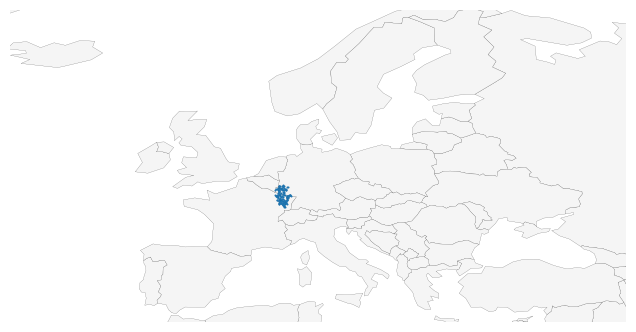

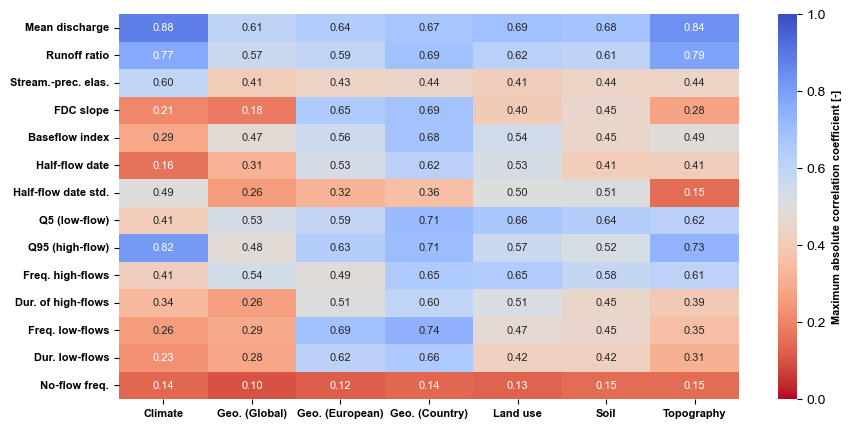

In [129]:
# Here we filter the list of nested_catchments according to this first filter:
list_cats = ["DEBU1959"]

nested_cats_df = nested_catchments.loc[list_cats, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 
# Filter only the catchemnts using the function stated before:
nested_cats_filtered = find_max_unique_rows(nested_cats_df)

# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]


# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip



# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)


# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]
print(nested_cats_filtered_abovevalue)


# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)


estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]


# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

        "perm_high_glob", "perm_medium_glob", "perm_low_glob", "perm_verylow_glob", 
        "perm_high_cont", "perm_medium_cont", "perm_low_cont", "perm_verylow_cont",
        "perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
#plt.figure(figsize=(20, 16))
#sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
#            cbar_kws={'label': 'Correlation Coefficient'}, 
#            yticklabels=combined_correlation_df.index)
#
##plt.title('Combined Heatmap for All Signatures', fontsize=20)
##plt.xlabel('Variables', fontsize=15)
#plt.ylabel('', fontsize=15)

## Customize font sizes
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#
#plt.show()


# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
        'p_mean': 'climatic',
        'pet_mean': 'climatic',
        'aridity': 'climatic',
        'p_seasonality': 'climatic',
        'frac_snow': 'climatic',
        'hp_freq': 'climatic',
        'hp_dur': 'climatic',
        'hp_time': 'climatic',
        'lp_freq': 'climatic',
        'lp_dur': 'climatic',
        'lp_time': 'climatic',
        'ele_mt_max': 'topography',
        'ele_mt_mean': 'topography',
        'ele_mt_min': 'topography',
        'slp_dg_mean': 'topography',
        'flat_area_fra': 'topography',
        'steep_area_fra': 'topography',
        'elon_ratio': 'topography',
        'strm_dens': 'topography',
        'lit_dom': 'geology',
        'bedrk_dep': 'soil',

        'perm_verylow_glob': 'geology_low',
        'perm_low_glob': 'geology_low',
        'perm_medium_glob': 'geology_low',
        'perm_high_glob': 'geology_low',

        'root_dep_mean': 'soil',
        'root_dep_max': 'soil',
        'root_dep_min': 'soil',
        'soil_tawc_mean': 'soil',
        'soil_fra_sand_mean': 'soil',
        'soil_fra_silt_mean': 'soil',
        'soil_fra_clay_mean': 'soil',
        'soil_fra_grav_mean': 'soil',
        'soil_bd_mean': 'soil',
        'soil_oc_mean': 'soil',
        'lai_mean': 'lulc',
        'ndvi_mean': 'lulc',
        'lulc_2006_urban': 'lulc',
        'lulc_2006_NonIrriAgri': 'lulc',
        'lulc_2006_Agric': 'lulc',
        'lulc_2006_forest': 'lulc',
        'lulc_2006_grass': 'lulc',
        'lulc_2006_agriculture': 'lulc',
        'dam_num': 'hydrology',
        'res_num': 'hydrology',
        'lakes_num': 'hydrology',
        'sno_cov_mean': 'climatic',
        'irri_1990': 'hydrology',
        'irri_2005': 'hydrology',

        'perm_high_cont': 'geology_med',
        'perm_medium_cont': 'geology_med',
        'perm_low_cont': 'geology_med',
        'perm_verylow_cont': 'geology_med',

        'stations_num_p_mean': 'climatic',

        'perm_high_regi': "geology_high", 
        'perm_medium_regi': "geology_high", 
        'perm_low_regi': "geology_high",
        'perm_verylow_regi': "geology_high",
        "area_estreams": "topography"
    }


# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > abs(max_corr[cls]):
                max_corr[cls] = correlation_df.loc[feature, catchment]
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_climatic', 'corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high",
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = ["Climate", "Geo. (Global)", "Geo. (European)", "Geo. (Country)", "Land use", 
                   "Soil", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['Mean discharge', 'Runoff ratio','Stream.-prec. elas.','FDC slope','Baseflow index','Half-flow date','Half-flow date std.', 
                   'Q5 (low-flow)', 'Q95 (high-flow)','Freq. high-flows', 'Dur. of high-flows', 'Freq. low-flows', 'Dur. low-flows', 'No-flow freq.']

corr_max_group_dfs_abs = corr_max_group_dfs.abs()
# Plot the heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label('Maximum absolute correlation coefficient [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()



In [130]:
correlation_dict["baseflow_index"].loc[["perm_high_glob", "perm_medium_glob", "perm_low_glob", "perm_verylow_glob", 
            "perm_high_cont", "perm_medium_cont", "perm_low_cont", "perm_verylow_cont",
            "perm_high_regi", "perm_medium_regi", "perm_low_regi", "perm_verylow_regi"]]

DEBU1959
perm_high_glob     0.473061
perm_medium_glob  -0.448081
perm_low_glob      0.200780
perm_verylow_glob  0.287463
perm_high_cont     0.557096
perm_medium_cont  -0.223361
perm_low_cont      0.339365
perm_verylow_cont -0.095056
perm_high_regi     0.680013
perm_medium_regi  -0.246993
perm_low_regi     -0.298355
perm_verylow_regi -0.011665

In [131]:
df = estreams_attributes_dfs[catchment]

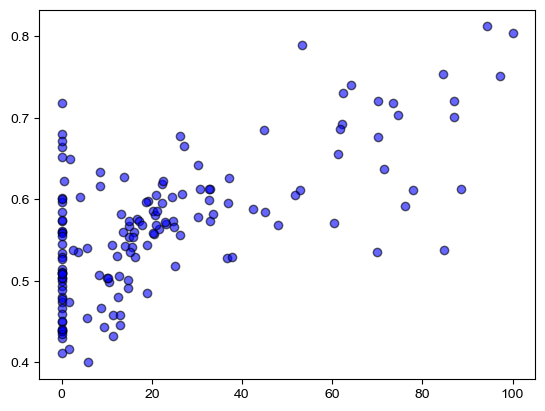

In [132]:
plt.scatter(df['perm_high_cont'], df['baseflow_index'], color='blue', alpha=0.6, edgecolor='black')


# Study area figures

#### Here we create a simple function to plot the catchments

In [90]:
# Function to plot a single catchment
def plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, network_estreams_gdf, i, alpha_maps):
    # Select the catchment geometry
    selected_geometry = catchment_boundaries.loc[[catchment_id], "geometry"]
    
    # Create a GeoDataFrame from the selected geometries and set the CRS directly
    selected_gdf = gpd.GeoDataFrame({'geometry': selected_geometry}, crs='EPSG:4326')
    
    # Add a column for colors based on the class
    GLiM_reprojected['color'] = GLiM_reprojected['class'].map(color_mapping_glim)

    # Set plot limits to the bounding box of the selected study areas
    bounds = selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

    # Create a mask that covers the entire plotting area
    plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
    mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

    # Combine the selected geometries into one
    combined_geometry = selected_gdf.unary_union

    # Create the mask by subtracting the combined geometry from the plot extent
    mask['geometry'] = mask.difference(combined_geometry)

    # Plot the geology shapefile with different colors for each class
    GLiM_reprojected.plot(column='class', ax=ax, legend=False, 
                          categorical=True, color=GLiM_reprojected['color'], edgecolor='none', linewidth=0, alpha=alpha_maps)

    # Overlay the study area boundaries
    selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5, label='')

    # Plot the points from network_estreams_filtered
    network_estreams_gdf.plot(ax=ax, color='black', markersize=5, edgecolor='none', linewidth=0.5, 
                              label='Measurement Points')

    # Plot the mask to cover everything outside the study area
    mask.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

    # Set plot limits to the bounding box of the study area
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_axis_off()  # Turn off both x-axis and y-axis
    ax.set_aspect('equal')
    
    # Set plot title and labels
    #ax.set_title(f'({chr(97 + i)}) {catchment_id}', fontsize="8", y=1.05, loc="left")
    ax.set_xlabel('')
    ax.set_ylabel('')

In [116]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'helvetica'  # Change the font family
mpl.rcParams['font.size'] = 6          # Change the font size
mpl.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

## Appendix B: Raw geology maps for the 4 regional catchments

#### First we define a geodataframe to be further used


In [31]:
# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams['lon'], network_estreams['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams.index

# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams['lon'], network_estreams['lat'])]
network_estreams_all_gdf = gpd.GeoDataFrame(network_estreams, geometry=geometry, crs='EPSG:4326')
network_estreams_all_gdf["basin_id"] = network_estreams.index

#### Part A: Global map

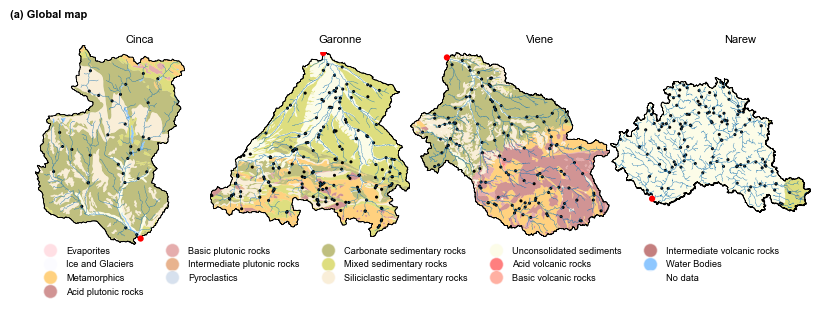

In [96]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define color mappings for legend
color_mapping_glim_legend = {
    'Evaporites': "pink",
    'Ice and Glaciers': "ghostwhite",
    'Metamorphics': "orange",
    'Acid plutonic rocks': "brown",
    'Basic plutonic rocks': "indianred",
    'Intermediate plutonic rocks': "chocolate",
    'Pyroclastics': "lightsteelblue",
    'Carbonate sedimentary rocks': "olive",
    'Mixed sedimentary rocks': "y",
    'Siliciclastic sedimentary rocks': "#F5DEB3",
    'Unconsolidated sediments': "#FAFAD2",
    'Acid volcanic rocks': "red",
    'Basic volcanic rocks': "tomato",
    'Intermediate volcanic rocks': "darkred",
    'Water Bodies': "#1E90FF",
    'No data': "white"
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["ES000331", "FR001604", "FR003986","PL000936", ]
catchment_names = ["Cinca", "Garonne","Viene", "Narew"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 5
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, network_estreams_gdf, j, alpha_maps=0.5)
    
    if catchment_id == "ES000331":
        rivers_cinca.plot(ax=ax, linewidth=0.25, label='River network')
    elif catchment_id == "FR001604":
        rivers_garonne.plot(ax=ax, linewidth=0.25, label='River network')
    else:
        rivers_fivesubs_es.plot(ax=ax, linewidth=0.25, label='River network')

    network_estreams_all_gdf.loc[[catchment_id]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)

    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.5)
                   for label, color in color_mapping_glim_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.4, -0.3), ncol=5, frameon=False, fontsize='small', title='')

# Add catchment labels to the figure, aligning them above each subplot
for i, catchment_id in enumerate(catchment_names):
    # Position relative to each subplot area
    fig.text(0.13 + i % n_cols * 1 / n_cols, 1.025 - i // n_cols * 1 / n_rows, f'{catchment_id}',
             ha='center', va='center', fontsize=8, fontweight='normal')
    
fig.text(0.0, 1.15 , "(a) Global map",
             ha='left', va='center', fontsize=8, fontweight='bold')

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_a.png', dpi=300, bbox_inches='tight')

plt.show()

#### Part B: Continental map

In [89]:
catchment_boundaries

gauge_id country  area_offic  area_estre  area_flag  area_rel  \
basin_id                                                                 
AT000001   200014      AT      4647.9    4668.379          0 -0.440608   
AT000002   200048      AT       102.0     102.287          0 -0.281373   
AT000003   231662      AT       535.2     536.299          0 -0.205344   
AT000004   200592      AT        66.6      66.286          0  0.471471   
AT000005   200097      AT        72.2      72.448          0 -0.343490   
...           ...     ...         ...         ...        ...       ...   
UAGR0017  6682300      UA       321.0     325.370          0 -1.361371   
UAGR0018  6682500      UA        49.7      47.594          0  4.237425   
UAGR0019  6683010      UA       261.0     244.731          1  6.233333   
UAGR0020  6683200      UA       760.0     731.073          0  3.806184   
UAGR0021  6683300      UA       582.0     599.600          0 -3.024055   

          start_date    end_date gauge_flag  upstream  group  \
basin_id                                                       
AT000001  1996-01-01  2021-12-31          B        16      1   
AT000002  1958-10-01  2021-12-31          B         1      1   
AT000003  1985-01-02  2021-12-31          B         2      1   
AT000004  1998-01-02  2021-12-31          B         1      1   
AT000005  1990-01-01  2019-12-31          B         3      1   
...              ...         ...        ...       ...    ...   
UAGR0017  1978-01-01  1987-12-31          B         1   1988   
UAGR0018  1978-01-01  1987-12-31          B         1   1989   
UAGR0019  1978-01-01  1987-12-31          B         1   1990   
UAGR0020  1978-01-01  1987-12-31          B         1   1991   
UAGR0021  1978-01-01  1987-12-31          B         1   1992   

                                                   geometry  
basin_id                                                     
AT000001  POLYGON Z ((9.69406 46.54322 0.00000, 9.69570 ...  
AT000002  POLYGON Z ((10.13650 47.02949 0.00000, 10.1349...  
AT000003  POLYGON Z ((10.11095 46.89437 0.00000, 10.1122...  
AT000004  POLYGON Z ((10.14189 47.09706 0.00000, 10.1404...  
AT000005  POLYGON Z ((9.67851 47.06249 0.00000, 9.67888 ...  
...                                                     ...  
UAGR0017  POLYGON Z ((33.96791 44.63291 0.00000, 33.9679...  
UAGR0018  POLYGON Z ((34.19958 44.58291 0.00000, 34.2029...  
UAGR0019  POLYGON Z ((34.19624 44.88375 0.00000, 34.1962...  
UAGR0020  POLYGON Z ((35.78708 47.28708 0.00000, 35.7870...  
UAGR0021  POLYGON Z ((38.10125 48.15791 0.00000, 38.1004...  

[17130 rows x 12 columns]

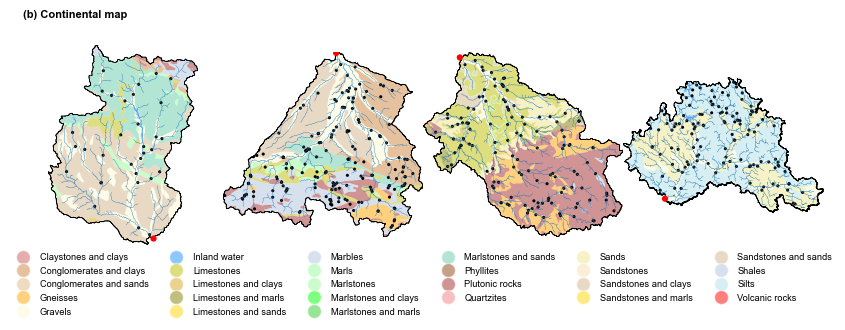

In [91]:
# Extended color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',             # Same as existing
    'Clays': '#CD5C5C',                              # Similar to Claystones and clays
    'Conglomerates': '#D2B48C',                      # Tan, close to Gravels
    'Conglomerates and clays': '#CD853F',            # Peru, slightly darker to indicate mixture
    'Conglomerates and sands': '#DEB887',            # Burlywood, close to Sands
    'Gneisses': 'orange',                            # Same as existing
    'Gravels': '#FAFAD2',                            # Same as existing
    'Inland water': '#1E90FF',                       # Same as existing
    'Limestones': 'y',                               # Same as existing
    'Limestones and clays': '#DAA520',               # Goldenrod, close to Limestones
    'Limestones and marls': 'olive',                 # Same as existing
    'Limestones and sands': '#FFD700',               # Gold, close to Limestones
    'Marbles': '#B0C4DE',                            # LightSteelBlue, similar to Quartzites but distinct
    'Marls': '#98FB98',                              # Pale Green, distinct but related to marlstones
    'Marlstones': 'palegreen',                       # Same as existing
    'Marlstones and clays': 'lime',                  # Same as existing
    'Marlstones and marls': '#32CD32',               # Same as existing
    'Marlstones and sands': '#66CDAA',               # Medium Aquamarine, slightly related to Marl
    'Phyllites': '#8B4513',                          # SaddleBrown, similar to Plutonic rocks
    'Plutonic rocks': 'brown',                       # Same as existing
    'Quartzites': 'lightcoral',                      # Same as existing
    'Sands': 'khaki',                                # Same as existing
    'Sandstones': '#F5DEB3',                         # Same as existing
    'Sandstones and clays': '#D2B48C',               # Tan, slightly darker as mixture
    'Sandstones and marls': 'gold',                  # Same as existing
    'Sandstones and sands': 'tan',                   # Same as existing
    'Schists': '#778899',                            # LightSlateGray, similar to Shales
    'Shales': 'lightsteelblue',                      # Same as existing
    'Silts': '#B0E0E6',                              # PowderBlue, similar to clays but softer
    'Snow field / ice field': '#F8F8FF',             # GhostWhite, indicating a cold area
    'Volcanic rocks': 'red'                          # Same as existing
}

color_mapping_geology_legend = {
    'Claystones and clays': 'indianred',
    #'Clays': '#CD5C5C',
    #'Conglomerates': '#D2B48C',
    'Conglomerates and clays': '#CD853F',
    'Conglomerates and sands': '#DEB887',
    'Gneisses': 'orange',
    'Gravels': '#FAFAD2',
    'Inland water': '#1E90FF',
    'Limestones': 'y',
    'Limestones and clays': '#DAA520',
    'Limestones and marls': 'olive',
    'Limestones and sands': '#FFD700',
    'Marbles': '#B0C4DE',
    'Marls': '#98FB98',
    'Marlstones': 'palegreen',
    'Marlstones and clays': 'lime',
    'Marlstones and marls': '#32CD32',
    'Marlstones and sands': '#66CDAA',
    'Phyllites': '#8B4513',
    'Plutonic rocks': 'brown',
    'Quartzites': 'lightcoral',
    'Sands': 'khaki',
    'Sandstones': '#F5DEB3',
    'Sandstones and clays': '#D2B48C',
    'Sandstones and marls': 'gold',
    'Sandstones and sands': 'tan',
    #'Schists': '#778899',
    'Shales': 'lightsteelblue',
    'Silts': '#B0E0E6',
    #'Snow field / ice field': '#F8F8FF',
    'Volcanic rocks': 'red'
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "ES000665", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["ES000331", "FR001604", "FR003986","PL000936", ]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 5
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, network_estreams_gdf, j, alpha_maps=0.5)
    if catchment_id == "ES000331":
        rivers_cinca.plot(ax=ax, linewidth=0.25, label='River network')
    elif catchment_id == "FR001604":
        rivers_garonne.plot(ax=ax, linewidth=0.25, label='River network')
    else:
        rivers_fivesubs_es.plot(ax=ax, linewidth=0.25, label='River network')
    network_estreams_all_gdf.loc[[catchment_id]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)
    
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.5)
                   for label, color in color_mapping_geology_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.4, -0.4), ncol=6, frameon=False, fontsize='small', title='')

fig.text(0.0, 1.15 , "(b) Continental map",
             ha='left', va='center', fontsize=8, fontweight='bold')

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_geologies_b.png', dpi=300, bbox_inches='tight')


plt.show()

Check the rock-types used (usefull for the legend creation)

In [93]:
import geopandas as gpd
from shapely.geometry import box

def clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim):
    # Select the geometries for the specified basin IDs
    selected_geometries = catchment_boundaries[catchment_boundaries.index.isin(basin_ids)]

    # Dissolve the selected geometries into one to create a single combined shape for clipping
    combined_geometry = selected_geometries.unary_union

    # Clip the geology map by the combined basin geometry
    clipped_geology = GLiM_reprojected.clip(combined_geometry)

    # Get unique geology classes within the clipped area
    unique_geology_classes = clipped_geology['class'].unique()

    # Map colors to each unique class
    clipped_geology['color'] = clipped_geology['class'].map(color_mapping_glim)

    return clipped_geology, unique_geology_classes

# Example usage:
# List of basin IDs to clip by
#basin_ids = ["FR001604","PL000936", "FR000867", "FR000373"]  # Add more catchment IDs as needed
basin_ids = ["PL000936", "FR000867", "DEBU1959", "FR003986", "FR001604"]

# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, GLiM_reprojected, color_mapping_glim)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)


# Get clipped geology and unique geology classes
clipped_geology, unique_geology_classes = clip_geology_by_basins(basin_ids, catchment_boundaries, IHME_reprojected, color_mapping_geology)

# Display the unique geology classes in the clipped area
print("Unique geology classes in the clipped area:", unique_geology_classes)

Unique geology classes in the clipped area: ['wb' 'vb' 'ss' 'pa' 'vi' 'mt' 'pb' 'sm' 'sc' 'su' 'va' 'pi']
Unique geology classes in the clipped area: ['Marlstones and marls' 'Marlstones and clays' 'Gravels'
 'Sandstones and sands' 'Sandstones and marls' 'Conglomerates and clays'
 'Volcanic rocks' 'Conglomerates and sands' 'Marlstones and sands' 'Marls'
 'Inland water' 'Limestones and marls' 'Sands' 'Plutonic rocks' 'Shales'
 'Marlstones' 'Limestones' 'Sandstones and clays' 'Gneisses' 'Quartzites'
 'Sandstones' 'Silts' 'Claystones and clays']


## Figure 5: Permeabilitites instead of classes

#### Part A: Global map

In [38]:
catchment_boundaries

basin_id gauge_id country  area_offic  area_estre  area_flag  area_rel  \
0      AT000001   200014      AT      4647.9    4668.379          0 -0.440608   
1      AT000002   200048      AT       102.0     102.287          0 -0.281373   
2      AT000003   231662      AT       535.2     536.299          0 -0.205344   
3      AT000004   200592      AT        66.6      66.286          0  0.471471   
4      AT000005   200097      AT        72.2      72.448          0 -0.343490   
...         ...      ...     ...         ...         ...        ...       ...   
17125  UAGR0017  6682300      UA       321.0     325.370          0 -1.361371   
17126  UAGR0018  6682500      UA        49.7      47.594          0  4.237425   
17127  UAGR0019  6683010      UA       261.0     244.731          1  6.233333   
17128  UAGR0020  6683200      UA       760.0     731.073          0  3.806184   
17129  UAGR0021  6683300      UA       582.0     599.600          0 -3.024055   

       start_date    end_date gauge_flag  upstream  group  \
0      1996-01-01  2021-12-31          B        16      1   
1      1958-10-01  2021-12-31          B         1      1   
2      1985-01-02  2021-12-31          B         2      1   
3      1998-01-02  2021-12-31          B         1      1   
4      1990-01-01  2019-12-31          B         3      1   
...           ...         ...        ...       ...    ...   
17125  1978-01-01  1987-12-31          B         1   1988   
17126  1978-01-01  1987-12-31          B         1   1989   
17127  1978-01-01  1987-12-31          B         1   1990   
17128  1978-01-01  1987-12-31          B         1   1991   
17129  1978-01-01  1987-12-31          B         1   1992   

                                                geometry  
0      POLYGON Z ((9.69406 46.54322 0.00000, 9.69570 ...  
1      POLYGON Z ((10.13650 47.02949 0.00000, 10.1349...  
2      POLYGON Z ((10.11095 46.89437 0.00000, 10.1122...  
3      POLYGON Z ((10.14189 47.09706 0.00000, 10.1404...  
4      POLYGON Z ((9.67851 47.06249 0.00000, 9.67888 ...  
...                                                  ...  
17125  POLYGON Z ((33.96791 44.63291 0.00000, 33.9679...  
17126  POLYGON Z ((34.19958 44.58291 0.00000, 34.2029...  
17127  POLYGON Z ((34.19624 44.88375 0.00000, 34.1962...  
17128  POLYGON Z ((35.78708 47.28708 0.00000, 35.7870...  
17129  POLYGON Z ((38.10125 48.15791 0.00000, 38.1004...  

[17130 rows x 13 columns]

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

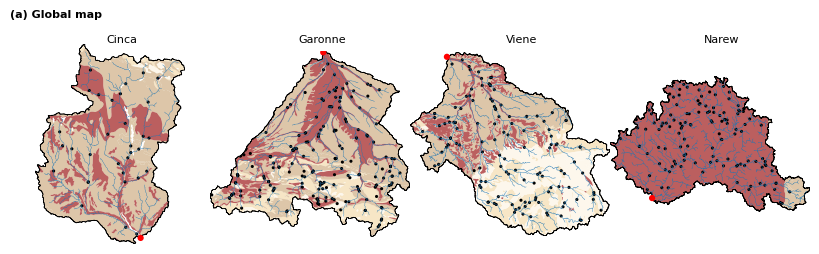

In [62]:
#catchment_boundaries["basin_id"] = catchment_boundaries.index

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "oldlace",  # Evaporites
    'ig': "oldlace",  # Ice and Glaciers
    'mt': "wheat",  # Metamorphics
    'pa': "oldlace",  # Acid plutonic rocks
    'pb': "oldlace",  # Basic plutonic rocks
    'pi': "wheat",  # Intermediate plutonic rocks
    'py': "wheat",  # Pyroclastics
    'sc': "tan",  # Carbonate sedimentary rocks
    'sm': "tan",  # Mixed sedimentary rocks
    'ss': "brown",  # Siliciclastic sedimentary rocks
    'su': "brown",  # Unconsolidated sediments
    'va': "oldlace",  # Acid volcanic rocks
    'vb': "oldlace",  # Basic volcanic rocks
    'vi': "wheat",  # Intermediate volcanic rocks
    'wb': "white",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define color mappings for legend
color_mapping_glim_legend = {
    'Evaporites': "pink",
    'Ice and Glaciers': "ghostwhite",
    'Metamorphics': "orange",
    'Acid plutonic rocks': "brown",
    'Basic plutonic rocks': "indianred",
    'Intermediate plutonic rocks': "chocolate",
    'Pyroclastics': "lightsteelblue",
    'Carbonate sedimentary rocks': "olive",
    'Mixed sedimentary rocks': "y",
    'Siliciclastic sedimentary rocks': "#F5DEB3",
    'Unconsolidated sediments': "#FAFAD2",
    'Acid volcanic rocks': "red",
    'Basic volcanic rocks': "tomato",
    'Intermediate volcanic rocks': "darkred",
    'Water Bodies': "#1E90FF",
    'No data': "white"
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["ES000331", "FR001604", "FR003986", "PL000936"]
catchment_names = ["Cinca", "Garonne","Viene", "Narew"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 4
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))

axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, GLiM_reprojected, color_mapping_glim, network_estreams_all_gdf, j, alpha_maps=0.75)
    
    if catchment_id == "ES000331":
        rivers_cinca.plot(ax=ax, linewidth=0.25, label='River network')
    elif catchment_id == "FR001604":
        rivers_garonne.plot(ax=ax, linewidth=0.25, label='River network')
    else:
        rivers_fivesubs_es.plot(ax=ax, linewidth=0.25, label='River network')
    
    network_estreams_all_gdf.loc[[catchment_id]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Add catchment labels to the figure, aligning them above each subplot
for i, catchment_id in enumerate(catchment_names):
    # Position relative to each subplot area
    fig.text(0.14 + i % n_cols * 1 / n_cols, 1.025 - i // n_cols * 1 / n_rows, f'{catchment_id}',
             ha='center', va='center', fontsize=8, fontweight='normal')
    
fig.text(0.0, 1.15 , "(a) Global map",
             ha='left', va='center', fontsize=8, fontweight='bold')

# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_permeabilities_a_4.png', dpi=300, bbox_inches='tight')


plt.show()

#### Part B: Continental map

In [145]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'helvetica'  # Change the font family
mpl.rcParams['font.size'] = 8          # Change the font size
mpl.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

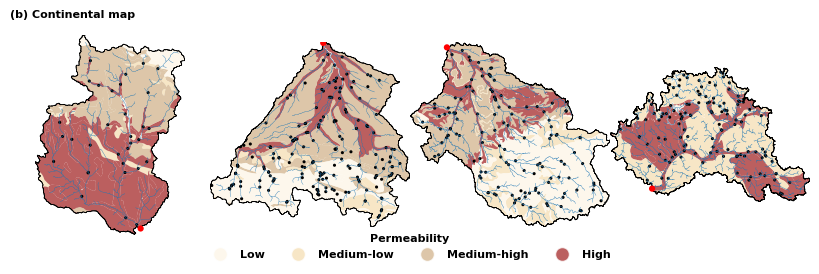

In [121]:
#catchment_boundaries["basin_id"] = catchment_boundaries.index

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd

# Extended color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'wheat',             # Same as existing
    'Clays': 'oldlace',                              # Similar to Claystones and clays
    'Conglomerates': 'brown',                      # Tan, close to Gravels
    'Conglomerates and clays': 'tan',            # Peru, slightly darker to indicate mixture
    'Conglomerates and sands': 'brown',            # Burlywood, close to Sands
    'Gneisses': 'wheat',                            # Same as existing
    'Gravels': 'brown',                            # Same as existing
    'Inland water': 'oldlace',                       # Same as existing
    'Limestones': 'tan',                               # Same as existing
    'Limestones and clays': 'tan',               # Goldenrod, close to Limestones
    'Limestones and marls': 'tan',                 # Same as existing
    'Limestones and sands': 'tan',               # Gold, close to Limestones
    'Marbles': 'wheat',                            # LightSteelBlue, similar to Quartzites but distinct
    'Marls': 'wheat',                              # Pale Green, distinct but related to marlstones
    'Marlstones': 'wheat',                       # Same as existing
    'Marlstones and clays': 'wheat',                  # Same as existing
    'Marlstones and marls': 'wheat',               # Same as existing
    'Marlstones and sands': 'tan',               # Medium Aquamarine, slightly related to Marl
    'Phyllites': 'wheat',                          # SaddleBrown, similar to Plutonic rocks
    'Plutonic rocks': 'oldlace',                       # Same as existing
    'Quartzites': 'oldlace',                      # Same as existing
    'Sands': 'brown',                                # Same as existing
    'Sandstones': 'brown',                         # Same as existing
    'Sandstones and clays': 'tan',               # Tan, slightly darker as mixture
    'Sandstones and marls': 'tan',                  # Same as existing
    'Sandstones and sands': 'brown',                   # Same as existing
    'Schists': 'wheat',                            # LightSlateGray, similar to Shales
    'Shales': 'oldlace',                      # Same as existing
    'Silts': 'wheat',                              # PowderBlue, similar to clays but softer
    'Snow field / ice field': 'oldlace',             # GhostWhite, indicating a cold area
    'Volcanic rocks': 'oldlace'                          # Same as existing
}

# Define catchment IDs and layout
#catchment_ids = ["FR001604", "PL000936", "FR000867", "FR000373", "DEBU1959"]
catchment_ids = ["PL000936", "ES000665", "DEBU1959", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "ES000665", "FR001604", "FR000867"]
catchment_ids = ["PL000936", "FR000867", "FR003986", "FR001604"]
catchment_ids = ["ES000331", "FR001604", "FR003986", "PL000936"]

# Define the figure size for each subplot (width, height) in inches
subplot_width = 2
subplot_height = 2  # half of the previous height for 2 rows

# Number of columns and rows for subplots
n_cols = 4
n_rows = (len(catchment_ids) + n_cols - 1) // n_cols  # to ensure all catchments are plotted


# Create figure and subplots
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2), constrained_layout=True)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_width * n_cols, subplot_height * n_rows))


axes = axes.flatten()

j = 0
# Plot each catchment in subplots
for ax, catchment_id in zip(axes, catchment_ids):
    plot_catchment(ax, catchment_id, catchment_boundaries, IHME_reprojected, color_mapping_geology, network_estreams_all_gdf, j,
                   alpha_maps=0.75)
    
    if catchment_id == "ES000331":
        rivers_cinca.plot(ax=ax, linewidth=0.25, label='River network')
    elif catchment_id == "FR001604":
        rivers_garonne.plot(ax=ax, linewidth=0.25, label='River network')
    else:
        rivers_fivesubs_es.plot(ax=ax, linewidth=0.25, label='River network')
    
    network_estreams_all_gdf.loc[[catchment_id]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)
    j = j + 1

# Hide any empty subplots
for i in range(len(catchment_ids), len(axes)):
    fig.delaxes(axes[i])

# Define your dictionary with labels and corresponding colors
color_mapping_geology_legend = {
    'Low': 'oldlace',
    'Medium-low': 'wheat',
    'Medium-high': 'tan',
    'High': 'brown'
}

# Create legend elements
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label, alpha=0.75)
                   for label, color in color_mapping_geology_legend.items()]

# Add legend outside plot area at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.175), ncol=7, frameon=False, fontsize='medium', title='Permeability')

fig.text(0.0, 1.1 , "(b) Continental map",
             ha='left', va='center', fontsize=8, fontweight='bold')
# Adjust layout and display
plt.tight_layout(pad=0)

fig.savefig(r'results\figs\fig_permeabilities_b_4.png', dpi=300, bbox_inches='tight')

plt.show()

## Tables
#### Export a table with data for supporting information

In [133]:
estreams_attributes_dfs_moselle = estreams_attributes_dfs["DEBU1959"][["area_estreams", 'lon', 'lat', 'start_date', 'end_date',
       'num_years', "gauges_upstream"]]
estreams_attributes_dfs_moselle.to_csv("results/table_modelle.csv")

# Intermediate scale analysis: Moselle

## Boxplot of the Moselle 

In [134]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["DEBU1959"]

100%|██████████| 1/1 [00:00<00:00, 474.52it/s]


gauge_id     gauge_name gauge_country  gauge_provider      river  \
basin_id                                                                     
BEWA0066  99141002        Reuland            BE          BE_SPW        Our   
BEWA0067  99261002     Schoenberg            BE          BE_SPW        Our   
BEWA0087  56100000     Martelange            BE          BE_SPW       Sure   
BEWA0106  60800000        Reuland            BE          BE_SPW        Ulf   
BEWA0107  60900000  Lommersweiler            BE          BE_SPW  Braunlauf   
...            ...            ...           ...             ...        ...   
LU000015        34       Michelau            LU  LU_CONTACTFORM       Sure   
LU000016         3    Pfaffenthal            LU  LU_CONTACTFORM    Alzette   
LU000017        16        Rosport            LU  LU_CONTACTFORM       Sure   
LU000018         5     Schoenfels            LU  LU_CONTACTFORM      Mamer   
LU000019        12        Vianden            LU  LU_CONTACTFORM        Our   

          lon_snap   lat_snap       lon        lat elevation  ...  \
basin_id                                                      ...   
BEWA0066  6.151802  50.188258  6.151802  50.188258       NaN  ...   
BEWA0067  6.263467  50.289277  6.263467  50.289277       NaN  ...   
BEWA0087  5.739269  49.833704  5.739269  49.833704       NaN  ...   
BEWA0106  6.150669  50.196522  6.150669  50.196522       NaN  ...   
BEWA0107  6.153292  50.235014  6.153955  50.234494       NaN  ...   
...            ...        ...       ...        ...       ...  ...   
LU000015  6.091178  49.895421  6.091178  49.895421       NaN  ...   
LU000016  6.132266  49.620647  6.132266  49.620647       NaN  ...   
LU000017  6.509851  49.785883  6.509851  49.785883       NaN  ...   
LU000018  6.100795  49.723112  6.100795  49.723112       NaN  ...   
LU000019  6.204738  49.939224  6.204738  49.939224       NaN  ...   

          lakes_tot_area  lakes_tot_vol  sno_cov_mean  irri_1990 irri_2005  \
basin_id                                                                     
BEWA0066            0.00           0.00         7.497      1.400     3.429   
BEWA0067            0.00           0.00         8.920      0.000     0.075   
BEWA0087            0.00           0.00         6.106      0.000     0.000   
BEWA0106            0.00           0.00         7.096      1.200     2.427   
BEWA0107            0.00           0.00         6.996      0.200     0.605   
...                  ...            ...           ...        ...       ...   
LU000015            1.80          62.62         5.680      0.045     0.045   
LU000016            0.00           0.00         2.863      0.004     0.009   
LU000017            2.67          67.85         4.753      1.641     4.770   
LU000018            0.00           0.00         3.184      0.015     0.015   
LU000019            0.00           0.00         6.627      1.495     3.524   

         stations_num_p_mean  perm_high_regi  perm_medium_regi  perm_low_regi  \
basin_id                                                                        
BEWA0066                16.0        2.947531          0.000000       3.319025   
BEWA0067                 8.0        2.347625          0.000000       0.000000   
BEWA0087                 6.0        0.005000          0.000000       0.000000   
BEWA0106                 9.0        0.000000          0.000000       0.000000   
BEWA0107                 6.0        3.999021          0.000000      15.492765   
...                      ...             ...               ...            ...   
LU000015                25.0        1.917023          0.000000       0.000000   
LU000016                15.0       14.327884         32.255374      53.416742   
LU000017                78.0       18.753136          5.872553      24.977481   
LU000018                17.0       39.499138          0.000000      60.500862   
LU000019                27.0        3.530352          2.493791       1.855134   

          perm_verylow_regi 

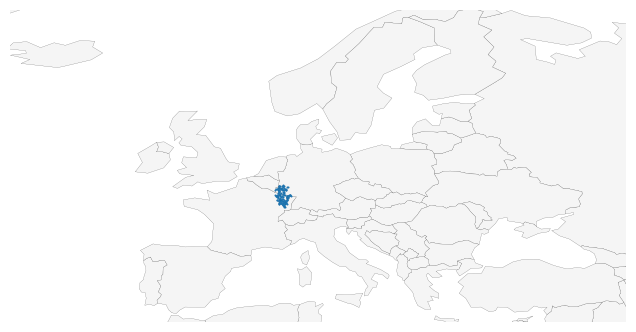

In [135]:
# Here we just plot the catchment for visual inspection
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='', limits_europe = True)

### Computation of the correlation values

In [136]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       "perm_verylow_regi", "perm_low_regi", "perm_medium_regi", "perm_high_regi",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict.keys())

100%|██████████| 14/14 [00:00<00:00, 31.34it/s]

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


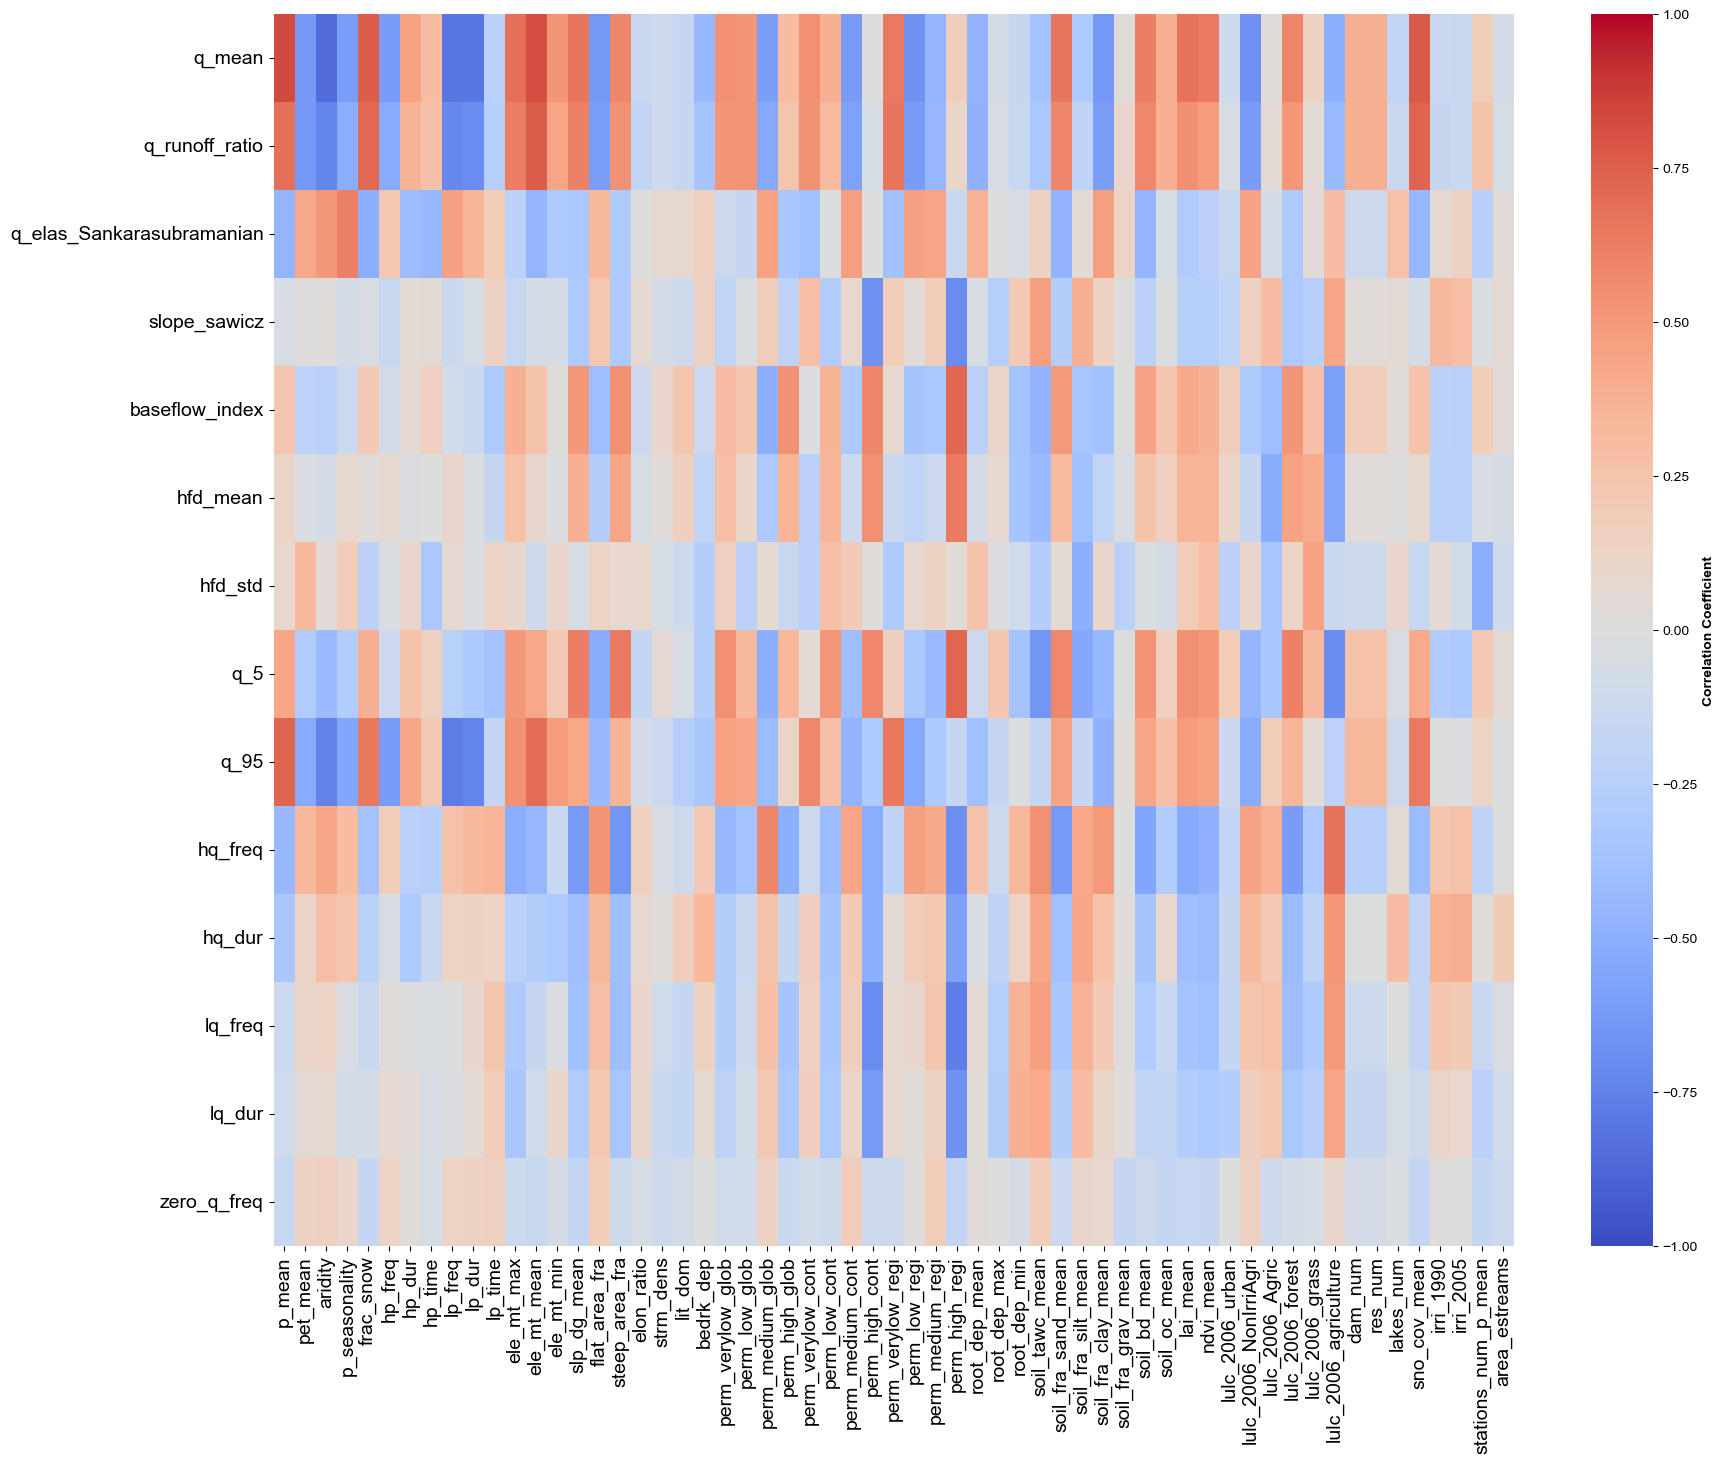

In [137]:
# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
            cbar_kws={'label': 'Correlation Coefficient'}, 
            yticklabels=combined_correlation_df.index)

#plt.title('Combined Heatmap for All Signatures', fontsize=20)
#plt.xlabel('Variables', fontsize=15)
plt.ylabel('', fontsize=15)

# Customize font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [138]:
# Group the variable features to groups
# Here we can use a dictionary to reclassifiy the variables we have to groups such as: climate, soil, geolofy
variable_dict = {
        'p_mean': 'climatic',
        'pet_mean': 'climatic',
        'aridity': 'climatic',
        'p_seasonality': 'climatic',
        'frac_snow': 'climatic',
        'hp_freq': 'climatic',
        'hp_dur': 'climatic',
        'hp_time': 'climatic',
        'lp_freq': 'climatic',
        'lp_dur': 'climatic',
        'lp_time': 'climatic',
        'ele_mt_max': 'topography',
        'ele_mt_mean': 'topography',
        'ele_mt_min': 'topography',
        'slp_dg_mean': 'topography',
        'flat_area_fra': 'topography',
        'steep_area_fra': 'topography',
        'elon_ratio': 'topography',
        'strm_dens': 'topography',
        'lit_dom': 'geology',
        'bedrk_dep': 'soil',

        'perm_verylow_glob': 'geology_low',
        'perm_low_glob': 'geology_low',
        'perm_medium_glob': 'geology_low',
        'perm_high_glob': 'geology_low',

        'root_dep_mean': 'soil',
        'root_dep_max': 'soil',
        'root_dep_min': 'soil',
        'soil_tawc_mean': 'soil',
        'soil_fra_sand_mean': 'soil',
        'soil_fra_silt_mean': 'soil',
        'soil_fra_clay_mean': 'soil',
        'soil_fra_grav_mean': 'soil',
        'soil_bd_mean': 'soil',
        'soil_oc_mean': 'soil',
        'lai_mean': 'lulc',
        'ndvi_mean': 'lulc',
        'lulc_2006_urban': 'lulc',
        'lulc_2006_NonIrriAgri': 'lulc',
        'lulc_2006_Agric': 'lulc',
        'lulc_2006_forest': 'lulc',
        'lulc_2006_grass': 'lulc',
        'lulc_2006_agriculture': 'lulc',
        'dam_num': 'hydrology',
        'res_num': 'hydrology',
        'lakes_num': 'hydrology',
        'sno_cov_mean': 'climatic',
        'irri_1990': 'hydrology',
        'irri_2005': 'hydrology',

        'perm_high_cont': 'geology_med',
        'perm_medium_cont': 'geology_med',
        'perm_low_cont': 'geology_med',
        'perm_verylow_cont': 'geology_med',

        'stations_num_p_mean': 'climatic',

        'perm_high_regi': "geology_high", 
        'perm_medium_regi': "geology_high", 
        'perm_low_regi': "geology_high",
        'perm_verylow_regi': "geology_high",
        "area_estreams": "topography"
    }

# Select the variable
signatures = ['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 
              'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq']


# Define the classes (example list, adjust based on your classes)
classes = ["climatic", "geology", "geology_low", "lulc", "soil", "topography", "vegetation", "hydrology", "geology_med", "geology_high"]

corr_max_group_dfs = pd.DataFrame(columns = signatures)

for signature in signatures:
    correlation_df = correlation_dict[signature]
    
    # Initialize the dataframe with columns for each class's maximum correlation and feature
    columns = []
    for cls in classes:
        columns.append(f"corr_max_{cls}")
        columns.append(f"corr_max_feature_{cls}")

    corr_max_group_df = pd.DataFrame(index=correlation_df.columns, columns=columns)

    # Populate the dataframe with the maximum correlations for each class
    for catchment in correlation_df.columns:
        max_corr = {cls: 0 for cls in classes}
        max_feature = {cls: None for cls in classes}

        for feature in correlation_df.index:
            cls = variable_dict[feature]
            corr_value = abs(correlation_df.loc[feature, catchment])

            if corr_value > abs(max_corr[cls]):
                max_corr[cls] = correlation_df.loc[feature, catchment]
                max_feature[cls] = feature

        for cls in classes:
            corr_max_group_df.loc[catchment, f"corr_max_{cls}"] = max_corr[cls]
            corr_max_group_df.loc[catchment, f"corr_max_feature_{cls}"] = max_feature[cls]

    # Reclassify geological classes using the mapping dictionary for each class's feature
    for cls in classes:
        corr_max_group_df[f"corr_max_feature_{cls}"] = corr_max_group_df[f"corr_max_feature_{cls}"].map(variable_dict)

    corr_max_group_df = corr_max_group_df[['corr_max_geology_low', "corr_max_geology_med", "corr_max_geology_high", 'corr_max_climatic', 
                                                      'corr_max_lulc', 'corr_max_soil', 'corr_max_topography', 
                                                      'corr_max_vegetation', 'corr_max_hydrology']]

    # Sort and add additional columns
    corr_max_group_df.iloc[:, 0:7] = corr_max_group_df.iloc[:, 0:7].astype(float)
    corr_max_group_df = corr_max_group_df.astype(float)
    corr_max_group_df = corr_max_group_df.T.iloc[0:-2]
    corr_max_group_dfs[signature] = corr_max_group_df


In [139]:
# Set font properties using rcParams
plt.rcParams['font.family'] = 'helvetica'  # Change the font family
plt.rcParams['font.size'] = 7         # Change the font size
plt.rcParams['font.weight'] = 'normal'  # Change font weight (e.g., 'bold', 'normal')
plt.rcParams['axes.labelweight'] = 'normal'  # Change label font weight (e.g., 'bold', 'normal')


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

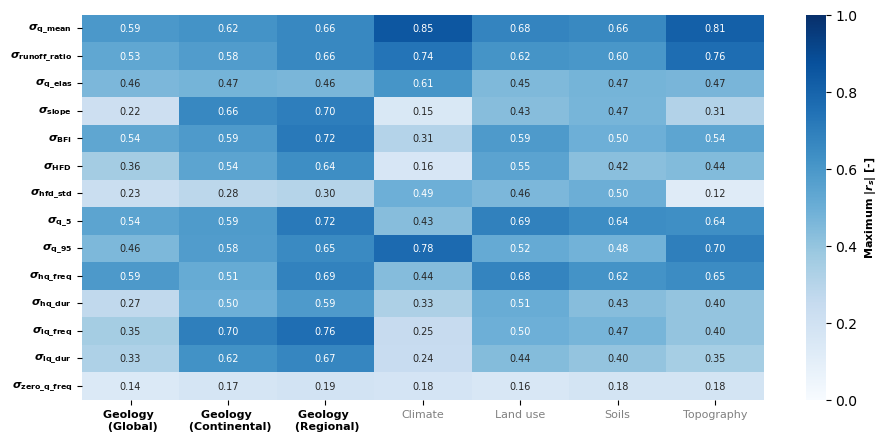

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = [ "Geology \n (Global)", "Geology \n (Continental)", "Geology \n (Regional)", "Climate", "Land use", 
                   "Soils", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['$\sigma_{\mathrm{q\_mean}}$', '$\sigma_{\mathrm{runoff\_ratio}}$', '$\sigma_{\mathrm{q\_elas}}$', 
                   '$\sigma_{\mathrm{slope}}$', '$\sigma_{\mathrm{BFI}}$', '$\sigma_{\mathrm{HFD}}$', 
                   '$\sigma_{\mathrm{hfd\_std}}$', '$\sigma_{\mathrm{q\_5}}$', '$\sigma_{\mathrm{q\_95}}$', 
                   '$\sigma_{\mathrm{hq\_freq}}$', '$\sigma_{\mathrm{hq\_dur}}$', '$\sigma_{\mathrm{lq\_freq}}$',
                   '$\sigma_{\mathrm{lq\_dur}}$', '$\sigma_{\mathrm{zero\_q\_freq}}$'
                  ]

corr_max_group_dfs_abs = corr_max_group_dfs.abs()
# Plot the heatmap
plt.figure(figsize=(11, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='Blues', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed

# Set custom x labels with different styles
for i, label in enumerate(ax.get_xticklabels()):
    if i < 3:  # First three labels
        label.set_color('black')
        label.set_fontweight('bold')
    else:  # The rest of the labels
        label.set_color('gray')
        label.set_fontweight('normal')


# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label(r'Maximum |$r_s$| [-]', fontsize=8, fontweight='bold')

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

## Figure 6

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

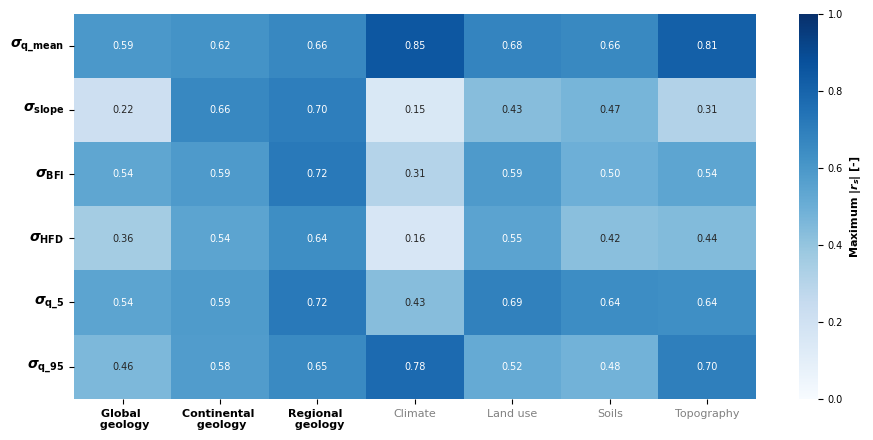

In [79]:
corr_max_group_dfs_red = corr_max_group_dfs.loc[:, ["q_mean", "slope_sawicz", "baseflow_index", 
                                                         "hfd_mean", "q_5", "q_95"]]

# Assuming corr_max_group_dfs is your DataFrame and it already contains the required data
# Create custom x labels
custom_x_labels = [ "Global \n geology", "Continental \n geology", "Regional \n geology", "Climate", "Land use", 
                   "Soils", "Topography"]  # Replace with your labels
# Create custom y labels (adjust based on your data)
custom_y_labels = ['$\sigma_{\mathrm{q\_mean}}$',  
                   '$\sigma_{\mathrm{slope}}$', '$\sigma_{\mathrm{BFI}}$', '$\sigma_{\mathrm{HFD}}$', 
                   '$\sigma_{\mathrm{q\_5}}$', '$\sigma_{\mathrm{q\_95}}$']

corr_max_group_dfs_abs = corr_max_group_dfs_red.abs()
# Plot the heatmap
fig = plt.figure(figsize=(11, 5))
ax = sns.heatmap(corr_max_group_dfs_abs.T, annot=True, cmap='Blues', fmt=".2f", vmin=0, vmax=1, alpha=1)

# Set custom x labels
ax.set_xticklabels(custom_x_labels, rotation=0, ha='center', fontsize=8, fontweight='bold')  # Adjust rotation and alignment as needed
# Set custom y labels
ax.set_yticklabels(custom_y_labels, rotation=0, ha='right', fontsize=10, fontweight='bold')  # Adjust rotation and alignment as needed

# Set custom x labels with different styles
for i, label in enumerate(ax.get_xticklabels()):
    if i < 3:  # First three labels
        label.set_color('black')
        label.set_fontweight('bold')
    else:  # The rest of the labels
        label.set_color('gray')
        label.set_fontweight('normal')


# Customize the legend label
colorbar = ax.collections[0].colorbar
colorbar.set_label(r'Maximum |$r_s$| [-]', fontsize=8, fontweight='bold')

fig.align_ylabels()

#plt.title(f'Heatmap for {signature}')
#plt.savefig(r'results\figs\fig_paper_heatmap_4.png', dpi=300, bbox_inches='tight')

plt.show()

## Appendix C

### All 6 signatures

In [ ]:
# Set global font properties
plt.rcParams.update({
    #'font.family': 'serif',            # Font family (e.g., 'sans-serif', 'serif', 'monospace')
    'font.size': 8,                  # Default font size
    'axes.titlesize': 8,             # Title font size
    'axes.labelsize': 8,             # Axis label font size
    'xtick.labelsize': 8,            # X-axis tick label font size
    'ytick.labelsize': 8,            # Y-axis tick label font size
    'legend.fontsize': 8,            # Legend font size
    'figure.titlesize': 6  ,          # Figure title font size
    'axes.titleweight': 'regular',        # Make only axis titles bold
    'font.weight': 'regular'           # Regular font for all other text
})

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

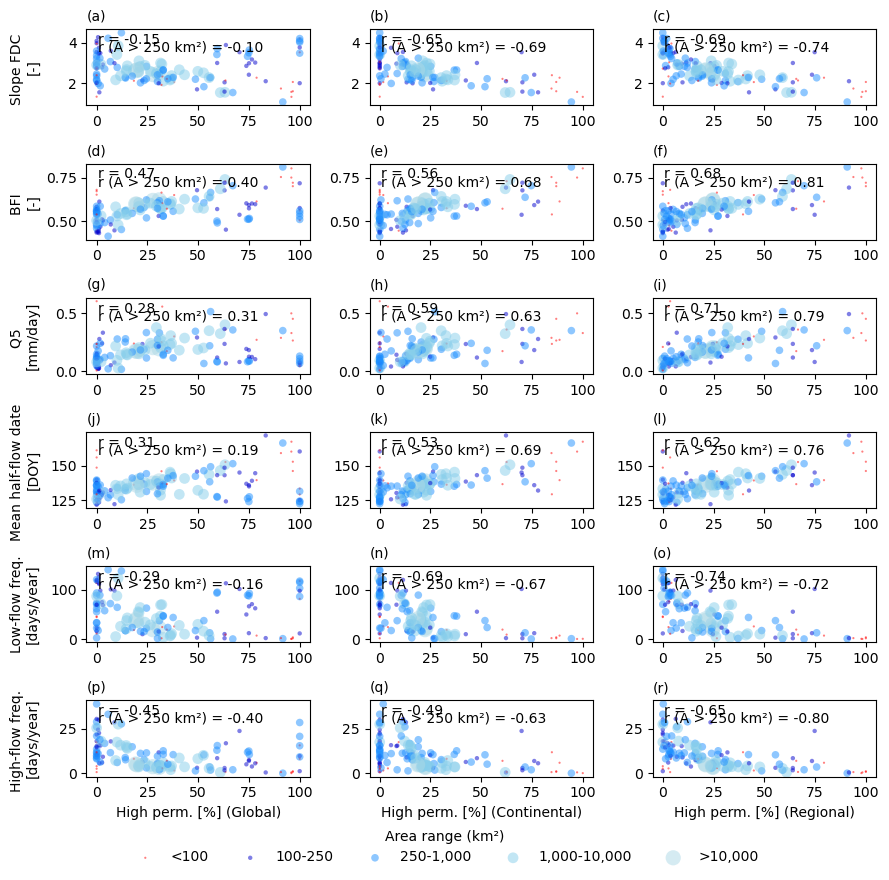

In [142]:
estreams_attributes_dfs_cat["end_date"] = estreams_attributes["end_date"] 
df = estreams_attributes_dfs["DEBU1959"]

df = estreams_attributes_dfs["DEBU1959"]
df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_glob", "perm_high_cont", "perm_high_regi"]
x_cols = ["slope_sawicz", "baseflow_index", "q_5", "hfd_mean", "lq_freq", "hq_freq"]
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'red'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["High perm. [%] (Global)", "High perm. [%] (Continental)", "High perm. [%] (Regional)"]
y_labels = ["Slope FDC \n[-]", "BFI \n[-]", "Q5 \n[mm/day]", "Mean half-flow date \n[DOY]", "Low-flow freq.\n[days/year]", "High-flow freq. \n[days/year]"]

# Create the subplots
fig, axs = plt.subplots(len(y_labels), 3, figsize=(9, 1.4*len(y_labels)))

k = 0
for j, x_col in enumerate(x_cols):
    # Loop through the y_cols to create each subplot
    for i, y_col in enumerate(y_cols):
        ax = axs[j, i]
        ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
        #ax.set_xlabel(x_labels[i])
        if i == 0:
            ax.set_ylabel(y_labels[j])

        if j == len(y_labels) - 1:
            ax.set_xlabel(x_labels[i])

        ax.set_title(f"({chr(97 + k)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
        

        # Drop NaNs and calculate Spearman correlation coefficient for all data
        non_nan_data_all = df[[y_col, x_col]].dropna()
        corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
        
        # Drop NaNs and calculate Spearman correlation coefficient for filtered data
        non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
        corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
        
        ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
        ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
        
        # Set y-axis limits
        #ax.set_ylim(0, 5)
        k = k + 1


# Create custom legend handles
handles = [
    plt.scatter([], [], s=2.5, color='red', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1,000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1,000-10,000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10,000', edgecolors='none')
]

# Add the legend below the figure
fig.legend(handles=handles, title='Area range (km²)', loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), frameon=False)


plt.tight_layout()
fig.align_ylabels()

# Display the plot
plt.show()
#fig.savefig(r'results\figs\fig_paper_combined_scatter.png', dpi=300, bbox_inches='tight')


### Only slope, BFI and Q5

In [149]:
# Set global font properties
plt.rcParams.update({
    #'font.family': 'serif',            # Font family (e.g., 'sans-serif', 'serif', 'monospace')
    'font.size': 8,                  # Default font size
    'axes.titlesize': 8,             # Title font size
    'axes.labelsize': 8,             # Axis label font size
    'xtick.labelsize': 8,            # X-axis tick label font size
    'ytick.labelsize': 8,            # Y-axis tick label font size
    'legend.fontsize': 8,            # Legend font size
    'figure.titlesize': 6  ,          # Figure title font size
    'axes.titleweight': 'regular',        # Make only axis titles bold
    'font.weight': 'regular'           # Regular font for all other text
})

In [ ]:
estreams_attributes_dfs_cat

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

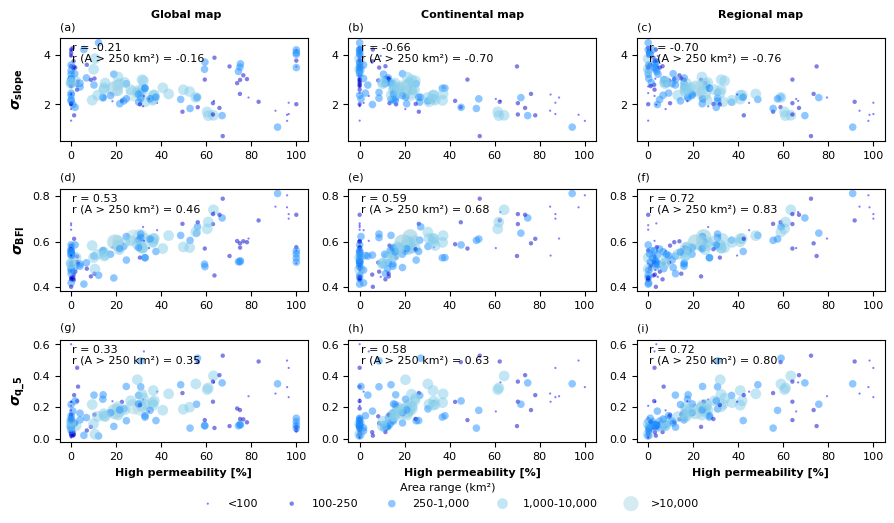

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

In [155]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

estreams_attributes_dfs_cat["end_date"] = estreams_attributes["end_date"] 
estreams_attributes_dfs_cat["area_estreams"] = estreams_attributes["area_estreams"] 
df = estreams_attributes_dfs["DEBU1959"]
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr


df = estreams_attributes_dfs["DEBU1959"]
df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "1900"]
df=df[df.slope_sawicz < 9]
# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_glob", "perm_high_cont", "perm_high_regi"]
x_cols = ["slope_sawicz", "baseflow_index", "q_5"]
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'blue'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["High permeability [%]", "High permeability [%]", "High permeability [%]"]
y_labels = ["$\sigma_{\mathrm{slope}}$", "$\sigma_{\mathrm{BFI}}$", "$\sigma_{\mathrm{q\_5}}$"]



# Create the subplots
fig, axs = plt.subplots(len(y_labels), 3, figsize=(9, 1.6*len(y_labels)))

k = 0
for j, x_col in enumerate(x_cols):
    # Loop through the y_cols to create each subplot
    for i, y_col in enumerate(y_cols):
        ax = axs[j, i]
        ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
        #ax.set_xlabel(x_labels[i])
        if i == 0:
            ax.set_ylabel(y_labels[j], fontsize=10)

        if j == len(y_labels) - 1:
            ax.set_xlabel(x_labels[i])

        ax.set_title(f"({chr(97 + k)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
        

        # Drop NaNs and calculate Spearman correlation coefficient for all data
        non_nan_data_all = df[[y_col, x_col]].dropna()
        corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
        
        # Drop NaNs and calculate Spearman correlation coefficient for filtered data
        non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
        corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
        
        ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
        ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
        
        # Set y-axis limits
        #ax.set_ylim(0, 5)
        k = k + 1


# Create custom legend handles
handles = [
    plt.scatter([], [], s=2.5, color='blue', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1,000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1,000-10,000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10,000', edgecolors='none')
]

# Add the legend below the figure
fig.legend(handles=handles, title='Area range (km²)', loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.06), frameon=False)


fig.text(0.17, 1.0, 'Global map', verticalalignment='top', fontweight="bold")
fig.text(0.47, 1.0, 'Continental map', verticalalignment='top', fontweight="bold")
fig.text(0.8, 1.0, 'Regional map', verticalalignment='top', fontweight="bold")

plt.tight_layout()
fig.align_ylabels()

# Display the plot
plt.show()
fig.savefig(r'results\figs\fig_paper_combined_scatter.png', dpi=300, bbox_inches='tight')


### Only BFI

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

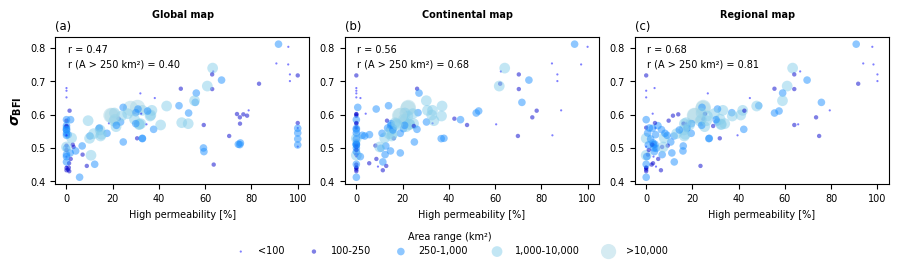

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

In [ ]:
df = estreams_attributes_dfs["DEBU1959"]
df = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date >= "2009"]

# Assuming df is your DataFrame and it already contains the required columns
y_cols = ["perm_high_glob", "perm_high_cont", "perm_high_regi"]
x_cols = ["baseflow_index"]
size_col = "area_estreams"

# Define size classes, corresponding sizes, and colors for the scatter plot
def get_size_color(area):
    if area < 100:
        return 2.5, 'blue'  # Dark Blue
    elif 100 <= area < 250:
        return 10, '#0000CD'  # Medium Blue
    elif 250 <= area < 1000:
        return 30, '#1E90FF'  # Dodger Blue
    elif 1000 <= area < 10000:
        return 60, '#87CEEB'  # Sky Blue
    else:
        return 120, '#ADD8E6'  # Light Blue

# Apply the get_size_color function to the size_col to create new columns for sizes and colors
df['scaled_size'], df['color'] = zip(*df[size_col].apply(get_size_color))

# Filter data with area > 250
df_filtered = df[df[size_col] > 250]

# Apply the get_size_color function to the size_col to create new columns for sizes and colors for the filtered data
df_filtered['scaled_size'], df_filtered['color'] = zip(*df_filtered[size_col].apply(get_size_color))

# Custom labels for each subplot's x-axis
x_labels = ["High permeability [%]", "High permeability [%]", "High permeability [%]"]
y_labels = ["$\sigma_{\mathrm{BFI}}$"]



# Create the subplots
fig, axs = plt.subplots(len(y_labels), 3, figsize=(9, 2.2*len(y_labels)))
axs = np.atleast_2d(axs)

k = 0
for j, x_col in enumerate(x_cols):
    # Loop through the y_cols to create each subplot
    for i, y_col in enumerate(y_cols):
        ax = axs[j, i]
        ax.scatter(df[y_col], df[x_col], s=df['scaled_size'], alpha=0.5, c=df['color'], edgecolors='none')
        #ax.set_xlabel(x_labels[i])
        if i == 0:
            ax.set_ylabel(y_labels[j], fontsize=10)

        if j == len(y_labels) - 1:
            ax.set_xlabel(x_labels[i])

        ax.set_title(f"({chr(97 + k)})", loc="left")  # chr(97) is 'a', chr(98) is 'b', etc.
        

        # Drop NaNs and calculate Spearman correlation coefficient for all data
        non_nan_data_all = df[[y_col, x_col]].dropna()
        corr_coef_all, _ = spearmanr(non_nan_data_all[y_col], non_nan_data_all[x_col])
        
        # Drop NaNs and calculate Spearman correlation coefficient for filtered data
        non_nan_data_filtered = df_filtered[[y_col, x_col]].dropna()
        corr_coef_filtered, _ = spearmanr(non_nan_data_filtered[y_col], non_nan_data_filtered[x_col])
        
        ax.text(0.05, 0.95, f'r = {corr_coef_all:.2f}', transform=ax.transAxes, verticalalignment='top')
        ax.text(0.05, 0.85, f'r (A > 250 km²) = {corr_coef_filtered:.2f}', transform=ax.transAxes, verticalalignment='top')
        
        # Set y-axis limits
        #ax.set_ylim(0, 5)
        k = k + 1


# Create custom legend handles
handles = [
    plt.scatter([], [], s=2.5, color='blue', alpha=0.5, label='<100', edgecolors='none'),
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.5, label='100-250', edgecolors='none'),
    plt.scatter([], [], s=30, color='#1E90FF', alpha=0.5, label='250-1,000', edgecolors='none'),
    plt.scatter([], [], s=60, color='#87CEEB', alpha=0.5, label='1,000-10,000', edgecolors='none'),
    plt.scatter([], [], s=120, color='#ADD8E6', alpha=0.5, label='>10,000', edgecolors='none')
]

# Add the legend below the figure
fig.legend(handles=handles, title='Area range (km²)', loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.16), frameon=False)


fig.text(0.17, 1.0, 'Global map', verticalalignment='top', fontweight="bold")
fig.text(0.47, 1.0, 'Continental map', verticalalignment='top', fontweight="bold")
fig.text(0.8, 1.0, 'Regional map', verticalalignment='top', fontweight="bold")

plt.tight_layout()
fig.align_ylabels()

# Display the plot
plt.show()
fig.savefig(r'results\figs\fig_paper_combined_scatter_BFIonly.png', dpi=300, bbox_inches='tight')


# Small scale analysis: Moselle Subcatchments 

In [103]:
# Filter the catchments in Moselle
cats_moselle = estreams_attributes_dfs["DEBU1959"][estreams_attributes_dfs["DEBU1959"].end_date >= "1900"].index.tolist()
len(cats_moselle)

152

In [104]:
# Filter only the Moselle catchments
estreams_attributes_moselle = estreams_attributes.loc[cats_moselle, :]
estreams_attributes_moselle

gauge_id     gauge_name gauge_country  gauge_provider      river  \
basin_id                                                                     
BEWA0066  99141002        Reuland            BE          BE_SPW        Our   
BEWA0067  99261002     Schoenberg            BE          BE_SPW        Our   
BEWA0087  56100000     Martelange            BE          BE_SPW       Sure   
BEWA0106  60800000        Reuland            BE          BE_SPW        Ulf   
BEWA0107  60900000  Lommersweiler            BE          BE_SPW  Braunlauf   
...            ...            ...           ...             ...        ...   
LU000015        34       Michelau            LU  LU_CONTACTFORM       Sure   
LU000016         3    Pfaffenthal            LU  LU_CONTACTFORM    Alzette   
LU000017        16        Rosport            LU  LU_CONTACTFORM       Sure   
LU000018         5     Schoenfels            LU  LU_CONTACTFORM      Mamer   
LU000019        12        Vianden            LU  LU_CONTACTFORM        Our   

          lon_snap   lat_snap       lon        lat elevation  ...  \
basin_id                                                      ...   
BEWA0066  6.151802  50.188258  6.151802  50.188258       NaN  ...   
BEWA0067  6.263467  50.289277  6.263467  50.289277       NaN  ...   
BEWA0087  5.739269  49.833704  5.739269  49.833704       NaN  ...   
BEWA0106  6.150669  50.196522  6.150669  50.196522       NaN  ...   
BEWA0107  6.153292  50.235014  6.153955  50.234494       NaN  ...   
...            ...        ...       ...        ...       ...  ...   
LU000015  6.091178  49.895421  6.091178  49.895421       NaN  ...   
LU000016  6.132266  49.620647  6.132266  49.620647       NaN  ...   
LU000017  6.509851  49.785883  6.509851  49.785883       NaN  ...   
LU000018  6.100795  49.723112  6.100795  49.723112       NaN  ...   
LU000019  6.204738  49.939224  6.204738  49.939224       NaN  ...   

          lakes_tot_area  lakes_tot_vol  sno_cov_mean  irri_1990 irri_2005  \
basin_id                                                                     
BEWA0066            0.00           0.00         7.497      1.400     3.429   
BEWA0067            0.00           0.00         8.920      0.000     0.075   
BEWA0087            0.00           0.00         6.106      0.000     0.000   
BEWA0106            0.00           0.00         7.096      1.200     2.427   
BEWA0107            0.00           0.00         6.996      0.200     0.605   
...                  ...            ...           ...        ...       ...   
LU000015            1.80          62.62         5.680      0.045     0.045   
LU000016            0.00           0.00         2.863      0.004     0.009   
LU000017            2.67          67.85         4.753      1.641     4.770   
LU000018            0.00           0.00         3.184      0.015     0.015   
LU000019            0.00           0.00         6.627      1.495     3.524   

         stations_num_p_mean  perm_high_regi  perm_medium_regi  perm_low_regi  \
basin_id                                                                        
BEWA0066                16.0        2.947531          0.000000       3.319025   
BEWA0067                 8.0        2.347625          0.000000       0.000000   
BEWA0087                 6.0        0.005000          0.000000       0.000000   
BEWA0106                 9.0        0.000000          0.000000       0.000000   
BEWA0107                 6.0        3.999021          0.000000      15.492765   
...                      ...             ...               ...            ...   
LU000015                25.0        1.917023          0.000000       0.000000   
LU000016                15.0       14.327884         32.255374      53.416742   
LU000017                78.0       18.753136          5.872553      24.977481   
LU000018                17.0       39.499138          0.000000      60.500862   
LU000019                27.0        3.530352          2.493791       1.855134   

          perm_verylow_regi 

In [105]:
# First we filter the potential watersheds:
list_cats_moselle = estreams_attributes_moselle[estreams_attributes_moselle.gauges_upstream <= 60][estreams_attributes_moselle.gauges_upstream >= 10].sort_values(by='gauges_upstream', ascending=True)["gauges_upstream"].index.tolist()

# Here we filter the list of nested_catchments according to this first filter:
nested_cats_moselle_df = nested_catchments.loc[list_cats_moselle, :]

print("Number of catchemnts with potentially nested catchments:", len(list_cats_moselle))

Number of catchemnts with potentially nested catchments: 22


In [106]:
# Filter only the catchemnts using the function stated before (unique headwaters):
nested_cats_moselle_filtered = find_unique_nested_catchments(nested_cats_moselle_df)
print(nested_cats_moselle_filtered)

['FR003283', 'FR003249', 'FR000159', 'LU000017', 'DEBU1957']


In [107]:
# Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_moselle_df = nested_catchments.loc[nested_cats_moselle_filtered, :]

In [108]:
# Store the variables for the selected catchments in a list of dataframes:
estreams_attributes_headwaters_moselle_dfs = {}

for catchment in tqdm.tqdm(nested_cats_moselle_filtered):

    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_moselle_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes_moselle.index]

    cat_clip = estreams_attributes.loc[nested_clip, :]

    estreams_attributes_headwaters_moselle_dfs[catchment] = cat_clip

100%|██████████| 5/5 [00:00<00:00, 546.87it/s]


In [109]:
# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens_moselle = pd.DataFrame(index = estreams_attributes_headwaters_moselle_dfs.keys())
for catchment, data in estreams_attributes_headwaters_moselle_dfs.items():
    catchment_lens_moselle.loc[catchment, "len"] = len(data)

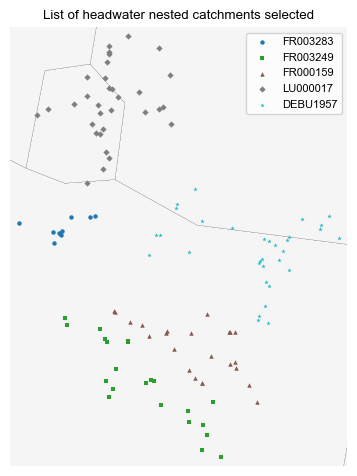

In [110]:
# Create subplots
fig, axes = plt.subplots()
# Flatten the axes array

plot_watershed_groups_from_dict(estreams_attributes_used = estreams_attributes_headwaters_moselle_dfs, figsize=(8, 6), ax=axes, 
                      title_plot='List of headwater nested catchments selected', add_legend = True, size_symbol = 10, 
                               limits_europe = False)

In [111]:
# List of keys to filter
keys_to_filter = estreams_attributes_headwaters_moselle_dfs.keys()

# Initialize an empty list to store the DataFrames
filtered_dfs_list = []

# Iterate through the list of keys and append each DataFrame to the list
for key in keys_to_filter:
    if key in estreams_attributes_headwaters_moselle_dfs:
        df = estreams_attributes_headwaters_moselle_dfs[key].copy()  # Get the DataFrame
        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
        filtered_dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(filtered_dfs_list, ignore_index=True)
combined_df

gauge_id                              gauge_name gauge_country  \
0    A812200001                                A8122000            FR   
1    A818201001                                A8182010            FR   
2    A802101001                        L'Orne Ã  Ã‰tain            FR   
3    A807101001                      L'Orne Ã  Boncourt            FR   
4    A812020101           L'Yron Ã  Jarny [Droitaumont]            FR   
..          ...                                     ...           ...   
116  A961205050                 La Bisten Ã  Creutzwald            FR   
117  A986201001             La Nied Allemande Ã  Varize            FR   
118  A994202001  La Nied Ã  Bouzonville et Ã  Filstroff            FR   
119  A994202002  La Nied Ã  Bouzonville et Ã  Filstroff            FR   
120    26400550                  BundespegelFremersdorf            DE   

    gauge_provider                                 river  lon_snap   lat_snap  \
0     FR_EAUFRANCE         L'Yron à Hannonville-Suzémont  5.837081  49.098776   
1     FR_EAUFRANCE      L'Yron à Jarny [La Cartoucherie]  5.862013  49.156008   
2     FR_EAUFRANCE                        L'Orne à Étain  5.632484  49.213610   
3     FR_EAUFRANCE                     L'Orne à Boncourt  5.830467  49.162566   
4     FR_EAUFRANCE          L'Yron à Jarny [Droitaumont]  5.876081  49.142330   
..             ...                                   ...       ...        ...   
116   FR_EAUFRANCE                La Bisten à Creutzwald  6.688894  49.225799   
117   FR_EAUFRANCE            La Nied Allemande à Varize  6.446071  49.142442   
118   FR_EAUFRANCE  La Nied à Bouzonville et à Filstroff  6.545267  49.324381   
119   FR_EAUFRANCE  La Nied à Bouzonville et à Filstroff  6.539043  49.301285   
120          DE_BU                                  Saar  6.648000  49.409000   

          lon        lat elevation  ...  lakes_tot_vol  sno_cov_mean  \
0    5.837081  49.098776       197  ...           3.61         2.131   
1    5.862013  49.156008       187  ...           3.61         2.226   
2    5.632484  49.213610       199  ...           1.10         2.101   
3    5.830467  49.162566       185  ...           1.40         2.060   
4    5.876081  49.142330       188  ...           3.61         2.167   
..        ...        ...       ...  ...            ...           ...   
116  6.688894  49.225799       201  ...           0.50         2.452   
117  6.446071  49.142442       204  ...           1.62         2.903   
118  6.545267  49.324381       189  ...           4.50         2.726   
119  6.539043  49.301285       189  ...           4.50         2.727   
120  6.648000  49.409000       NaN  ...         114.90         3.185   

     irri_1990  irri_2005 stations_num_p_mean perm_high_regi  \
0        0.070      0.040                 2.0       0.000000   
1        0.274      0.137                 4.0       0.000000   
2        0.089      0.032                 1.0       0.000000   
3        0.638      0.190                 3.0       0.000000   
4        0.083      0.065                 2.0       0.000000   
..         ...        ...                 ...            ...   
116      0.000      0.000                 2.0      93.860251   
117      0.040      0.052                 4.0       4.353730   
118      0.117      0.157                 8.0       7.308442   
119      0.117      0.157                 8.0       7.432438   
120      4.261      3.796               103.0      33.169048   

     perm_medium_regi  perm_low_regi  perm_verylow_regi       key  
0           49.984663      50.015337           0.000000  FR003283  
1           39.668363      60.331637           0.000000  FR003283  
2           28.814132      71.185868           0.000000  FR003283  
3           30.090776      69.909224           0.000000  FR003283  
4           57.507079      42.492921           0.000000  FR003283  
..                ...            ...                ...       ...  
116          2.539723       3.600025           

In [112]:
for outlet in estreams_attributes_headwaters_moselle_dfs.keys():
    print(outlet)
    print(estreams_attributes.loc[outlet, "area_estreams"])
    print(len(estreams_attributes_headwaters_moselle_dfs[outlet]))

FR003283
1241.962
9
FR003249
3396.832
25
FR000159
2882.865
23
LU000017
4255.524
32
DEBU1957
6970.0
32


## Figure 8: Heatmaps for the 5 Moselle sub-catchments

In [113]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict_hw_moselle = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_headwaters_moselle_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_headwaters_moselle_dfs[catchment]
        
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep', 
       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       "perm_verylow_regi", "perm_low_regi", "perm_medium_regi", "perm_high_regi",
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict_hw_moselle[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict_hw_moselle.keys())

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 22.77it/s]

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


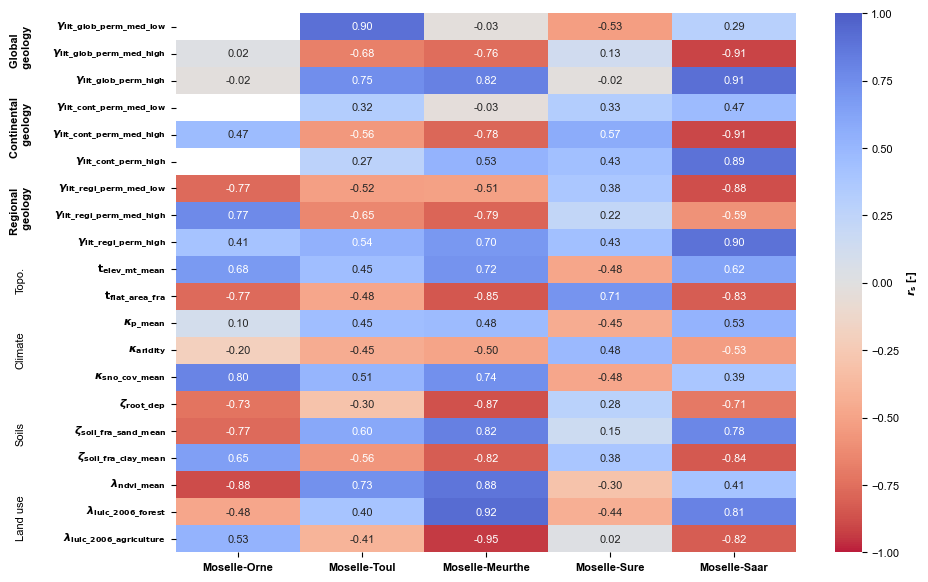

In [114]:
# baseflow_index correlations:
signature = "baseflow_index"

y_labels = ["$\gamma_{\mathrm{lit\_glob\_perm\_med\_low}}$", "$\gamma_{\mathrm{lit\_glob\_perm\_med\_high}}$", "$\gamma_{\mathrm{lit\_glob\_perm\_high}}$",
            "$\gamma_{\mathrm{lit\_cont\_perm\_med\_low}}$", "$\gamma_{\mathrm{lit\_cont\_perm\_med\_high}}$", "$\gamma_{\mathrm{lit\_cont\_perm\_high}}$",
            "$\gamma_{\mathrm{lit\_regi\_perm\_med\_low}}$", "$\gamma_{\mathrm{lit\_regi\_perm\_med\_high}}$", "$\gamma_{\mathrm{lit\_regi\_perm\_high}}$",
            "$\mathrm{t}_{\mathrm{elev\_mt\_mean}}$", 
            "$\mathrm{t}_{\mathrm{flat\_area\_fra}}$",
            "$\kappa_{\mathrm{p\_mean}}$","$\kappa_{\mathrm{aridity}}$",   
            "$\kappa_{\mathrm{sno\_cov\_mean}}$", 
            "$\zeta_{\mathrm{root\_dep}}$", "$\zeta_{\mathrm{soil\_fra\_sand\_mean}}$", "$\zeta_{\mathrm{soil\_fra\_clay\_mean}}$", 
            "$\lambda_{\mathrm{ndvi\_mean}}$", "$\lambda_{\mathrm{lulc\_2006\_forest}}$", "$\lambda_{\mathrm{lulc\_2006\_agriculture}}$" 
            ]

# Desired order of indices
desired_order = ['perm_low_glob', 'perm_medium_glob', 'perm_high_glob',
                 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
                 'perm_low_regi','perm_medium_regi', 'perm_high_regi',
                 
                 'ele_mt_mean', 
                 'flat_area_fra', 
                 'p_mean','aridity',  'sno_cov_mean', 
                 'root_dep_mean', 'soil_fra_sand_mean', 'soil_fra_clay_mean', 
                 'ndvi_mean', 'lulc_2006_forest', 'lulc_2006_agriculture', 

                 ]

# Correlation DataFrame (assuming this is already prepared)
correlation_df = correlation_dict_hw_moselle[signature].loc[desired_order, :]

# Plot the heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(correlation_df, annot=True, cmap='coolwarm_r', fmt=".2f", vmin=-1, vmax=1, alpha=0.9)

labels_x = ["Moselle-Orne", "Moselle-Toul", "Moselle-Meurthe", "Moselle-Sure", "Moselle-Saar"]
# Set the x and y tick labels
ax.set_xticklabels(labels_x, rotation=0, ha='center', fontsize=8, fontweight="bold")
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Customize the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_label('$r_{\mathregular{s}}$ [-]', fontsize=8)

# Set custom colors for specific labels
for label in ax.get_yticklabels():
    text = label.get_text()
    if 'global' in text:
        label.set_color('black')  # Color for 'global'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'euro' in text:
        label.set_color('black')  # Color for 'euro'
        label.set_fontweight('normal')  # Bold for 'global'

    elif 'country' in text:
        label.set_color('black')  # Color for 'country'
        label.set_fontweight('bold')  # Bold for 'global'


# Ensure y-labels are set before applying styles
ax.set_yticklabels(y_labels, rotation=0, ha='right', fontsize=8)

# Apply bold to the first six rows explicitly
for i, label in enumerate(ax.get_yticklabels()):
    if i < 6:  # First 6 rows
        label.set_fontweight('bold')



# Adding text outside the plot for section titles
plt.text(-0.03, 0.83, 'Global \n geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.72, 'Continental \n geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.60, 'Regional \n geology', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="bold")
plt.text(-0.03, 0.50, 'Topo.', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="normal")
plt.text(-0.03, 0.40, 'Climate', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="normal")
plt.text(-0.03, 0.28, 'Soils', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="normal")
plt.text(-0.03, 0.16, 'Land use', va='center', ha='center', rotation=90, fontsize=8, transform=plt.gcf().transFigure, fontweight="normal")

# Save the figure
plt.savefig(r'results\figs\fig_heatmap_headwaters_bfi_reduced.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Supporting information: Boxplots for sub-catchments

In [59]:
def plot_boxplots_for_columns(data_dict, columns, n_cols=5):
    """
    Plots boxplots for a list of columns against multiple DataFrames.

    Parameters:
    data_dict (dict): Dictionary containing DataFrames.
    columns (list of str): List of column names to create boxplots for.
    n_cols (int, optional): Number of columns in the subplot grid. Default is 5.
    """
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))

    for idx, column in enumerate(columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        combined_df = pd.concat(
            [df[[column]].assign(DataFrame=name) for name, df in data_dict.items()],
            axis=0
        )

        sns.boxplot(x='DataFrame', y=column, data=combined_df, ax=ax)
        ax.set_xlabel('DataFrame')
        ax.set_ylabel(column)
        ax.set_title(f'Boxplot of {column}')
    
    # Remove empty subplots
    for idx in range(len(columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])
        
    plt.tight_layout()
    plt.show()

In [60]:
for key, df in estreams_attributes_headwaters_moselle_dfs.items():
    df['range_elev'] = df['ele_mt_max'] - df['ele_mt_min']
    df['perm_low'] = df['perm_low_regi'] + df['perm_verylow_regi']
    df['perm_high'] = df['perm_medium_regi'] + df['perm_high_regi']

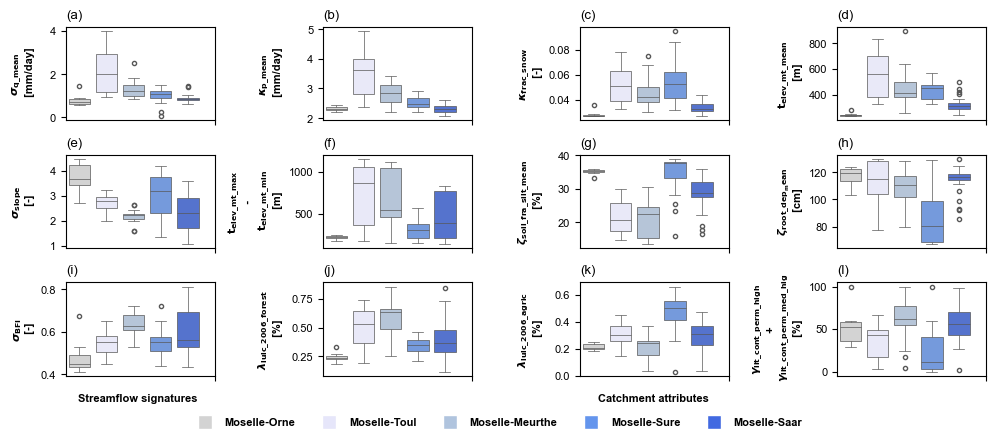

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of columns to plot
columns = ["q_mean", "p_mean",  "frac_snow", "ele_mt_mean",
           "slope_sawicz", "range_elev", "soil_fra_silt_mean", "root_dep_mean", 
           'baseflow_index', "lulc_2006_forest", "lulc_2006_Agric", "perm_high"]





# Define custom y-labels for each plot (you can customize this list)
y_labels = ["$\sigma_{\mathrm{q\_mean}}$ \n [mm/day]", "$\kappa_{\mathrm{p\_mean}}$ \n [mm/day]", "$\kappa_{\mathrm{frac\_snow}}$ \n [-]", "$\mathrm{t}_{\mathrm{elev\_mt\_mean}}$ \n [m]",
            "$\sigma_{\mathrm{slope}}$ \n [-]", "$\mathrm{t}_{\mathrm{elev\_mt\_max}}$ \n - \n $\mathrm{t}_{\mathrm{elev\_mt\_min}}$ \n [m]", "$\zeta_{\mathrm{soil\_fra\_silt\_mean}}$ \n [%]", "$\zeta_{\mathrm{root\_dep_mean}}$ \n [cm]",
            "$\sigma_{\mathrm{BFI}}$ \n [-]", "$\lambda_{\mathrm{lulc\_2006\_forest}}$ \n [%]", "$\lambda_{\mathrm{lulc\_2006\_agric}}$ \n [%]", "$\gamma_{\mathrm{lit\_cont\_perm\_high}}$ \n + \n $\gamma_{\mathrm{lit\_cont\_perm\_med\_hig}}$\n [%]"
            ]

# Number of columns in the grid
n_cols = 4
data_dict = estreams_attributes_headwaters_moselle_dfs

# Number of rows and columns for subplots
n_rows = (len(columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))

# Define custom colors for each DataFrame
custom_colors = {
    'FR003283': 'lightgray',
    'FR003249': 'lavender',
    'FR000159': 'lightsteelblue',
    'LU000017': 'cornflowerblue',
    "DEBU1957": "royalblue"
}

# Titles with (a), (b), (c), etc.
subplot_titles = [f"({chr(97 + i)})" for i in range(len(columns))]
# Set the properties for the outliers
flierprops = dict(marker='o', color='black', markersize=3)

for idx, column in enumerate(columns):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    # Combine the DataFrames into one for plotting
    combined_df = pd.concat(
        [df[[column]].assign(DataFrame=name) for name, df in data_dict.items()],
        axis=0
    )

    # Create the boxplot with custom colors for each DataFrame
    sns.boxplot(x='DataFrame', y=column, data=combined_df, ax=ax, palette=custom_colors, linewidth=0.5,  # No edge colors
                flierprops=flierprops  # Set smaller outliers
               )
    
    ax.set_xticks('')
    ax.set_xlabel('')
    ax.set_ylabel(y_labels[idx])
    ax.set_title(subplot_titles[idx], loc="left")

# Remove any empty subplots
for idx in range(len(columns), n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])
custom_names = ["Moselle-Orne", "Moselle-Toul", "Moselle-Meurthe", "Moselle-Sure", "Moselle-Saar"]

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=name) 
        for name, color in zip(custom_names, custom_colors.values())]

# Add the legend below the plot, horizontal, in one single line
fig.legend(handles=handles, title='', loc='lower center', bbox_to_anchor=(0.5, -0.1), 
           ncol=len(custom_colors), frameon=False, prop={'weight': 'bold'})  # Set the title to bold

fig.align_ylabels()


fig.text(0.08, 0.01, 'Streamflow signatures', verticalalignment='top', fontweight="bold")
fig.text(0.6, 0.01, 'Catchment attributes', verticalalignment='top', fontweight="bold")

plt.tight_layout(rect=[0, 0.01, 1, 1])  # Adjust layout to make space for the legend


fig.savefig(r'results\figs\fig_boxplots.png', dpi=300, bbox_inches='tight')


plt.show()


## Supporting information: Different geology permeabilitites in the Moselle graphs

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

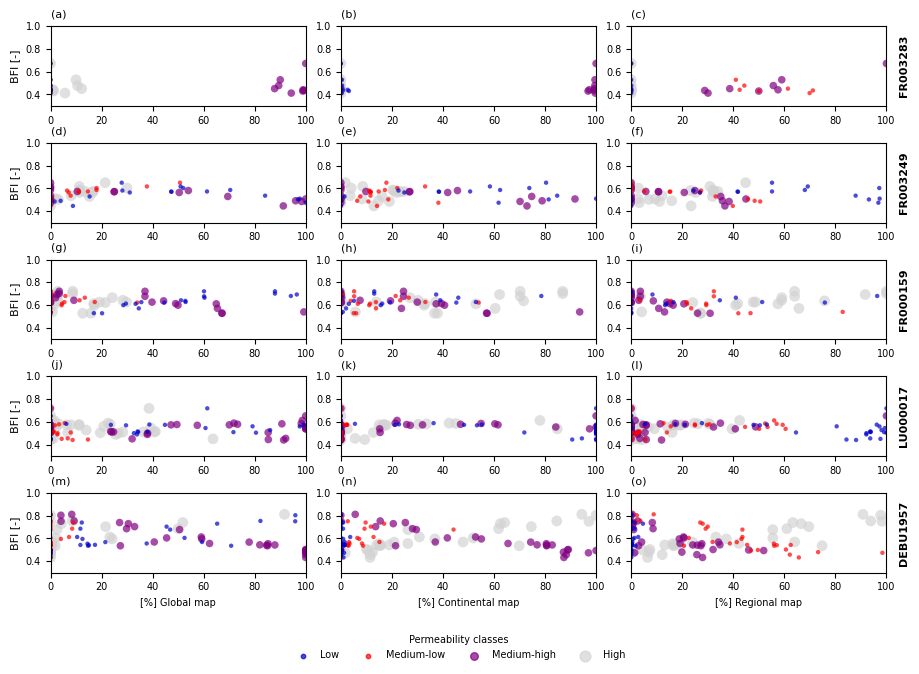

In [524]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib.ticker as ticker

# Assuming df is your DataFrame and already contains the required columns
x_col = "baseflow_index"
y_cols_c = ['perm_high_regi', "perm_medium_regi", 'perm_low_regi', "perm_verylow_regi"]
y_cols_b = ['perm_high_cont', "perm_medium_cont", 'perm_low_cont', "perm_verylow_cont"]
y_cols_a = ["perm_high_glob", "perm_medium_glob", 'perm_low_glob', "perm_verylow_glob"]

# Define a mapping of columns to colors and sizes (keeping the previous colors and sizes)
category_colors = {
    "perm_high_regi": 'lightgray',
    "perm_medium_regi": 'purple',
    "perm_low_regi": 'red',
    "perm_verylow_regi": '#0000CD',
    "perm_medium_cont": 'purple',
    "perm_high_cont": 'lightgray',
    "perm_low_cont": 'red',
    "perm_verylow_cont": '#0000CD',
    "perm_high_glob": 'lightgray',
    "perm_medium_glob": 'purple',
    "perm_low_glob": 'red',
    "perm_verylow_glob": '#0000CD'
}

category_sizes = {
    "perm_high_regi": 60,
    "perm_medium_regi": 30,
    "perm_low_regi": 10,
    "perm_verylow_regi": 10,
    "perm_medium_cont": 30,
    "perm_high_cont": 60,
    "perm_low_cont": 10,
    "perm_verylow_cont": 10,
    "perm_high_glob": 60,
    "perm_medium_glob": 30,
    "perm_low_glob": 10,
    "perm_verylow_glob": 10
}

# Create the subplots (3 columns, 5 rows)
fig, axs = plt.subplots(5, 3, figsize=(9, 6))  # Adjust the figure size accordingly

# Adjust the layout to remove vertical spacing
plt.subplots_adjust(hspace=0, wspace=0)  # Set vertical space (hspace) to 0, adjust wspace as needed
# Define columns for each subplot
y_cols_list = [y_cols_a, y_cols_b, y_cols_c]
sub_basin_list = ["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"]

j = 0
# Loop through the subplots and columns to create the scatter plots for each sub-basin
for row, sub_basin in enumerate(sub_basin_list):
    df = estreams_attributes_headwaters_moselle_dfs[sub_basin]
    for i, (ax, y_cols) in enumerate(zip(axs[row, :], y_cols_list)):
        for y_col in y_cols:
            ax.scatter(df[y_col], df[x_col], 
                       s=category_sizes[y_col], 
                       alpha=0.7, 
                       c=category_colors[y_col], 
                       edgecolors='none', 
                       label=y_col)
        
        ax.set_title(f"({chr(97 + j)})", loc="left", fontsize=8)
        j = j + 1 

        if i == 0:
            ax.set_ylabel('BFI [-]', fontsize=8)
            # Add vertical text outside the axes
        ax.set_ylim(0.3, 1)
        ax.set_xlim(0, 100)
        # Format the y-axis to display with one decimal place ('.1f')
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))


        if j >= 13:
            # Custom labels for each subplot's x-axis
            x_labels = ["[%] Global map", "[%] Continental map", "[%] Regional map"]
            ax.set_xlabel(x_labels[i])

    ax.text(1.05, 0.5, f'{sub_basin}', 
            transform=ax.transAxes, verticalalignment='center', fontsize=8, 
            rotation=90,  # Rotate the text vertically
            ha='left',
            fontweight='bold')  # Adjust the horizontal alignment to position it outside


# Add legend at the bottom
handles = [
    plt.scatter([], [], s=10, color='#0000CD', alpha=0.7, label='Low'),
    plt.scatter([], [], s=10, color='red', alpha=0.7, label='Medium-low'),
    plt.scatter([], [], s=30, color='purple', alpha=0.7, label='Medium-high'),
    plt.scatter([], [], s=60, color='lightgray', alpha=0.7, label='High')
]

fig.legend(handles=handles, title='Permeability classes', frameon=False, loc='lower center', 
           bbox_to_anchor=(0.5, -0.1), ncol=4)


# Adjust layout
plt.tight_layout(pad=0.1)

# Save the plot
#fig.savefig(r'results\figs\\fig_paper_scatter_geology_combined.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Figure 7 and supporting information: Maps with Colorfull histograms

In [196]:
# List of keys to filter
keys_to_filter = estreams_attributes_dfs.keys()

# Initialize an empty list to store the DataFrames
filtered_dfs_list = []

# Iterate through the list of keys and append each DataFrame to the list
for key in keys_to_filter:
    if key in estreams_attributes_dfs:
        df = estreams_attributes_dfs[key].copy()  # Get the DataFrame
        df['key'] = key  # Add the key as a column to keep track of the original DataFrame
        filtered_dfs_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(filtered_dfs_list, ignore_index=False)

network_estreams_filtered = combined_df.copy()
#network_estreams_filtered = network_estreams_filtered[network_estreams_filtered.end_date >= "2009"]
network_estreams_filtered

gauge_id     gauge_name gauge_country  gauge_provider      river  \
basin_id                                                                     
BEWA0066  99141002        Reuland            BE          BE_SPW        Our   
BEWA0067  99261002     Schoenberg            BE          BE_SPW        Our   
BEWA0087  56100000     Martelange            BE          BE_SPW       Sure   
BEWA0106  60800000        Reuland            BE          BE_SPW        Ulf   
BEWA0107  60900000  Lommersweiler            BE          BE_SPW  Braunlauf   
...            ...            ...           ...             ...        ...   
LU000015        34       Michelau            LU  LU_CONTACTFORM       Sure   
LU000016         3    Pfaffenthal            LU  LU_CONTACTFORM    Alzette   
LU000017        16        Rosport            LU  LU_CONTACTFORM       Sure   
LU000018         5     Schoenfels            LU  LU_CONTACTFORM      Mamer   
LU000019        12        Vianden            LU  LU_CONTACTFORM        Our   

          lon_snap   lat_snap       lon        lat elevation  ...  \
basin_id                                                      ...   
BEWA0066  6.151802  50.188258  6.151802  50.188258       NaN  ...   
BEWA0067  6.263467  50.289277  6.263467  50.289277       NaN  ...   
BEWA0087  5.739269  49.833704  5.739269  49.833704       NaN  ...   
BEWA0106  6.150669  50.196522  6.150669  50.196522       NaN  ...   
BEWA0107  6.153292  50.235014  6.153955  50.234494       NaN  ...   
...            ...        ...       ...        ...       ...  ...   
LU000015  6.091178  49.895421  6.091178  49.895421       NaN  ...   
LU000016  6.132266  49.620647  6.132266  49.620647       NaN  ...   
LU000017  6.509851  49.785883  6.509851  49.785883       NaN  ...   
LU000018  6.100795  49.723112  6.100795  49.723112       NaN  ...   
LU000019  6.204738  49.939224  6.204738  49.939224       NaN  ...   

          lakes_tot_vol  sno_cov_mean  irri_1990  irri_2005  \
basin_id                                                      
BEWA0066           0.00         7.497      1.400      3.429   
BEWA0067           0.00         8.920      0.000      0.075   
BEWA0087           0.00         6.106      0.000      0.000   
BEWA0106           0.00         7.096      1.200      2.427   
BEWA0107           0.00         6.996      0.200      0.605   
...                 ...           ...        ...        ...   
LU000015          62.62         5.680      0.045      0.045   
LU000016           0.00         2.863      0.004      0.009   
LU000017          67.85         4.753      1.641      4.770   
LU000018           0.00         3.184      0.015      0.015   
LU000019           0.00         6.627      1.495      3.524   

         stations_num_p_mean perm_high_regi  perm_medium_regi  perm_low_regi  \
basin_id                                                                       
BEWA0066                16.0       2.947531          0.000000       3.319025   
BEWA0067                 8.0       2.347625          0.000000       0.000000   
BEWA0087                 6.0       0.005000          0.000000       0.000000   
BEWA0106                 9.0       0.000000          0.000000       0.000000   
BEWA0107                 6.0       3.999021          0.000000      15.492765   
...                      ...            ...               ...            ...   
LU000015                25.0       1.917023          0.000000       0.000000   
LU000016                15.0      14.327884         32.255374      53.416742   
LU000017                78.0      18.753136          5.872553      24.977481   
LU000018                17.0      39.499138          0.000000      60.500862   
LU000019                27.0       3.530352          2.493791       1.855134   

          perm_verylow_regi       key  
basin_id                               
BEWA0066          93.733444  DEBU1959  
BEWA0067          97.652375  DEBU1959  
BEWA0087          99.995000  DEBU1959  
BEWA0106         100.000000  DEBU195

In [207]:
color_categories_range_df = network_estreams_filtered.copy()

# Defining the colour categories and mapping lists
color_categories_q_mean = [(color_categories_range_df.q_mean.min(), 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, np.inf)]
color_categories_q_runoff_ratio = [(color_categories_range_df.q_runoff_ratio.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_q_elas_Sankarasubramanian = [(0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, np.inf)]
color_categories_slope_sawicz = [(-np.inf, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.0), (3.0, np.inf)]
color_categories_baseflow_index = [(0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_hfd_mean = [(color_categories_range_df.hfd_mean.min(), 130), (130, 140), (140, 150), (150, 160), (160, np.inf)]
color_categories_q_5 = [(color_categories_range_df.q_5.min(), 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, np.inf)]
color_categories_q_95 = [(color_categories_range_df.q_95.min(), 2.0), (2.0, 4.0), (4.0, 6.0), (6.0, 8.0), (8.0, np.inf)]
color_categories_hq_freq = [(color_categories_range_df.hq_freq.min(), 10), (10, 15), (15, 20), (20, 25), (25, np.inf)]
color_categories_hq_dur = [(color_categories_range_df.hq_dur.min(), 2), (2, 3), (3, 4), (4, 5), (5, np.inf)]
color_categories_lq_freq = [(color_categories_range_df.lq_freq.min(), 25), (25, 50), (50, 75), (75, 100), (100, np.inf)]
color_categories_lq_dur = [(color_categories_range_df.lq_dur.min(), 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
color_categories_p_mean = [(color_categories_range_df.p_mean.min(), 2.5), (2.5, 3.0), (3, 3.5), (3.5, 4), (4, np.inf)]
color_categories_pet_mean = [(1.7, 1.8), (1.8, 1.9), (1.9, 2.0), (2.0, 2.1), (2.1, np.inf)]
color_categories_aridity = [(color_categories_range_df.aridity.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_p_seasonality = [(color_categories_range_df.p_seasonality.min(), -0.2), (-0.2, -0.1), (-0.1, 0), (0, 0.1), (0.1, np.inf)]
color_categories_frac_snow = [(color_categories_range_df.frac_snow.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_hp_freq = [(color_categories_range_df.hp_freq.min(), 14), (14, 15), (15, 16), (16, 17), (17, np.inf)]
color_categories_hp_dur = [(color_categories_range_df.hp_dur.min(), 1.16), (1.16, 1.18), (1.18, 1.2), (1.2, 1.22), (1.22, np.inf)]
color_categories_lp_freq = [(color_categories_range_df.lp_freq.min(), 205), (205, 210), (210,215), (215, 220), (220, np.inf)]
color_categories_lp_dur = [(color_categories_range_df.lp_dur.min(), 3.7), (3.7, 3.8), (3.8, 3.9), (3.9, 4), (4, np.inf)]
color_categories_ele_mt_max = [(color_categories_range_df.ele_mt_max.min(), 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, np.inf)]
color_categories_ele_mt_mean = [(color_categories_range_df.ele_mt_mean.min(), 300), (300, 400), (400, 500), (500, 600), (600, np.inf)]
color_categories_slp_dg_mean = [(color_categories_range_df.slp_dg_mean.min(), 5), (5, 7.5), (7.5, 10), (10, 12.5), (12.5, np.inf)]
color_categories_elon_ratio = [(color_categories_range_df.elon_ratio.min(), 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, np.inf)]
color_categories_flat_area_fra = [(color_categories_range_df.flat_area_fra.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
color_categories_steep_area_fra = [(color_categories_range_df.steep_area_fra.min(), 10), (10, 25), (25, 40), (40, 55), (55, np.inf)]
color_categories_strm_dens = [(color_categories_range_df.strm_dens.min(), 0.1), (0.1, 0.125), (0.125, 0.15), (0.15, 0.175), (0.175, np.inf)]
color_categories_bedrk_dep = [(color_categories_range_df.bedrk_dep.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
#color_categories_perc_imp = [(color_categories_range_df.perc_imp.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perc_low_perm = [(color_categories_range_df.perc_low_perm.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
#color_categories_perc_medium_perm = [(color_categories_range_df.perc_medium_perm.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perc_high_perm = [(color_categories_range_df.perc_high_perm.min(), 2.5), (2.5, 5), (5, 7.5), (7.5, 10), (10, np.inf)]
#
#color_categories_perm_high_euro = [(color_categories_range_df.perm_high_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perm_medium_euro = [(color_categories_range_df.perm_medium_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_perm_lower_euro = [(color_categories_range_df.perm_lower_euro.min(), 5), (5, 10), (10, 15), (15, 20), (20, np.inf)]
#color_categories_perm_impermeable_euro = [(color_categories_range_df.perm_impermeable_euro.min(), 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#
#color_categories_perm_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_imper_mos_ff = [(-np.nan, 20), (20, 40), (40, 60), (60, 80), (80, np.inf)]
#color_categories_semiperm_mos_ff = [(-np.nan, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

color_categories_root_dep_mean = [(color_categories_range_df.root_dep_mean.min(), 80), (80, 90), (90, 100), (100, 110), (110, np.inf)]
color_categories_soil_tawc_mean = [(color_categories_range_df.soil_tawc_mean.min(), 45), (45, 47), (47, 49), (49, 52), (52, np.inf)]
color_categories_soil_fra_sand_mean = [(color_categories_range_df.soil_fra_sand_mean.min(), 30), (30, 40), (40, 50), (50, 60), (60, np.inf)]
color_categories_soil_fra_silt_mean = [(color_categories_range_df.soil_fra_silt_mean.min(), 15), (15, 20), (20, 25), (25, 30), (30, np.inf)]
color_categories_soil_fra_clay_mean = [(color_categories_range_df.soil_fra_clay_mean.min(), 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]
color_categories_soil_fra_grav_mean = [(color_categories_range_df.soil_fra_grav_mean.min(), 6), (6, 7), (7, 8), (8, 9), (9, np.inf)]
color_categories_soil_oc_mean = [(color_categories_range_df.soil_oc_mean.min(), 1), (1, 1.5), (1.5, 2), (2, 2.5), (2.5, np.inf)]
color_categories_lai_mean = [(color_categories_range_df.lai_mean.min(), 0.16), (0.16, 0.18), (0.18, 0.2), (0.2, 0.22), (0.22, np.inf)]
color_categories_ndvi_mean = [(color_categories_range_df.ndvi_mean.min(), 0.6), (0.6, 0.64), (0.64, 0.68), (0.68, 0.72), (0.72, np.inf)]
color_categories_lulc_2006_urban = [(color_categories_range_df.lulc_2006_urban.min(), 0.05), (0.05, 0.1), (0.1, 0.15), (0.15, 0.2), (0.2, np.inf)]
color_categories_lulc_2006_NonIrriAgri = [(color_categories_range_df.lulc_2006_NonIrriAgri.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_Agric = [(color_categories_range_df.lulc_2006_Agric.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_forest = [(color_categories_range_df.lulc_2006_forest.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_lulc_2006_grass = [(color_categories_range_df.lulc_2006_grass.min(), 0.05), (0.05, 0.075), (0.075, 0.1), (0.1, 0.125), (0.125, np.inf)]
color_categories_lulc_2006_agriculture = [(color_categories_range_df.lulc_2006_agriculture.min(), 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)]
color_categories_sno_cov_mean = [(color_categories_range_df.sno_cov_mean.min(), 3), (3, 5), (5, 7), (7, 9), (9, np.inf)]
color_categories_dam_num = [(color_categories_range_df.dam_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_lakes_num = [(color_categories_range_df.lakes_num.min(), 0), (0, 1), (1, 2), (2, 3), (3, np.inf)]
color_categories_area = [(color_categories_range_df.area_estreams.min(), 100), (100, 250), (250, 500), (500, 1000), (1000, np.inf)]

color_categories_num_years = [(-np.inf, 10), (10, 20), (20, 30), (30, 40), (40, np.inf)]

# Color mapping list
color_mapping_list = {
    "q_mean":  generate_legend_and_color_mapping("Q [mm/day]", color_categories_q_mean, 0, 10, 1, 10, color_palette='blues'),
    "q_runoff_ratio": generate_legend_and_color_mapping("Q/P [-]", color_categories_q_runoff_ratio, 0, 2, 0.5, 10),
    "q_elas_Sankarasubramanian": generate_legend_and_color_mapping("Q-Elasticity [-]", color_categories_q_elas_Sankarasubramanian, -2, 5, 1, 10),
    "slope_sawicz": generate_legend_and_color_mapping("FDC-Slope[-]", color_categories_slope_sawicz, 0, 10, 0.5, 10, color_palette='blues'),
    "baseflow_index": generate_legend_and_color_mapping("BFI [-]", color_categories_baseflow_index, 0, 1, 0.2, 10, color_palette='blues'),
    "hfd_mean": generate_legend_and_color_mapping("HFD [day]", color_categories_hfd_mean, 100, 300, 50, 10, color_palette='blues'),
    "q_5":  generate_legend_and_color_mapping("Q5 [mm/day]", color_categories_q_5, 0, 2, 0.25, 10, color_palette='blues'),
    "q_95":  generate_legend_and_color_mapping("Q95 [mm/day]", color_categories_q_95, 0, 20, 2, 10, color_palette='blues'),
    "hq_freq":  generate_legend_and_color_mapping("HQ freq. [days/year]", color_categories_hq_freq, 0, 100, 1, 10),
    "hq_dur":  generate_legend_and_color_mapping("HQ dur. [days]", color_categories_hq_dur, 0, 30, 1, 10),
    "lq_freq":  generate_legend_and_color_mapping("LQ freq. [day/year]", color_categories_lq_freq, 0, 350, 50, 10, color_palette='custom'),
    "lq_dur":  generate_legend_and_color_mapping("LQ dur. [days]", color_categories_lq_dur, 0, 150, 1, 10, color_palette='custom'),
    "p_mean":  generate_legend_and_color_mapping("P [mm/day]", color_categories_p_mean, 0, 10, 1, 10, color_palette='blues'),
    "pet_mean":  generate_legend_and_color_mapping("PET [mm/day]", color_categories_pet_mean, 0, 10, 1, 10, color_palette='custom'),
    "aridity": generate_legend_and_color_mapping("Aridity [-]", color_categories_aridity, 0, 5, 1, 10, color_palette='custom'),
    "p_seasonality":  generate_legend_and_color_mapping("P-Seasonality [-]", color_categories_p_seasonality, 0, 10, 1, 10, color_palette='default'),
    "frac_snow":  generate_legend_and_color_mapping("Snow frac. [-]", color_categories_frac_snow, 0, 10, 1, 10, color_palette='default'),
    "hp_freq":  generate_legend_and_color_mapping("HP freq. [days/year]", color_categories_hp_freq, 0, 10, 1, 10, color_palette='default'),
    "hp_dur": generate_legend_and_color_mapping("HP dur. [days]", color_categories_hp_dur, 0, 5, 1, 10, color_palette='default'),
    "lp_freq":  generate_legend_and_color_mapping("LP freq. [days/year]", color_categories_lp_freq, 0, 10, 0.2, 10, color_palette='default'),
    "lp_dur":  generate_legend_and_color_mapping("LP dur. [days]", color_categories_lp_dur, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_max":  generate_legend_and_color_mapping("Elev-max [m]", color_categories_ele_mt_max, 0, 10, 1, 10, color_palette='default'),
    "ele_mt_mean":  generate_legend_and_color_mapping("Mean elev. [m]", color_categories_ele_mt_mean, 0, 10, 1, 10, color_palette='default'),
    "slp_dg_mean":  generate_legend_and_color_mapping("Mean slope [d]", color_categories_slp_dg_mean, 0, 10, 1, 10, color_palette='blues'),
    "elon_ratio":  generate_legend_and_color_mapping("Elon. ratio [-]", color_categories_elon_ratio, 0, 10, 1, 10, color_palette='default'),
    "flat_area_fra":  generate_legend_and_color_mapping("Flat area [-]", color_categories_flat_area_fra, 0, 10, 1, 10, color_palette='default'),
    "steep_area_fra":  generate_legend_and_color_mapping("Steep area [-]", color_categories_steep_area_fra, 0, 10, 1, 10, color_palette='default'),
    "strm_dens":  generate_legend_and_color_mapping("Strm dens. [-]", color_categories_strm_dens, 0, 10, 1, 10, color_palette='default'),
    "bedrk_dep":  generate_legend_and_color_mapping("Bedrock depth [m]", color_categories_bedrk_dep, 0, 10, 1, 10, color_palette='custom'),        
    #"perc_low_perm":  generate_legend_and_color_mapping("Low perm. LR [%]", color_categories_perc_low_perm, 0, 10, 1, 10, color_palette='default'),
    #"perc_medium_perm":  generate_legend_and_color_mapping("Medium perm. LR [%]", color_categories_perc_medium_perm, 0, 10, 1, 10, color_palette='default'),
    #"perc_high_perm":  generate_legend_and_color_mapping("High perm. LR [%]", color_categories_perc_high_perm, 0, 10, 1, 10, color_palette='default'),
    #"perc_imp":  generate_legend_and_color_mapping("Impe. LR [%]", color_categories_perc_imp, 0, 10, 1, 10, color_palette='default'),
    #"perm_mos_ff":  generate_legend_and_color_mapping("Perm. HR [%]", color_categories_perm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    #"semiperm_mos_ff":  generate_legend_and_color_mapping("Semi. HR [%]", color_categories_semiperm_mos_ff, 0, 10, 1, 10, color_palette='default'),
    #"imper_mos_ff":  generate_legend_and_color_mapping("Impe. HR [%]", color_categories_imper_mos_ff, 0, 10, 1, 10, color_palette='default'),
    #
    #"perm_impermeable_euro":  generate_legend_and_color_mapping("Impe. MR [%]", color_categories_perm_impermeable_euro, 0, 10, 1, 10, color_palette='default'),
    #"perm_lower_euro":  generate_legend_and_color_mapping("Low perm. MR [%]", color_categories_perm_lower_euro, 0, 10, 1, 10, color_palette='default'),
    #"perm_medium_euro":  generate_legend_and_color_mapping("Medium perm. MR [%]", color_categories_perm_medium_euro, 0, 10, 1, 10, color_palette='default'),
    #"perm_high_euro":  generate_legend_and_color_mapping("High perm. MR [%]", color_categories_perm_high_euro, 0, 10, 1, 10, color_palette='default'),


    "root_dep_mean":  generate_legend_and_color_mapping("Root depth [cm]", color_categories_root_dep_mean, 0, 10, 1, 10, color_palette='blues'),
    "soil_tawc_mean":  generate_legend_and_color_mapping("TAWC [cm]", color_categories_soil_tawc_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_sand_mean":  generate_legend_and_color_mapping("Sand [%]", color_categories_soil_fra_sand_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_silt_mean":  generate_legend_and_color_mapping("Silt [%]", color_categories_soil_fra_silt_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_clay_mean":  generate_legend_and_color_mapping("Clay [%]", color_categories_soil_fra_clay_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_fra_grav_mean":  generate_legend_and_color_mapping("Gravel [%]", color_categories_soil_fra_grav_mean, 0, 10, 1, 10, color_palette='default'),
    "soil_oc_mean":  generate_legend_and_color_mapping("OC [%]", color_categories_soil_oc_mean, 0, 10, 1, 10, color_palette='default'),
    "lai_mean":  generate_legend_and_color_mapping("LAI [-]", color_categories_lai_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "ndvi_mean":  generate_legend_and_color_mapping("NDVI [-]", color_categories_ndvi_mean, 0, 10, 1, 10, color_palette='vegetation'),
    "lulc_2006_urban":  generate_legend_and_color_mapping("Urban [-]", color_categories_lulc_2006_urban, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_NonIrriAgri":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_NonIrriAgri, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_Agric":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_Agric, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_forest":  generate_legend_and_color_mapping("Forests [-]", color_categories_lulc_2006_forest, 0, 10, 1, 10, color_palette='blues'),
    "lulc_2006_grass":  generate_legend_and_color_mapping("Grasslands [-]", color_categories_lulc_2006_grass, 0, 10, 1, 10, color_palette='custom'),
    "lulc_2006_agriculture":  generate_legend_and_color_mapping("Agriculture [-]", color_categories_lulc_2006_agriculture, 0, 10, 1, 10, color_palette='custom'),
    "sno_cov_mean":  generate_legend_and_color_mapping("Snow cover [%]", color_categories_sno_cov_mean, 0, 10, 1, 10, color_palette='default'),
    "dam_num":  generate_legend_and_color_mapping("Dams [-]", color_categories_dam_num, 0, 10, 1, 10, color_palette='default'),
    "lakes_num":  generate_legend_and_color_mapping("Lakes [-]", color_categories_lakes_num, 0, 10, 1, 10, color_palette='default'),
    "area_estreams":  generate_legend_and_color_mapping("Area [km2]", color_categories_area, 0, 10, 1, 10, color_palette='default'),
    "num_years":  generate_legend_and_color_mapping("Number of years [-]", color_categories_num_years, 0, 10, 1, 10, color_palette='blues'),

}

def plot_variable_subplot(ax, variable, estreams_attributes, color_mapping_list, gdf, total_bins=20):
    """
    Plot a variable on a subplot along with its legend and histogram, ensuring correct bin edges from color_mapping
    and equal-width bins.

    Parameters:
        ax (matplotlib Axes): Subplot axes.
        variable (str): Name of the variable.
        estreams_attributes (DataFrame): DataFrame containing attribute data.
        color_mapping_list (dict): Dictionary containing color mapping information.
        gdf (GeoDataFrame): GeoDataFrame for plotting shapefile.
        total_bins (int): Total number of bins for the histogram (ensuring equal width).

    Returns:
        None
    """
    # Extract color mapping information from the color mapping list
    legend_title = color_mapping_list[variable][0]
    color_categories = color_mapping_list[variable][1]
    legend_labels = color_mapping_list[variable][2]
    color_mapping = color_mapping_list[variable][3]

    # Determine the min and max values from the data
    data_min = estreams_attributes[variable].min()
    data_max = estreams_attributes[variable].max()

    # Create uniform bin edges
    hist_bins = np.linspace(data_min, data_max, total_bins + 1)

    # Set the background color to white
    ax.set_facecolor('white')

    # Plot the shapefile with white facecolor and black boundaries
    gdf.plot(ax=ax, facecolor='none', edgecolor='none', linewidth=0.2)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(47.5, 50.5)

    # Plot the data on the map
    plot_num_measurementsmap_subplot(plotsome=estreams_attributes, xcoords="lon", ycoords="lat", column_labels=variable,
                                     color_categories=color_categories, color_mapping=color_mapping, 
                                     legend_title=legend_title, legend_labels=legend_labels, legend_loc='lower left', ax=ax, 
                                     set_map_limits=True, minx=4.5, miny=47.5, maxx=8, maxy=50.5, show_legend=False, 
                                     legend_outside=False, north_arrow=False, markersize_map=10)

    # Turn off both x-axis and y-axis
    ax.set_axis_off()

    # Create a histogram inset axis within the subplot
    hist_ax = ax.inset_axes([0.05, 0.15, 0.3, 0.175])  # Adjust the values as needed

    # Extract the data for the histogram
    hist_data = estreams_attributes[variable].dropna()

    # Plot the histogram with manually controlled uniform bins
    counts, bins, patches = hist_ax.hist(hist_data, bins=hist_bins, color='white', edgecolor='black', alpha=0.7, linewidth=0.4)

    # Assign colors based on color_categories to the bins
    for patch, bin_left, bin_right in zip(patches, bins[:-1], bins[1:]):
        # Iterate through color categories and check if the bin falls within the category
        for low, high in color_categories:
            if low <= bin_left < high:
                patch.set_facecolor(color_mapping[f'{low}-{high}'])
                break
        # For bins beyond the last threshold, use the color for the last defined category
        if bin_left >= color_categories[-1][0]:
            patch.set_facecolor(color_mapping[f'{color_categories[-1][0]}-{np.inf}'])

    # Hide the axis spines and ticks for the inset axis
    hist_ax.spines['top'].set_visible(False)
    hist_ax.spines['right'].set_visible(False)
    hist_ax.spines['left'].set_visible(True)
    hist_ax.spines['bottom'].set_visible(True)
    hist_ax.set_facecolor('none')
    hist_ax.set_yticklabels(hist_ax.get_yticks(), rotation=90, fontsize=8)

    # Get the x-axis limits
    x_min, x_max = hist_ax.get_xlim()

    # Compute the midpoint of the x-axis
    middle_tick = (x_min + x_max) / 2

    # Set x-ticks to show only the middle tick
    hist_ax.set_xticks([middle_tick])

    # Set the label for the middle tick
    hist_ax.set_xticklabels([f'{middle_tick:.1f}'], fontsize=7, fontweight="bold")

    hist_ax.set_ylabel("Count", fontsize=7, fontweight="bold")

    # Set custom y-axis ticks to show automatically but label only the middle one
    y_ticks = hist_ax.get_yticks()
    mid_tick = y_ticks[len(y_ticks) // 2]
    hist_ax.set_yticks([mid_tick])  # Set only the middle tick
    hist_ax.set_yticklabels([f'{mid_tick:.0f}'], fontsize=7, fontweight="bold")
    hist_ax.set_ylim(0,50)
    
    # Call the function to add a circular legend
    add_circular_legend(ax, color_mapping, legend_labels, legend_title="")

    # Adjust aspect ratio
    ax.set_aspect('equal')

    # Hide spines for the main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


def plot_num_measurementsmap_subplot(ax, plotsome: pd.DataFrame, xcoords="lon", ycoords="lat", column_labels="num_yearly_complete",
                                     crsproj='epsg:4326', showcodes=False, markersize_map=3, north_arrow=True, 
                                     set_map_limits=False, minx=0, miny=0, maxx=1, maxy=1, color_categories=None, color_mapping=None,
                                     legend_title=None, legend_labels=None, legend_loc='upper left', show_legend = True, 
                                     legend_outside=True, legend_bbox_to_anchor=(0.5, 1)):  # Add legend_outside and legend_bbox_to_anchor parameters:
    """
    Plot data on a subplot with additional options.

    Parameters:
        ax (matplotlib.axes.Axes): The subplot where the data will be plotted.
        plotsome (pd.DataFrame): The data to be plotted.
        xcoords (str): The name of the column containing x-coordinates.
        ycoords (str): The name of the column containing y-coordinates.
        column_labels (str): The name of the column containing data for coloring.
        crsproj (str): The coordinate reference system (CRS) for the data.
        showcodes (bool): Whether to show data labels.
        markersize_map (int): Size of the markers.
        north_arrow (bool): Whether to include a north arrow.
        set_map_limits (bool): Whether to set specific map limits.
        minx (float): Minimum x-axis limit.
        miny (float): Minimum y-axis limit.
        maxx (float): Maximum x-axis limit.
        maxy (float): Maximum y-axis limit.
        color_categories (list): List of color categories for data bins.
        color_mapping (dict): Mapping of color categories to colors.
        legend_title (str): Title for the legend.
        legend_labels (list): Labels for the legend items.
        legend_loc (str): Location of the legend.
        show_legend (bool): Whether to display the legend.
        legend_outside (bool): Whether to place the legend outside the plot.
        legend_bbox_to_anchor (tuple): Position of the legend (x, y).

    Returns:
        None
    """
    # Prepare the data for plotting
    crs = {'init': crsproj}
    geometry = plotsome.apply(lambda row: Point(row[xcoords], row[ycoords]), axis=1)
    geodata = gpd.GeoDataFrame(plotsome, crs=crs, geometry=geometry)
    geodatacond = geodata

    if color_categories is not None and color_mapping is not None:
        geodatacond['color_category'] = pd.cut(geodatacond[column_labels], bins=[c[0] for c in color_categories] + [np.inf], labels=[f'{c[0]}-{c[1]}' for c in color_categories])
    else:
        raise ValueError("Both color_categories and color_mapping must be provided.")

    # Plotting and legend:
    for category, group in geodatacond.groupby('color_category'):
        #group.plot(ax=ax, color=color_mapping[category], markersize=markersize_map, legend=False, label=category)
        group.plot(ax=ax, marker='o', color=color_mapping[category], markersize=markersize_map, legend=False, label=category, edgecolor='none')
    
    if showcodes == True:
        geodatacond["Code"] = geodatacond.index
        geodatacond.plot(column='Code', ax=ax)
        for x, y, label in zip(geodatacond.geometry.x, geodatacond.geometry.y, geodatacond.index):
            ax.annotate(label, xy=(x, y), xytext=(1, 1), textcoords="offset points")
        plt.rcParams.update({'font.size': 8})

    if set_map_limits == False:
        total_bounds = geodatacond.total_bounds
        minx, miny, maxx, maxy = total_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)

    # Plot the legend
    if legend_labels is None:
        legend_labels = [f'{c[0]}-{c[1]}' for c in color_categories]
        
    if show_legend:
        if legend_outside:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc='upper left', bbox_to_anchor=legend_bbox_to_anchor,
                               bbox_transform=ax.transAxes, frameon=False)  # Use bbox_transform to position the legend
        else:
            legend = ax.legend(title=legend_title, labels=legend_labels, loc=legend_loc, frameon=False)
            
        if legend_outside:
            ax.add_artist(legend)
            
    # Plot the north arrow:
    if north_arrow == True:
        x, y, arrow_length = 0.975, 0.125, 0.1

        ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
                    arrowprops=dict(facecolor='black', width=5, headwidth=15),
                    ha='center', va='center', fontsize=18,
                    xycoords='axes fraction')
  
    # Set font family and size using rcParams
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7  # You can adjust this value as needed
    
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def add_circular_legend(ax, color_mapping, legend_labels, legend_title):
    """
    Add a circular legend to the specified axes.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the legend will be added.
        color_mapping (dict): A dictionary mapping legend labels to colors.
        legend_labels (list): List of legend labels.
        legend_title (str): Title for the legend.

    Returns:
        None
    """
    handles = [Line2D([0], [0], marker='o', color='none', markerfacecolor=color_mapping[key], markeredgecolor='none', markersize=7) for key in color_mapping]
    legend = ax.legend(handles, legend_labels, loc='upper left', bbox_to_anchor=(1, 1), title=legend_title)
    legend.get_frame().set_linewidth(0)  # Remove legend frame
    legend.get_frame().set_facecolor('none')  # Remove legend background
    legend.set_bbox_to_anchor((-0.1, 0.875))  # Adjust legend position

In [208]:
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'helvetica'  # Change the font family
mpl.rcParams['font.size'] = 6          # Change the font size
mpl.rcParams['font.weight'] = 'bold'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

### Supporting information: Signatures

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

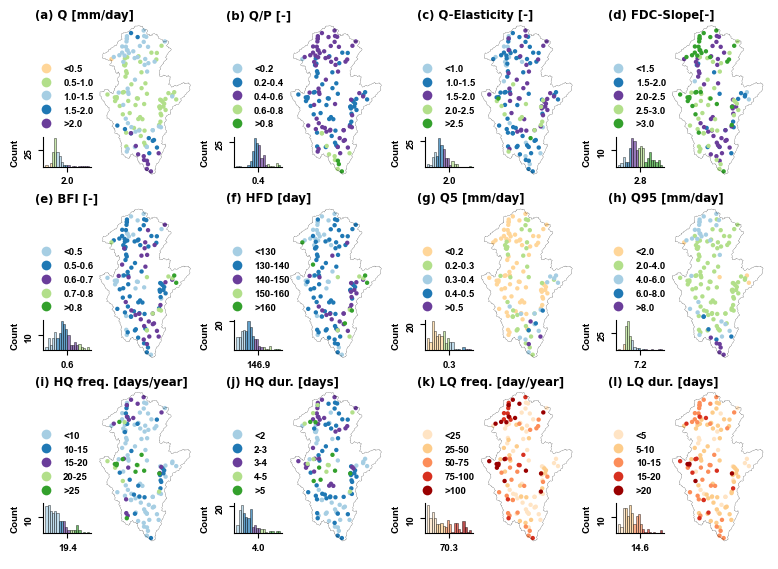

In [263]:
# List of variables
variable_list = ["q_mean"]
variable_list = ["q_mean", "q_runoff_ratio", "q_elas_Sankarasubramanian", "slope_sawicz", "baseflow_index", "hfd_mean", "q_5", "q_95", 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur']
#variable_list = ["q_95", "q_5"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 5.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold", pad=0)  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_signatures_v02.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

### Figure 7: Some signatures and attributes

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

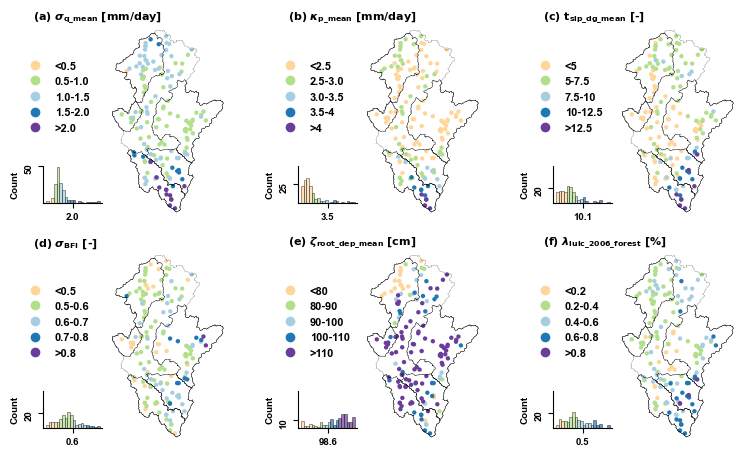

In [209]:
# Select multiple geometries
FR_selected = catchment_boundaries.loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# List of variables
variable_list = ["q_mean"]
variable_list = ["q_mean", "slope_sawicz", "baseflow_index", "hfd_mean", "q_5", "q_95"]
variable_list = ["q_mean", 'p_mean', 'slp_dg_mean',  "baseflow_index", 'root_dep_mean', 'lulc_2006_forest']

# Create custom y labels (adjust based on your data)
custom_legend_title = ['$\sigma_{\mathrm{q\_mean}}$ [mm/day]',  
                   "$\kappa_{\mathrm{p\_mean}}$ [mm/day]", 
                   "$\mathrm{t}_{\mathrm{slp\_dg\_mean}}$ [-]",
                   '$\sigma_{\mathrm{BFI}}$ [-]',
                   "$\zeta_{\mathrm{root\_dep\_mean}}$ [cm]",
                   "$\lambda_{\mathrm{lulc\_2006\_forest}}$ [%]"]

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 3
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.8, 4.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = custom_legend_title[i]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold", pad=0)  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    FR_selected_gdf.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_signatures_attributes.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

### Supporting information: Only attributes

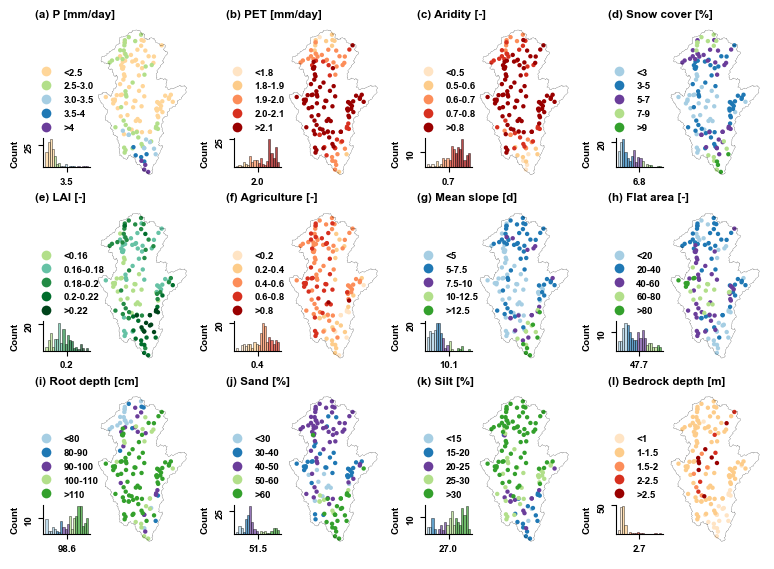

In [250]:
# List of variables
variable_list = ['p_mean', 'pet_mean', 'aridity', "sno_cov_mean", 'lai_mean', 'lulc_2006_agriculture', 'slp_dg_mean', "flat_area_fra", 'root_dep_mean', 'soil_fra_sand_mean', 'soil_fra_silt_mean', "bedrk_dep"]
#variable_list = ['pet_mean']

# Create a subplot grid
num_variables = len(variable_list)
num_cols = 4
num_rows = math.ceil(num_variables / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(7.7, 5.5))
axs = axs.flatten()

for i, variable in enumerate(variable_list):
    
    plot_variable_subplot(axs[i], variable, network_estreams_filtered, color_mapping_list, gdf)
    legend_title = color_mapping_list[variable][0]
        
    axs[i].set_title(f'({chr(97+i)}) {legend_title}', loc="left", fontweight="bold")  # Add subplot title with letter indexing
    # Plot the shapefile with white facecolor and black boundaries
    moselle_del.plot(ax=axs[i], facecolor='none', edgecolor='black', linewidth=0.1)
    #river_moselle.plot(ax=axs[i], linewidth=0.25)
    
    axs[i].set_xlim(3.7, 8) 
    axs[i].set_ylim(47.5, 50.5)  
    
# Adjust layout and remove space between subplots
plt.tight_layout(pad=0)

# Save the figure as a file
fig.savefig(r'results\figs\fig_plots_v02.png', dpi=300, bbox_inches='tight')

# Save or display the plot
plt.show()

## Appendix A. Three geologies for the Moselle

In [ ]:
# Set the basin_id as the index
catchment_boundaries.set_index("basin_id", inplace=True)
# Reproject to EPSG:4326
catchment_boundaries = catchment_boundaries.to_crs(epsg=4326)

In [341]:
# Assuming network_estreams_filtered is your DataFrame with lat and lon columns
# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_filtered['lon'], network_estreams_filtered['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_filtered, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_filtered.index

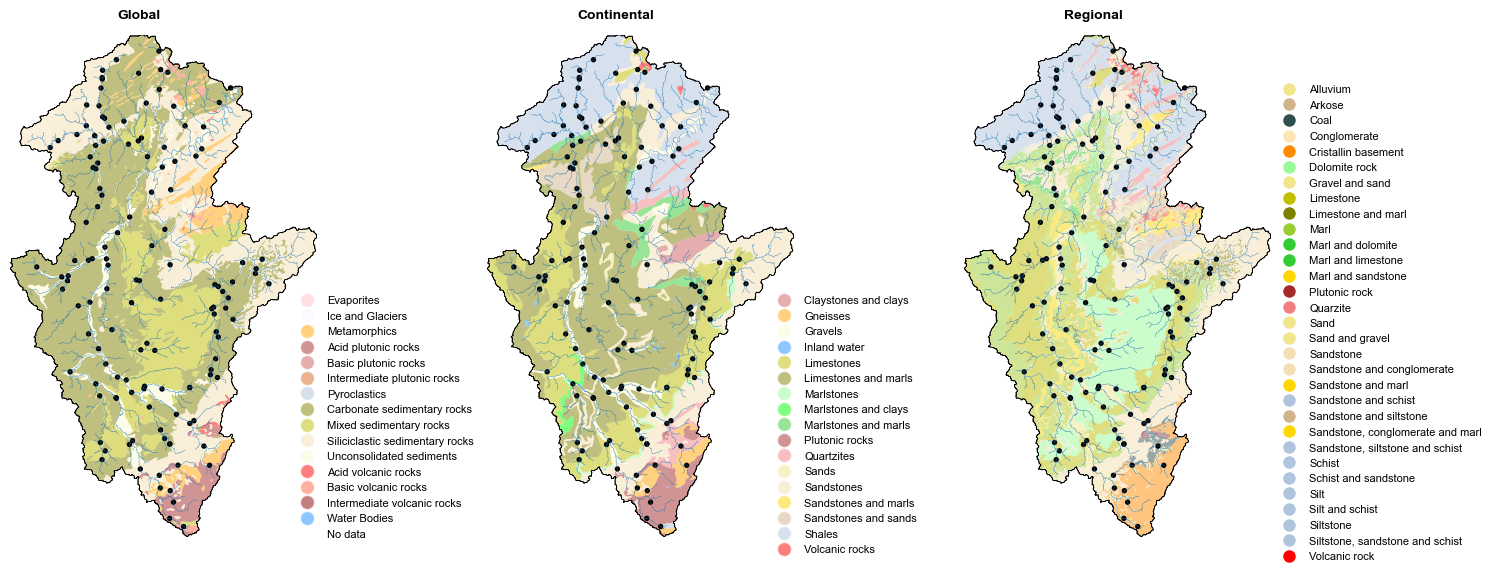

In [363]:
# Set global font properties
plt.rcParams.update({
    #'font.family': 'serif',            # Font family (e.g., 'sans-serif', 'serif', 'monospace')
    'font.size': 8,                  # Default font size
    'axes.titlesize': 8,             # Title font size
    'axes.labelsize': 8,             # Axis label font size
    'xtick.labelsize': 8,            # X-axis tick label font size
    'ytick.labelsize': 8,            # Y-axis tick label font size
    'legend.fontsize': 8,            # Legend font size
    'figure.titlesize': 6  ,          # Figure title font size
    'axes.titleweight': 'regular',        # Make only axis titles bold
    'font.weight': 'regular'           # Regular font for all other text
})

# Select multiple geometries
FR_selected = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')


# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'ev': "pink",  # Evaporites
    'ig': "ghostwhite",  # Ice and Glaciers
    'mt': "orange",  # Metamorphics
    'pa': "brown",  # Acid plutonic rocks
    'pb': "indianred",  # Basic plutonic rocks
    'pi': "chocolate",  # Intermediate plutonic rocks
    'py': "lightsteelblue",  # Pyroclastics
    'sc': "olive",  # Carbonate sedimentary rocks
    'sm': "y",  # Mixed sedimentary rocks
    'ss': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'su': "#FAFAD2",  # Unconsolidated sediments
    'va': "red",  # Acid volcanic rocks
    'vb': "tomato",  # Basic volcanic rocks
    'vi': "darkred",  # Intermediate volcanic rocks
    'wb': "#1E90FF",  # Water Bodies
    'nd': "white"   # Precambrian rocks
}

# Define the first color mapping for GLiM_dissolved just for the legend (full names)
color_mapping_glim_legend = {
    'Evaporites': "pink",  # Evaporites
    'Ice and Glaciers': "ghostwhite",  # Ice and Glaciers
    'Metamorphics': "orange",  # Metamorphics
    'Acid plutonic rocks': "brown",  # Acid plutonic rocks
    'Basic plutonic rocks': "indianred",  # Basic plutonic rocks
    'Intermediate plutonic rocks': "chocolate",  # Intermediate plutonic rocks
    'Pyroclastics': "lightsteelblue",  # Pyroclastics
    'Carbonate sedimentary rocks': "olive",  # Carbonate sedimentary rocks
    'Mixed sedimentary rocks': "y",  # Mixed sedimentary rocks
    'Siliciclastic sedimentary rocks': "#F5DEB3",  # Siliciclastic sedimentary rocks
    'Unconsolidated sediments': "#FAFAD2",  # Unconsolidated sediments
    'Acid volcanic rocks': "red",  # Acid volcanic rocks
    'Basic volcanic rocks': "tomato",  # Basic volcanic rocks
    'Intermediate volcanic rocks': "darkred",  # Intermediate volcanic rocks
    'Water Bodies': "#1E90FF",  # Water Bodies
    'No data': "white"   # Precambrian rocks
}


# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'Claystones and clays': 'indianred',       # Saddle Brown
    'Gneisses': 'orange',                       # Dim Gray
    'Gravels': '#FAFAD2',                         # Light Yellow
    'Inland water': '#1E90FF',                 # Dodger Blue
    'Limestones': 'y',                       # Light Slate Gray
    'Limestones and marls': 'olive',            # Slate Gray
    'Marlstones': 'palegreen',                   # Pale Green
    'Marlstones and clays': 'lime',         # Dark Olive Green
    'Marlstones and marls': '#32CD32',         # Lime Green
    'Plutonic rocks': 'brown',                 # Black
    'Quartzites': 'lightcoral',                   # Dark Slate Blue
    'Sands': 'khaki',                        # Light Goldenrod Yellow
    'Sandstones': '#F5DEB3',                   # Burlywood
    'Sandstones and marls': 'gold',         # Peru
    'Sandstones and sands': 'tan',         # Wheat
    'Shales': 'lightsteelblue',                       # Dark Slate Gray
    'Volcanic rocks': 'red'                # Dark Red
}

# Corrected color mapping with same colors for classes with the same name
color_mapping_geology_high = {
    'Alluvium': '#F0E68C',                        # Khaki-like, slightly lighter than sand
    'Arkose': '#D2B48C',                          # Tan
    'Coal': '#2F4F4F',                            # Dark Slate Gray (for a coal-like appearance)
    'Conglomerate': '#FFE4B5',                    # Moccasin, similar to gravel
    'Cristallin basement': '#FF8C00',             # Dark Orange, similar to 'Gneisses'
    'Dolomite rock': '#98FB98',                   # PaleGreen
    'Gravel and sand': '#F0E68C',                 # Same as Sand, as they are closely related
    'Limestone': 'y',                             # Yellow, same as before
    'Limestone and marl': 'olive',                # Same as before
    'Marl': '#9ACD32',                            # YellowGreen, similar to PaleGreen but unique
    'Marl and dolomite': '#32CD32',               # LimeGreen, same as before
    'Marl and limestone': '#32CD32',              # Same as Marl and dolomite (same color logic)
    'Marl and sandstone': 'gold',                 # Same as Sandstones and marls
    'Plutonic rock': 'brown',                     # Same as Plutonic rocks
    'Quarzite': 'lightcoral',                     # Same as Quartzites
    'Sand': 'khaki',                              # Same as Sands
    'Sand and gravel': 'khaki',                   # Same as Sand
    'Sandstone': '#F5DEB3',                       # Burlywood, same as Sandstones
    'Sandstone and conglomerate': '#F5DEB3',      # Same as Sandstones (close relationship)
    'Sandstone and marl': 'gold',                 # Same as Sandstones and marls
    'Sandstone and schist': 'lightsteelblue',     # Similar to Shales but distinct
    'Sandstone and siltstone': 'tan',             # Tan-like, similar to Arkose but unique
    'Sandstone, conglomerate and marl': 'gold',   # Same as Sandstones and marls
    'Sandstone, siltstone and schist': 'lightsteelblue',  # Similar to Shales
    'Schist': 'lightsteelblue',                   # Same as Shales (similar behavior)
    'Schist and sandstone': 'lightsteelblue',     # Same as Schist
    'Silt': 'lightsteelblue',                     # Same as Schist and Shales
    'Silt and schist': 'lightsteelblue',          # Same as Schist
    'Siltstone': 'lightsteelblue',                # Same as Schist and Shales
    'Siltstone, sandstone and schist': 'lightsteelblue',  # Same as Schist
    'Volcanic rock': 'red'                        # Dark Red, same as Volcanic rocks
}



# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['class'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['class'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['class'].map(color_mapping_geology_high)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plot the first geology shapefile with different colors for each class
GLiM_moselle_dissolved.plot(column='class', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='black', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
                          label='Measurement Points')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Create custom legend elements with circles for the first plot
geology_legend_elements1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5, 
                                   label=cls) for cls, color in color_mapping_glim_legend.items()]
geology_legend1 = ax1.legend(handles=geology_legend_elements1, title='', 
                             bbox_to_anchor=(0.9, 0.5), frameon=False)

# Add the geological classes legend back to the first plot
#ax1.add_artist(geology_legend1)

# Plot the second geology shapefile with different colors for each class
geology_median_moselle_dissolved.plot(column='class', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax2, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax2, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Create custom legend elements with circles for the second plot
geology_legend_elements2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=0.5,
                                   label=cls) for cls, color in color_mapping_geology.items()]
geology_legend2 = ax2.legend(handles=geology_legend_elements2, title='', 
                             bbox_to_anchor=(0.9, 0.5), frameon=False)

# Add the geological classes legend back to the second plot
#ax2.add_artist(geology_legend2)
###########################################################################################################
# Plot the THIRD geology shapefile with different colors for each class
geology_high_moselle_dissolved.plot(column='class', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.5)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='black', linewidth=0.5, label='')

## Plot the points from network_estreams_filtered
#network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='white', linewidth=0.5, 
#                          label='Measurement Points')


# Plot the river
river_moselle.plot(ax=ax3, linewidth=0.25, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='black', linewidth=0.5, label='Basins')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
ax3.set_title('')
ax3.set_xlabel('')
ax3.set_ylabel('')

# Create custom legend elements with circles for the second plot
geology_legend_elements3 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, alpha=1,
                                   label=cls) for cls, color in color_mapping_geology_high.items()]
# Add the legend to the third plot, keeping its current location
geology_legend3 = ax3.legend(handles=geology_legend_elements3, title='', 
                             bbox_to_anchor=(0.99, 0.92), frameon=False)


# Add the geological classes legend back to the second plot
#ax3.add_artist(geology_legend3)


## Extract color mapping information from the color mapping list
#legend_labels = color_mapping_list[variable][2]
#color_mapping = color_mapping_list[variable][3]
#
## Extract color mapping information from the color mapping list
#legend_labels = color_mapping_list[variable][2]
#color_mapping = color_mapping_list[variable][3]

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    ax.text(0.42, 1.05, text_to_subplots[i], transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    i = i + 1

fig.tight_layout()

fig.savefig(r'results\figs\fig_3geologies.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Here we retrieve the name of the sub-catchments within Moselle used

In [20]:
estreams_attributes.loc[["PL000936", "FR000867", "FR003986", "FR001604"]]

gauge_id           gauge_name gauge_country gauge_provider  \
basin_id                                                                 
PL000936   152210060    ZAMBSKI KOŚCIELNE            PL        PL_IMGW   
FR000867  J930061101             J9300611            FR   FR_EAUFRANCE   
FR003986  L720061001  La Vienne Ã  Chinon            FR   FR_EAUFRANCE   
FR001604  O262002002             O2620010            FR   FR_EAUFRANCE   

                                    river   lon_snap   lat_snap        lon  \
basin_id                                                                     
PL000936                       Narew (26)  21.206094  52.755974  21.206094   
FR000867               La Vilaine à Rieux  -2.126360  47.580112  -2.126360   
FR003986               La Vienne à Chinon   0.238393  47.165937   0.238393   
FR001604  La Garonne à Verdun-sur-Garonne   1.242179  43.854636   1.242179   

                lat elevation  ...  lakes_tot_area  lakes_tot_vol  \
basin_id                       ...                                  
PL000936  52.755974       NaN  ...          649.34        4864.86   
FR000867  47.580112         1  ...           20.96          76.40   
FR003986  47.165937        25  ...           59.47         350.54   
FR001604  43.854636        91  ...           29.76         280.70   

          sno_cov_mean  irri_1990 irri_2005 stations_num_p_mean  \
basin_id                                                          
PL000936        10.874    429.370   313.206                89.0   
FR000867         0.796    101.568   180.202                15.0   
FR003986         0.964    439.426   689.877                57.0   
FR001604         5.958    830.840  1002.036                34.0   

          perm_high_regi  perm_medium_regi  perm_low_regi  perm_verylow_regi  
basin_id                                                                      
PL000936             NaN               NaN            NaN                NaN  
FR000867             NaN               NaN            NaN                NaN  
FR003986             NaN               NaN            NaN                NaN  
FR001604             NaN               NaN            NaN                NaN  

[4 rows x 123 columns]

In [21]:
estreams_attributes.loc[["FR003249", "FR000159", "FR003283", "LU000017", "DEBU1957"]]

gauge_id              gauge_name gauge_country  gauge_provider  \
basin_id                                                                     
FR003249  A573061001      La Moselle Ã  Toul            FR    FR_EAUFRANCE   
FR000159  A694102004                A6941020            FR    FR_EAUFRANCE   
FR003283  A843101001    L'Orne Ã  Rosselange            FR    FR_EAUFRANCE   
LU000017          16                 Rosport            LU  LU_CONTACTFORM   
DEBU1957    26400550  BundespegelFremersdorf            DE           DE_BU   

                            river  lon_snap   lat_snap       lon        lat  \
basin_id                                                                      
FR003249        La Moselle à Toul  5.896402  48.669764  5.896402  48.669764   
FR000159  La Meurthe à Malzéville  6.179269  48.710667  6.179269  48.710667   
FR003283      L'Orne à Rosselange  6.072001  49.256392  6.072001  49.256392   
LU000017                     Sure  6.509851  49.785883  6.509851  49.785883   
DEBU1957                     Saar  6.648000  49.409000  6.648000  49.409000   

         elevation  ...  lakes_tot_area  lakes_tot_vol  sno_cov_mean  \
basin_id            ...                                                
FR003249       201  ...            6.58          35.46         4.315   
FR000159       188  ...            6.72          69.27         4.024   
FR003283       164  ...            2.00           5.01         2.215   
LU000017       NaN  ...            2.67          67.85         4.753   
DEBU1957       NaN  ...           23.06         114.90         3.185   

          irri_1990 irri_2005 stations_num_p_mean  perm_high_regi  \
basin_id                                                            
FR003249      0.391     0.466                21.0       23.257992   
FR000159      0.391     0.627                13.0       40.885303   
FR003283      0.976     0.473                 5.0        0.003413   
LU000017      1.641     4.770                78.0       18.753136   
DEBU1957      4.261     3.796               103.0       33.169048   

          perm_medium_regi  perm_low_regi  perm_verylow_regi  
basin_id                                                      
FR003249         24.941138      27.394805          24.406065  
FR000159         16.434307      29.399550          13.280840  
FR003283         58.991819      41.004768           0.000000  
LU000017          5.872553      24.977481          50.396831  
DEBU1957         20.494960      43.577625           2.758367  

[5 rows x 123 columns]

## Figure 1: Part c

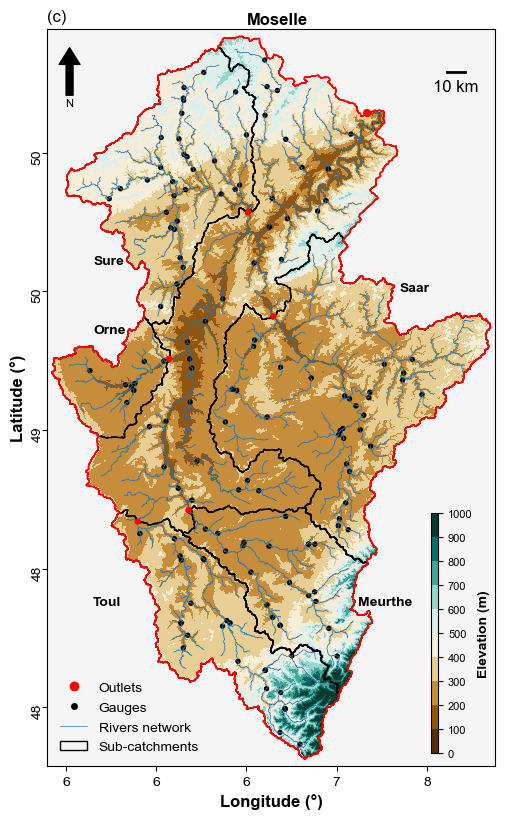

In [192]:
# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams['lon'], network_estreams['lat'])]
network_estreams_all_gdf = gpd.GeoDataFrame(network_estreams, geometry=geometry, crs='EPSG:4326')
network_estreams_all_gdf["basin_id"] = network_estreams.index


# Create a GeoDataFrame from network_estreams_filtered
geometry = [Point(xy) for xy in zip(network_estreams_filtered['lon'], network_estreams_filtered['lat'])]
network_estreams_gdf = gpd.GeoDataFrame(network_estreams_filtered, geometry=geometry, crs='EPSG:4326')
network_estreams_gdf["basin_id"] = network_estreams_filtered.index


# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, ax = plt.subplots(figsize=(5, 8))


data_df = estreams_attributes_dfs["DEBU1959"]
# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 12           # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight


# Clear the subplot
ax.clear()

# Set the background color to white
ax.set_facecolor('whitesmoke')

# Plot the shapefile with white facecolor and black boundaries
#gdf.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.1)


# Select multiple geometries
FR_selected = catchment_boundaries.loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Select multiple geometries
moselle_boundaries = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)


# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

## Define the color limits
#vmin, vmax = 200, 1000  # Set your desired min and max values for the color map
#
## Display the image with specified color range
#cax = ax.imshow(elevation_wgs, cmap='BrBG', extent=extent, vmin=vmin, vmax=vmax)

# Define the color classes (discrete intervals)
bounds = [0, 100,200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

# Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent)

# Add colorbar with class labels
#cbar = fig.colorbar(cax, ticks=bounds)
#cbar.set_label('Elevation (m)')
# Create a small colorbar inside the plot
cbar_ax = fig.add_axes([0.85, 0.07, 0.015, 0.3])  # [left, bottom, width, height]
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='vertical', ticks=bounds)
cbar.ax.tick_params(labelsize=8)  # Set the font size for the ticks
cbar.set_label('Elevation (m)', fontsize=10)  # Set the label with a smaller font size

# Adjust the colorbar size (shrink)
cbar.ax.set_aspect('auto')

# Set the title and show the plot
ax.set_title('(c)', loc = "left", fontsize=12)


# Plot the river
river_moselle.plot(ax=ax, linewidth=0.5)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax, facecolor='whitesmoke', edgecolor='darkred', linewidth=0.8)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, label='Sub-catchments')

moselle_boundaries_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1, label='Sub-catchments')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax, color='black', markersize=15, edgecolor='none', linewidth=0.5, 
                          label='Streamflow gauges')

# Plot the points from network_estreams_filtered
network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax, color='red', markersize=35, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_gdf.loc[["FR003249"]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_gdf.loc[["FR000159"]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_gdf.loc[["FR003283"]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_gdf.loc[["LU000017"]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_gdf.loc[["DEBU1957"]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)


# Set plot limits to the bounding box of the study area
ax.set_xlim(x_min-0.025, x_max+0.025)
ax.set_ylim(y_min-0.025, y_max+0.025)

ax.set_xlabel("Longitude (°)", fontsize=12)
ax.set_ylabel("Latitude (°)", fontsize=12)

# Create manual legend entries:
# For sub-catchments (as a polygon with a black boundary)
subcatchment_patch = Patch(facecolor='none', edgecolor='black', label='Sub-catchments')

# For streamflow gauges (as black dots)
streamflow_marker = Line2D([0], [0], color='black', lw=0, marker='o', markersize=4, label='Gauges')

# For outlet gauges (as black dots)
outlet_marker = Line2D([0], [0], color='red', lw=0, marker='o', markersize=6, label='Outlets')

# For another line (representing rivers)
river_line = Line2D([0], [0], lw=0.5, label='Rivers network')

# Add the legend with all items
legend = ax.legend(handles=[outlet_marker, streamflow_marker, river_line, subcatchment_patch], 
                   loc='lower left', fontsize=10, title="", title_fontsize='8', frameon=False)

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=5, headwidth=15), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Add a scale bar 
scalebar_length = 10  # in kilometers
x_scalebar = x_max - (x_max - x_min) * 0.1
y_scalebar = y_min + (y_max - y_min) * 0.95
ax.plot([x_scalebar, x_scalebar + scalebar_length/100], [y_scalebar, y_scalebar], color='black', linewidth=2)
ax.text(x_scalebar + (scalebar_length/200), y_scalebar - (y_max - y_min) * 0.02, f'{scalebar_length} km', ha='center', va='center', fontsize=12)

# Adding some text
ax.text(5.65, 49.35, 'Orne', fontsize=10, color='black', fontweight='bold')
ax.text(5.65, 49.60, 'Sure', fontsize=10, color='black', fontweight='bold')
ax.text(7.35, 49.50, 'Saar', fontsize=10, color='black', fontweight='bold')
ax.text(7.12, 48.37, 'Meurthe', fontsize=10, color='black', fontweight='bold')
ax.text(5.65, 48.37, 'Toul', fontsize=10, color='black', fontweight='bold')
ax.text(6.5, 50.465, 'Moselle', fontsize=12, color='black', fontweight='bold')


# Rotate the existing y-tick labels without changing them
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)


import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))


# Adjust the layout to remove extra space
plt.tight_layout(pad=0)


fig.savefig(r'results\figs\fig_study_areab.png', dpi=300)

# Show the plot
plt.show()

## Figure 1: Part a & b

In [80]:
catchment_boundaries.set_index("basin_id", inplace=True)

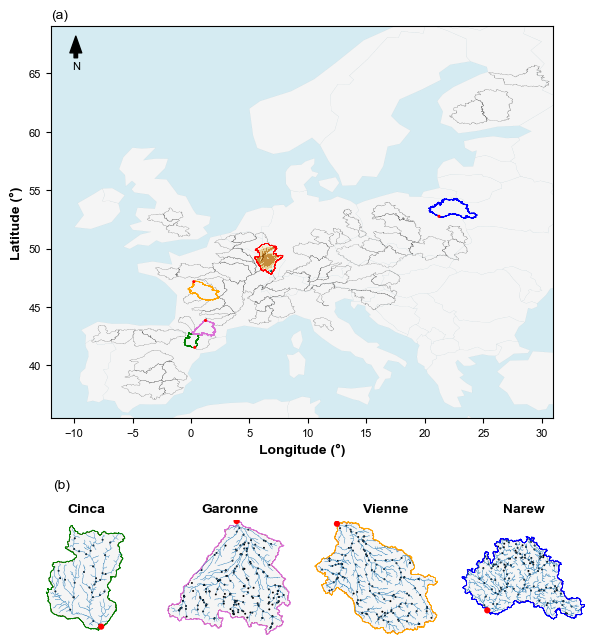

In [187]:
# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig = plt.figure(figsize=(6, 8))
gs = fig.add_gridspec(2, 1)

# Create the first figure in the first column
ax = fig.add_subplot(gs[0, 0])

list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959']

list_cats_list = dataframe_BFI_sorted.index.tolist() 

# Select multiple geometries
cats_selected = catchment_boundaries.loc[list_cats_list, "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
cats_selected_gdf = gpd.GeoDataFrame({'geometry': cats_selected}, crs='EPSG:4326')

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

# Load the world shapefile dataset provided by GeoPandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.size'] = 12            # Change the font size
mpl.rcParams['font.weight'] = 'normal'   # Change font weight
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight

estreams_attributes_used = estreams_attributes_dfs_all.copy()

# Set the background color to white
#ax.set_facecolor('white')
ax.set_facecolor((0.68, 0.85, 0.9, 0.5))  # RGBA for light blue with 50% transparency

# Plot the shapefile with white facecolor and black boundaries
gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='black', linewidth=0.01)

ax.set_xlim(-12, 31)
ax.set_ylim(35.5, 69)

# Define markers for each watershed group
#markers = ['o', 's', '^', 'D', 'P']  # You can extend this list if needed

#river_dissolved.plot(ax=ax, linewidth=0.25, alpha=0.5)

cats_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.1, label='', alpha=0.7)

# Plot the gauges for each desired watershed group
colors = plt.cm.tab10(np.linspace(0, 1, len(estreams_attributes_used.keys())))  # Get distinct colors

# Select multiple geometries
cat_selected = catchment_boundaries.loc[["DEBU1959"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.6, label='')

cat_selected = catchment_boundaries.loc[["PL000936"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.6, label='')

cat_selected = catchment_boundaries.loc[["ES000331"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=0.6, label='')

cat_selected = catchment_boundaries.loc[["FR003986"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=0.6, label='')

cat_selected = catchment_boundaries.loc[["FR001604"], "geometry"]
# Create a GeoDataFrame from the selected geometries and set the CRS directly
cat_selected_gdf = gpd.GeoDataFrame({'geometry': cat_selected}, crs='EPSG:4326')
cat_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='orchid', linewidth=0.6, label='')



# Plot the points from network_estreams_filtered
network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax, color='red', markersize=5, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_all_gdf.loc[["PL000936"]].plot(ax=ax, color='red', markersize=5, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_all_gdf.loc[["ES000331"]].plot(ax=ax, color='red', markersize=5, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_all_gdf.loc[["FR003986"]].plot(ax=ax, color='red', markersize=5, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)

network_estreams_all_gdf.loc[["FR001604"]].plot(ax=ax, color='red', markersize=5, edgecolor='none', linewidth=0.5, 
                          label='Outlet', zorder=1000)



ax.set_aspect('equal')  # Adjust aspect ratio as needed
#ax.set_axis_off()  # Turn off both x-axis and y-axis
ax.set_xlabel('Longitude (°)', fontsize=10)
ax.set_ylabel('Latitude (°)', fontsize=10)
ax.set_title("(a)", loc="left", fontsize=10)

# Add a north arrow
x, y, arrow_length = 0.05, 0.975, 0.075
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='black', width=2.5, headwidth=8.5), ha='center', va='center', fontsize=8, xycoords=ax.transAxes)

# Select multiple geometries
moselle_boundaries = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
moselle_boundaries_gdf = gpd.GeoDataFrame({'geometry': moselle_boundaries}, crs='EPSG:4326')

# Set plot limits to the bounding box of the selected study areas
bounds = moselle_boundaries_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = moselle_boundaries_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Calculate the extent
left, bottom = transform * (0, 0)
right, top = transform * (elevation_wgs.shape[1], elevation_wgs.shape[0])
extent = (left, right, top, bottom)  # Notice the order for top and bottom

# Define the color classes (discrete intervals)
bounds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Define class boundaries
cmap = plt.get_cmap('BrBG')  # Choose a colormap
norm = BoundaryNorm(bounds, cmap.N)  # Normalize based on the class boundaries

## Plot the elevation data with class intervals
cax = ax.imshow(elevation_wgs, cmap=cmap, norm=norm, extent=extent, zorder = 100)

#---------------------------------------------------------------------------------------------------------------------------------------------
gs_sub = gs[1, 0].subgridspec(1, 4)  # Create space for 3 rows in the second column

### Second grid:
# First subplot
ax1 = fig.add_subplot(gs_sub[0, 0])
ax2 = fig.add_subplot(gs_sub[0, 1])
ax3 = fig.add_subplot(gs_sub[0, 2])
ax4 = fig.add_subplot(gs_sub[0, 3])

catchments=["ES000331", "FR001604", "FR003986", "PL000936"]
colors_cat = ["green", "orchid", "orange", "blue"]
text_to_subplots=["Cinca", "Garonne", "Vienne", "Narew"]
x_centers = [0.14, 0.38, 0.64, 0.87]
i = 0
for ax in [ax1, ax2, ax3, ax4]:

    # Select the catchment
    FR_selected = catchment_boundaries.loc[[catchments[i]], "geometry"]

    # Create a GeoDataFrame from the selected geometries and set the CRS directly
    FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

    # Set plot limits to the bounding box of the selected study areas
    bounds = FR_selected_gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

    # Create a mask that covers the entire plotting area
    plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
    mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

    # Combine the selected geometries into one
    combined_geometry = FR_selected_gdf.unary_union

    # Create the mask by subtracting the combined geometry from the plot extent
    mask['geometry'] = mask.difference(combined_geometry)

    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='darkred', linewidth=0.5, label='')


    # Plot the points from network_estreams_filtered
    network_estreams_all_gdf.plot(ax=ax, color='black', markersize=2, edgecolor='none', linewidth=0.5, 
                            label='Measurement Points')
    
    # Plot the mask to cover everything outside the study area
    mask.plot(ax=ax, facecolor='white', edgecolor=colors_cat[i], linewidth=0.5, label='Basins')
    
    if catchments[i] == "ES000331":
        rivers_cinca.plot(ax=ax, linewidth=0.25, label='River network')
    elif catchments[i] == "FR001604":
        rivers_garonne.plot(ax=ax, linewidth=0.25, label='River network')
    else:
        rivers_fivesubs_es.plot(ax=ax, linewidth=0.25, label='River network')
    

    # Plot the points from network_estreams_filtered
    network_estreams_all_gdf.loc[[catchments[i]]].plot(ax=ax, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                            label='Measurement Points', zorder=10000)


    if catchments[i] == "ES000331":
        ax.set_xlim(-1, 1)
        ax.set_ylim(y_min, y_max)
    else:
        # Set plot limits to the bounding box of the study area
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Overlay the study area boundaries
    #FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    
    # Calculate the x-coordinate for the center of each subplot
    fig.text(x_centers[i], 0.36, text_to_subplots[i], fontsize=10, ha='center', va='top', fontweight='bold')

    
    #ax.set_title(text_to_subplots[i], loc="center", fontsize=10)
    i = i + 1

fig.text(0.1, 0.39, "(b)", fontsize=10, ha='center', va='top', fontweight='normal')


# Adjust the layout to remove extra space
plt.tight_layout()

fig.savefig(r'results\figs\fig_study_area_a.png', dpi=300, bbox_inches='tight')

## Figure 2: Permeabilities Moselle

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

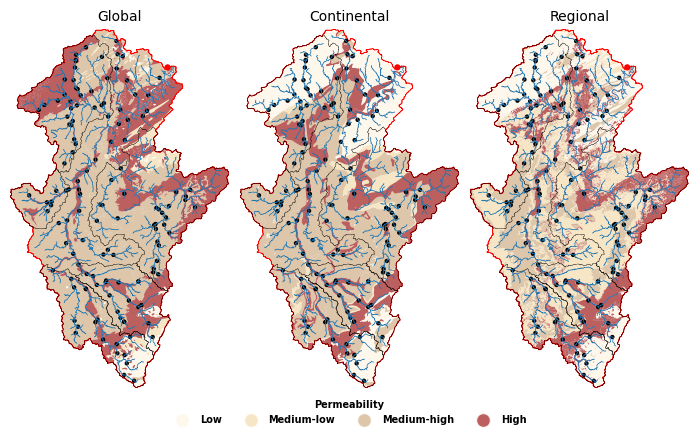

In [329]:
# Create the figure with two main columns: one for the first figure, one for the second figure (which will have 3 subplots)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 4))  # Two subplots side by side

# Select multiple geometries
FR_selected = catchment_boundaries.loc[["DEBU1959"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Define the first color mapping for GLiM_dissolved
color_mapping_glim = {
    'very low': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology = {
    'very low': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

# Define the second color mapping for geology_median_dissolved
color_mapping_geology2 = {
    'very low': "oldlace",  
    'low': "wheat",  
    'medium': "tan",  
    'high': "brown"
}

color_dict_legend = {
    'very low': 'oldlace',
    'low': 'wheat',
    'medium': 'tan',
    'high': 'brown'
}

# Add a column for colors based on the class
GLiM_moselle_dissolved['color'] = GLiM_moselle_dissolved['permeability'].map(color_mapping_glim)
geology_median_moselle_dissolved['color'] = geology_median_moselle_dissolved['permeability'].map(color_mapping_geology)
geology_high_moselle_dissolved['color'] = geology_high_moselle_dissolved['permeability'].map(color_mapping_geology2)

# Set plot limits to the bounding box of the selected study areas
bounds = FR_selected_gdf.total_bounds
x_min, y_min, x_max, y_max = bounds[0], bounds[1], bounds[2], bounds[3]

# Create a mask that covers the entire plotting area
plot_extent = box(x_min - 1, y_min - 1, x_max + 1, y_max + 1)
mask = gpd.GeoDataFrame({'geometry': [plot_extent]}, crs='EPSG:4326')

# Combine the selected geometries into one
combined_geometry = FR_selected_gdf.unary_union

# Create the mask by subtracting the combined geometry from the plot extent
mask['geometry'] = mask.difference(combined_geometry)

# Plot the first geology shapefile with different colors for each class
GLiM_moselle_dissolved.plot(column='permeability', ax=ax1, legend=True, 
                    categorical=True, color=GLiM_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax1, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax1, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax1, facecolor='white', edgecolor='red', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)

# Set plot title and labels
ax1.set_xlabel('')
ax1.set_ylabel('')



# Plot the second geology shapefile with different colors for each class
geology_median_moselle_dissolved.plot(column='permeability', ax=ax2, legend=True, 
                    categorical=True, color=geology_median_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax2, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax2, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)
# Set plot limits to the bounding box of the study area
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

# Set plot title and labels
#ax2.set_title('(c)', loc="left")
ax2.set_xlabel('')
ax2.set_ylabel('')
custom_label = ["Low", "Medium-low", "Medium-high", "High"]

# Plot the third geology shapefile with different colors for each class
geology_high_moselle_dissolved.plot(column='permeability', ax=ax3, legend=True, 
                    categorical=True, color=geology_high_moselle_dissolved['color'], edgecolor='none', linewidth=0, alpha=0.75)

# Overlay the study area boundaries
FR_selected_gdf.plot(ax=ax3, facecolor='none', edgecolor='red', linewidth=0.5, label='')

# Plot the points from network_estreams_filtered
network_estreams_gdf.plot(ax=ax3, color='black', markersize=10, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points')

network_estreams_gdf.loc[["DEBU1959"]].plot(ax=ax3, color='red', markersize=20, edgecolor='none', linewidth=0.5, 
                          label='Measurement Points', zorder=10)

# Select multiple geometries
FR_selected = catchment_boundaries.loc[["FR003283", "FR003249", "FR000159", "LU000017", "DEBU1957"], "geometry"]

# Create a GeoDataFrame from the selected geometries and set the CRS directly
FR_selected_gdf = gpd.GeoDataFrame({'geometry': FR_selected}, crs='EPSG:4326')

# Plot the river
river_moselle.plot(ax=ax1, linewidth=0.5, label='River network')
river_moselle.plot(ax=ax2, linewidth=0.5, label='River network')
river_moselle.plot(ax=ax3, linewidth=0.5, label='River network')

# Plot the mask to cover everything outside the study area
mask.plot(ax=ax3, facecolor='white', edgecolor='red', linewidth=0.5, label='Basins')

# Set plot limits to the bounding box of the study area
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)

# Set plot title and labels
#ax3.set_title('(d)', loc="left")

text_to_subplots = ["Global", "Continental", "Regional"]
i = 0 
for ax in [ax1, ax2, ax3]:

    # Overlay the study area boundaries
    FR_selected_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.25, label='Sub-catchments')

    # Hide spines for main plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    # Add text below the plot
    #ax.text(0.45, 1.075, text_to_subplots[i], transform=ax.transAxes, 
    #        fontsize=10, ha='center', va='top', color='black', fontweight='bold')
    ax.set_title(text_to_subplots[i], loc="center", fontsize=10)
    i = i + 1

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba

# Define the color dictionary with alpha transparency (0.5 for 50% opacity)
color_dict_legend = {
    'Low': to_rgba('oldlace', 0.75),
    'Medium-low': to_rgba('wheat', 0.75),
    'Medium-high': to_rgba('tan', 0.75),
    'High': to_rgba('brown', 0.75)
}

# Create custom legend elements with alpha applied to markerfacecolor
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in color_dict_legend.items()]

# Add the legend outside the plot area with minimal space
legend = fig.legend(handles=legend_elements, title='Permeability', loc='center', frameon=False, 
                   bbox_to_anchor=(0.5, -0.01), ncol=5)
# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Adjust the layout to remove extra space
plt.tight_layout()


fig.savefig(r'results\figs\fig_permeability_moselle.png', dpi=300, bbox_inches='tight')

## Appendix D

### Check the correlations using the whole dataset

In [528]:
list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959']

list_cats_list = dataframe_BFI_sorted.index.tolist()

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

In [529]:
combined_df = pd.concat(estreams_attributes_dfs_all.values(), ignore_index=True)
combined_df

gauge_id                             gauge_name gauge_country  \
0     H602102001                  L'Aisne Ã  VerriÃ¨res            FR   
1     H602321001                   L'Ante Ã  ChÃ¢trices            FR   
2     H605301001                     La Biesme au Claon            FR   
3     H611301001            La Cousances Ã  AubrÃ©ville            FR   
4     H615302002  L'Agron Ã  Champigneulle et Ã  Verpel            FR   
...          ...                                    ...           ...   
4464  O222251001                               O2222510            FR   
4465  O232401001                               O2324010            FR   
4466  O232401002                               O2324020            FR   
4467  O246293201                               O2462920            FR   
4468  O262002002                               O2620010            FR   

     gauge_provider                                river  lon_snap   lat_snap  \
0      FR_EAUFRANCE                  L'Aisne à Verrières  4.914315  49.067921   
1      FR_EAUFRANCE                   L'Ante à Châtrices  4.911759  49.052428   
2      FR_EAUFRANCE                   La Biesme au Claon  4.969964  49.142318   
3      FR_EAUFRANCE            La Cousances à Aubréville  5.084980  49.145758   
4      FR_EAUFRANCE  L'Agron à Champigneulle et à Verpel  4.931003  49.386372   
...             ...                                  ...       ...        ...   
4464   FR_EAUFRANCE  L'Hers à Toulouse [Pont de Périole]  1.480100  43.627770   
4465   FR_EAUFRANCE       Le Girou à Bourg-Saint-Bernard  1.690766  43.623780   
4466   FR_EAUFRANCE       Le Girou à Bourg-Saint-Bernard  1.719739  43.615009   
4467   FR_EAUFRANCE       La Save [CACG] à Lombez [CACG]  0.881518  43.453239   
4468   FR_EAUFRANCE      La Garonne à Verdun-sur-Garonne  1.242179  43.854636   

           lon        lat elevation  ...  lakes_tot_area  lakes_tot_vol  \
0     4.914315  49.067921       137  ...            3.23           8.92   
1     4.911759  49.052428       141  ...            1.16           2.86   
2     4.969964  49.142318       146  ...            0.00           0.00   
3     5.084980  49.145758       177  ...            0.00           0.00   
4     4.931003  49.386372       144  ...            0.00           0.00   
...        ...        ...       ...  ...             ...            ...   
4464  1.480100  43.627770       140  ...            1.59           7.66   
4465  1.690766  43.623780       157  ...            0.61           2.73   
4466  1.719739  43.615009       157  ...            0.33           1.58   
4467  0.881518  43.453239       167  ...            0.00           0.00   
4468  1.242179  43.854636        91  ...           29.76         280.70   

      sno_cov_mean  irri_1990 irri_2005 stations_num_p_mean  perm_high_regi  \
0            1.404      0.181     1.190                 6.0             NaN   
1            1.436      0.000     1.134                 2.0             NaN   
2            1.583      0.058     0.016                 3.0             NaN   
3            2.625      0.420     0.123                 3.0             NaN   
4            2.072      0.207     0.286                 3.0             NaN   
...            ...        ...       ...                 ...             ...   
4464         0.360     75.993    88.781                 5.0             NaN   
4465         0.302     61.514    99.318                 2.0             NaN   
4466         0.297     46.661    81.168                 2.0             NaN   
4467         0.383     17.930    25.887                 4.0             NaN   
4468         5.958    830.840  1002.036                34.0             NaN   

      perm_medium_regi  perm_low_regi  perm_verylow_regi  
0                  NaN            NaN                NaN  
1                  NaN            NaN                NaN  
2                  NaN            NaN                NaN  
3                  NaN            NaN                NaN  
4            

100%|██████████| 14/14 [00:06<00:00,  2.27it/s]


dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


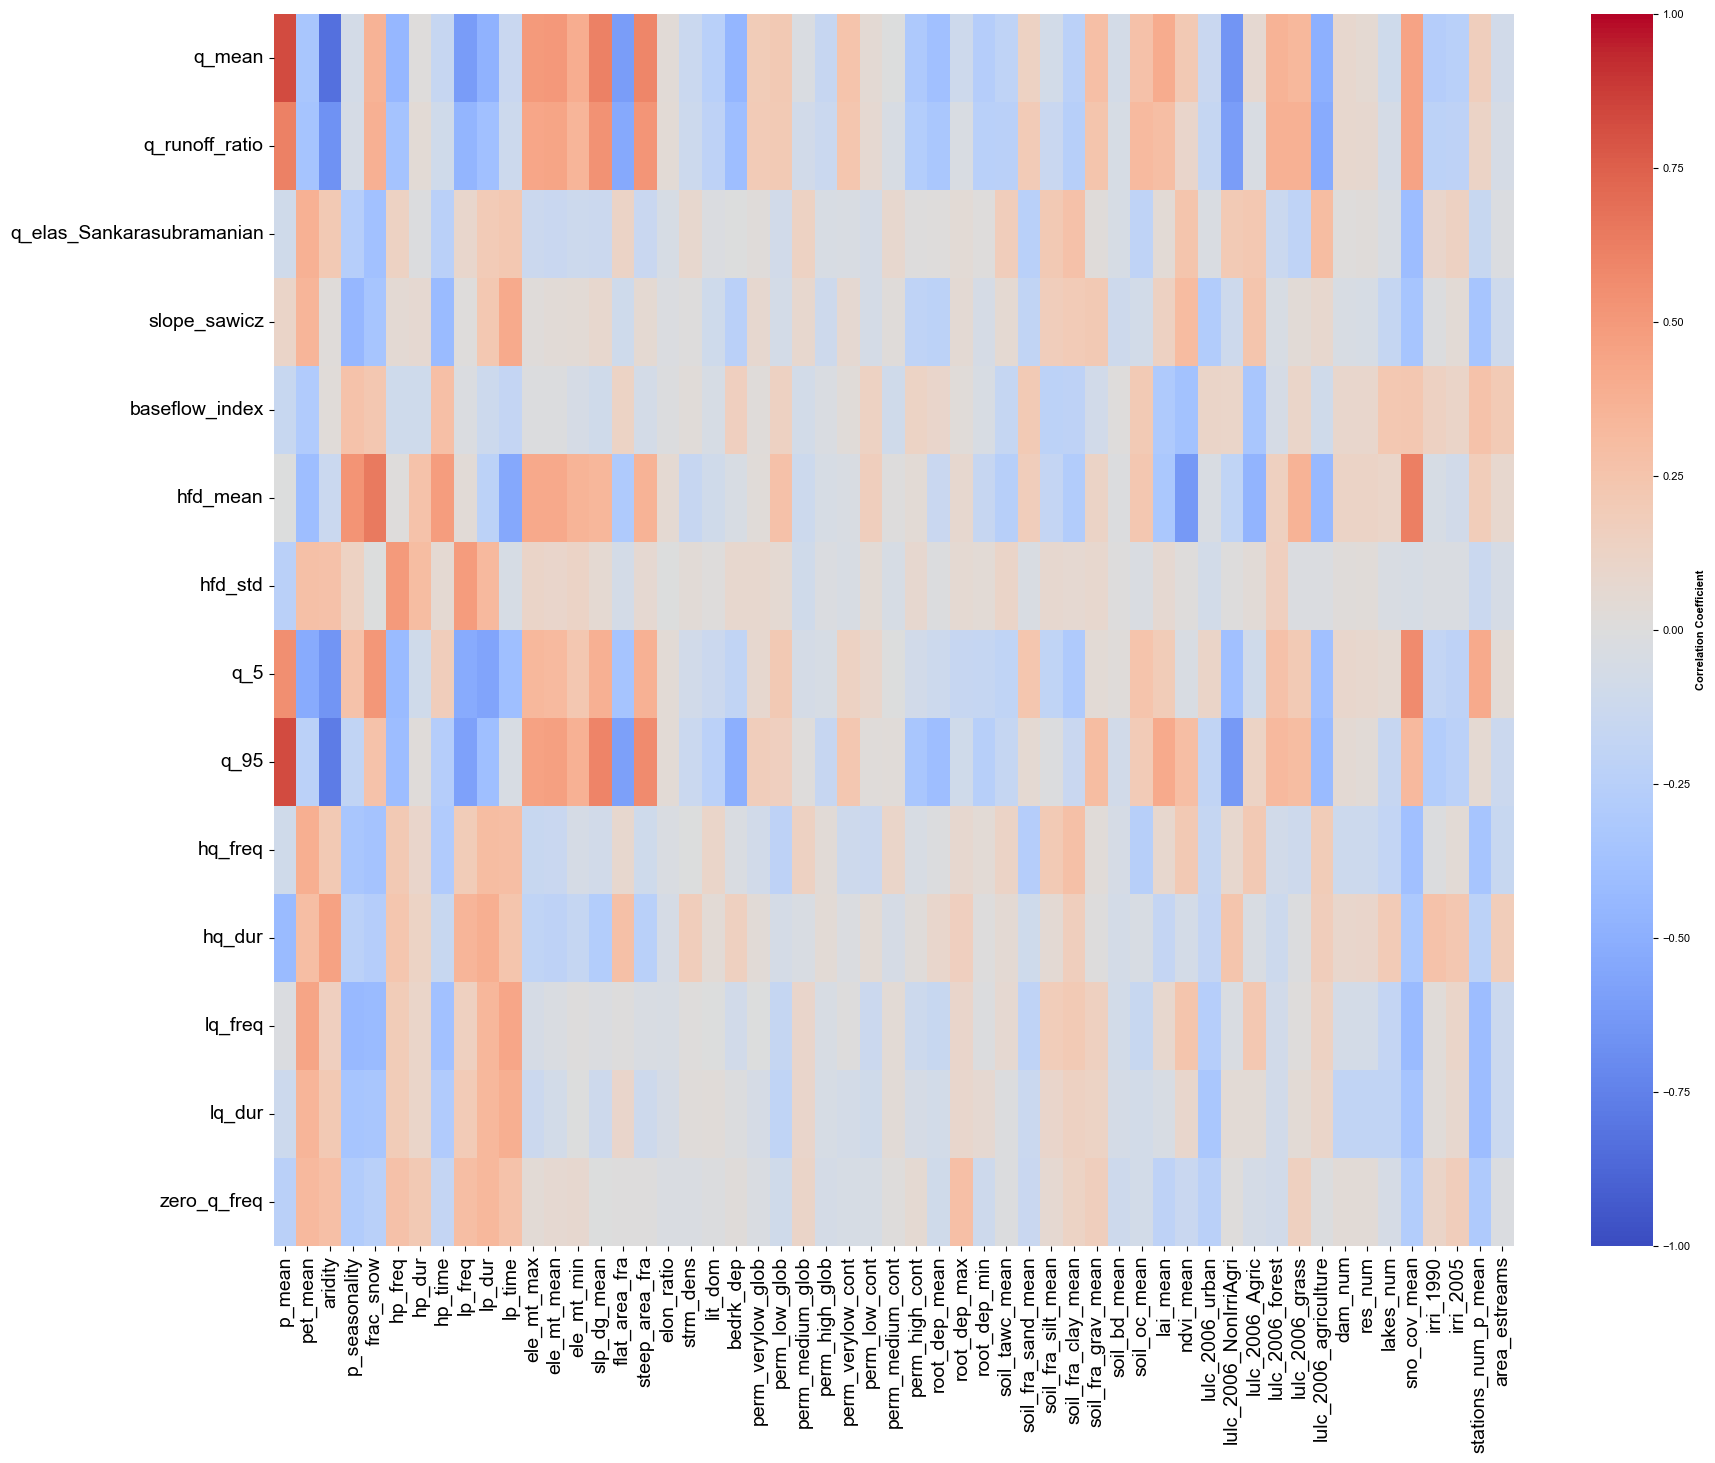

In [531]:
# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(combined_df.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    

    estreams_attributes_dfs_cat = combined_df.copy()
    #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
    estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
    # Calculate correlations between the current variable and other variables
    correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
    # Add the correlations to the DataFrame
    correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict.keys())

# Assuming correlation_dict is a dictionary containing all correlation DataFrames
# Initialize an empty list to store individual correlation DataFrames
correlation_list = []

# Iterate over all keys in the dictionary and append their DataFrame to the list with an added 'signature' column
for signature in correlation_dict.keys():
    corr_df = correlation_dict[signature].T
    corr_df['signature'] = signature  # Add a column to identify the signature
    correlation_list.append(corr_df)

# Concatenate all correlation DataFrames along the rows
combined_correlation_df = pd.concat(correlation_list)

# Preserve the order of the signatures by converting to categorical type
combined_correlation_df['signature'] = pd.Categorical(
    combined_correlation_df['signature'],
    categories=list(correlation_dict.keys()),
    ordered=True
)

# Set the signature column as the index
combined_correlation_df.set_index('signature', inplace=True)

# Customize row names (for demonstration purposes, modify as needed)
#custom_row_names = ['Row ' + str(i) for i in range(1, len(combined_correlation_df.index) + 1)]
#combined_correlation_df.index = custom_row_names

# Plot the combined heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(combined_correlation_df, annot=False, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1, 
            cbar_kws={'label': 'Correlation Coefficient'}, 
            yticklabels=combined_correlation_df.index)

#plt.title('Combined Heatmap for All Signatures', fontsize=20)
#plt.xlabel('Variables', fontsize=15)
plt.ylabel('', fontsize=15)

# Customize font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [532]:
correlation_dict["baseflow_index"]

FR001604
p_mean                -0.154090
pet_mean              -0.295179
aridity                0.030364
p_seasonality          0.262083
frac_snow              0.232618
hp_freq               -0.107515
hp_dur                -0.107399
hp_time                0.283033
lp_freq               -0.018293
lp_dur                -0.122460
lp_time               -0.172465
ele_mt_max            -0.013668
ele_mt_mean           -0.013260
ele_mt_min            -0.059678
slp_dg_mean           -0.100082
flat_area_fra          0.126641
steep_area_fra        -0.071273
elon_ratio            -0.009459
strm_dens              0.026090
lit_dom               -0.053422
bedrk_dep              0.162561
perm_verylow_glob      0.017349
perm_low_glob          0.144344
perm_medium_glob      -0.078335
perm_high_glob        -0.027392
perm_verylow_cont      0.030108
perm_low_cont          0.134022
perm_medium_cont      -0.094149
perm_high_cont         0.127356
root_dep_mean          0.097991
root_dep_max           0.029952
root_dep_min          -0.042260
soil_tawc_mean        -0.169768
soil_fra_sand_mean     0.205325
soil_fra_silt_mean    -0.220724
soil_fra_clay_mean    -0.211941
soil_fra_grav_mean    -0.087980
soil_bd_mean           0.008136
soil_oc_mean           0.207910
lai_mean              -0.298008
ndvi_mean             -0.367535
lulc_2006_urban        0.115444
lulc_2006_NonIrriAgri  0.106663
lulc_2006_Agric       -0.336342
lulc_2006_forest      -0.055976
lulc_2006_grass        0.108245
lulc_2006_agriculture -0.096302
dam_num                0.086486
res_num                0.088107
lakes_num              0.224584
sno_cov_mean           0.230877
irri_1990              0.140956
irri_2005              0.110184
stations_num_p_mean    0.258141
area_estreams          0.205588

In [533]:
correlation_dict["baseflow_index"].loc[["perm_verylow_glob", "perm_low_glob", "perm_medium_glob", "perm_high_glob", 
                                        "perm_verylow_cont", "perm_low_cont", "perm_medium_cont", "perm_high_cont"]]

FR001604
perm_verylow_glob  0.017349
perm_low_glob      0.144344
perm_medium_glob  -0.078335
perm_high_glob    -0.027392
perm_verylow_cont  0.030108
perm_low_cont      0.134022
perm_medium_cont  -0.094149
perm_high_cont     0.127356

In [412]:
combined_df["q5qmean"] = combined_df["q_5"]/combined_df["q_mean"]

In [413]:
combined_df[["q5qmean",'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont']].corr(method="spearman")

q5qmean  perm_verylow_glob  perm_low_glob  \
q5qmean            1.000000          -0.055496       0.124605   
perm_verylow_glob -0.055496           1.000000       0.610883   
perm_low_glob      0.124605           0.610883       1.000000   
perm_medium_glob  -0.062619          -0.437438      -0.390191   
perm_high_glob     0.069388          -0.276156      -0.355206   
perm_verylow_cont -0.019319           0.595004       0.397259   
perm_low_cont      0.108624           0.311299       0.555488   
perm_medium_cont  -0.012960          -0.462093      -0.394918   
perm_high_cont     0.142588          -0.185984      -0.226146   

                   perm_medium_glob  perm_high_glob  perm_verylow_cont  \
q5qmean                   -0.062619        0.069388          -0.019319   
perm_verylow_glob         -0.437438       -0.276156           0.595004   
perm_low_glob             -0.390191       -0.355206           0.397259   
perm_medium_glob           1.000000       -0.349176          -0.473136   
perm_high_glob            -0.349176        1.000000          -0.052265   
perm_verylow_cont         -0.473136       -0.052265           1.000000   
perm_low_cont             -0.204668       -0.180557           0.000372   
perm_medium_cont           0.691605       -0.058502          -0.558813   
perm_high_cont             0.079683        0.381091          -0.275460   

                   perm_low_cont  perm_medium_cont  perm_high_cont  
q5qmean                 0.108624         -0.012960        0.142588  
perm_verylow_glob       0.311299         -0.462093       -0.185984  
perm_low_glob           0.555488         -0.394918       -0.226146  
perm_medium_glob       -0.204668          0.691605        0.079683  
perm_high_glob         -0.180557         -0.058502        0.381091  
perm_verylow_cont       0.000372         -0.558813       -0.275460  
perm_low_cont           1.000000         -0.305068       -0.090666  
perm_medium_cont       -0.305068          1.000000       -0.104573  
perm_high_cont         -0.090666         -0.104573        1.000000

# Additional analysis

### Correlation between geology and other attributes f0or the five regional catchments overexplored

In [56]:
list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959', "ES000331"]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

In [100]:
### Vilaine  
corrs_test = estreams_attributes_dfs_all["FR000867"].loc[:, ['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]].corr(method="spearman")[['perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont']]

corrs_test.loc[["baseflow_index", "p_mean", "pet_mean", "ele_mt_mean"], :].T

baseflow_index    p_mean  pet_mean  ele_mt_mean
perm_verylow_glob        0.797377  0.765176 -0.467707     0.581454
perm_low_glob            0.574155  0.624412 -0.445607     0.329749
perm_medium_glob        -0.126298  0.173084 -0.019213     0.218656
perm_high_glob          -0.472864 -0.679607  0.327566    -0.433147
perm_verylow_cont       -0.315907 -0.421846  0.331473    -0.159128
perm_low_cont            0.363335  0.369794 -0.093372    -0.045217
perm_medium_cont         0.092873  0.210907 -0.361583     0.277867
perm_high_cont          -0.030429  0.051860  0.171870    -0.235818

In [ ]:
### Garonne
corrs_test = estreams_attributes_dfs_all["FR001604"].loc[:, ['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]].corr(method="spearman")[['perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont']]

corrs_test.loc[["baseflow_index", "p_mean", "pet_mean", "ele_mt_mean"], :].T

baseflow_index    p_mean  pet_mean  ele_mt_mean
perm_verylow_glob        0.801799  0.825808 -0.822961     0.826126
perm_low_glob            0.699435  0.883459 -0.902741     0.894441
perm_medium_glob        -0.689619 -0.605099  0.569535    -0.591062
perm_high_glob           0.196783 -0.095642  0.229336    -0.160977
perm_verylow_cont        0.787246  0.915524 -0.912828     0.923135
perm_low_cont            0.553511  0.466285 -0.513058     0.506509
perm_medium_cont        -0.866982 -0.864973  0.852973    -0.847543
perm_high_cont          -0.063574 -0.480520  0.472912    -0.514080

In [57]:
## Cinca
corrs_test = estreams_attributes_dfs_all["ES000331"].loc[:, ['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]].corr(method="spearman")[['perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont']]

corrs_test.loc[["baseflow_index", "p_mean", "pet_mean", "ele_mt_mean"], :].T

baseflow_index    p_mean  pet_mean  ele_mt_mean
perm_verylow_glob        0.249236  0.791128 -0.819785     0.813707
perm_low_glob            0.223157  0.853247 -0.873572     0.866374
perm_medium_glob         0.596154 -0.270769  0.256923    -0.195385
perm_high_glob          -0.613077 -0.370769  0.394615    -0.446923
perm_verylow_cont        0.287712  0.805440 -0.801180     0.804278
perm_low_cont           -0.056967  0.016936 -0.056967     0.089299
perm_medium_cont        -0.228462  0.549231 -0.524615     0.505385
perm_high_cont           0.069750 -0.904433  0.906360    -0.885551

In [103]:
### Viene
corrs_test = estreams_attributes_dfs_all["FR003986"].loc[:, ['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]].corr(method="spearman")[['perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont']]

corrs_test.loc[["baseflow_index", "p_mean", "pet_mean", "ele_mt_mean"], :].T

baseflow_index    p_mean  pet_mean  ele_mt_mean
perm_verylow_glob        0.107717  0.732014 -0.806480     0.817253
perm_low_glob           -0.041637  0.552278 -0.443297     0.492091
perm_medium_glob        -0.160076 -0.837647  0.816818    -0.811234
perm_high_glob          -0.103369 -0.679335  0.666445    -0.633401
perm_verylow_cont        0.115156  0.790531 -0.862969     0.855170
perm_low_cont           -0.127033  0.186456 -0.093788     0.130912
perm_medium_cont        -0.099541 -0.820007  0.824112    -0.831720
perm_high_cont          -0.183550 -0.753633  0.711582    -0.664536

In [ ]:
### Narew  
corrs_test = estreams_attributes_dfs_all["PL000936"].loc[:, ['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]].corr(method="spearman")[['perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont']]

corrs_test.loc[["baseflow_index", "p_mean", "pet_mean", "ele_mt_mean"], :].T

baseflow_index    p_mean  pet_mean  ele_mt_mean
perm_verylow_glob             NaN       NaN       NaN          NaN
perm_low_glob                 NaN       NaN       NaN          NaN
perm_medium_glob        -0.022025  0.122547  0.355862     0.055325
perm_high_glob           0.022025 -0.122547 -0.355862    -0.055325
perm_verylow_cont        0.671413  0.182722 -0.728173    -0.214401
perm_low_cont            0.017093  0.154806 -0.418559     0.227506
perm_medium_cont              NaN       NaN       NaN          NaN
perm_high_cont          -0.080603 -0.152144  0.475297    -0.205070

In [199]:
### Moselle 

corrs_test = estreams_attributes_dfs_all["DEBU1959"].loc[:, ['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]].corr(method="spearman")[['perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont']]

corrs_test.loc[["baseflow_index", "p_mean", "pet_mean", "ele_mt_mean"], :].T

baseflow_index    p_mean  pet_mean  ele_mt_mean
perm_verylow_glob        0.307991  0.522246 -0.349569     0.498548
perm_low_glob            0.235187  0.417933 -0.553453     0.584544
perm_medium_glob        -0.504796 -0.672844  0.694107    -0.741886
perm_high_glob           0.537650  0.422221 -0.492105     0.453667
perm_verylow_cont       -0.022020  0.538455 -0.765427     0.693867
perm_low_cont            0.365131  0.461889  0.007994     0.249455
perm_medium_cont        -0.319391 -0.636889  0.825462    -0.834962
perm_high_cont           0.586709  0.016823  0.085817    -0.010378

### Check the percentage of classes over each catchment

In [19]:
list_cats_list = ['ES000801', 'ES000665', 'ES001243', 'ES000196', 'ES000194', 'ES001080',
       'ES000316', 'ES000339', 'GB000472', 'GB000271', 'GB000153', 'ITTO0361',
       'ITVE0408', 'ITPI0183', 'FI000557', 'FI000226', 'FI000137', 'PL000936',
       'PL000794', 'HR000048', 'HUGR0037', 'AT000393', 'PL000253', 'PL000349',
       'PL000015', 'CZ000097', 'DEST1711', 'DEBY0711', 'DEBY0724', 'DEBY0697',
       'DEBU1953', 'NL000008', 'CH000026', 'FR002679', 'FR004615', 'NL000016',
       'BEVL0155', 'FR000408', 'FR000373', 'FR000345', 'FR001071', 'FR003922',
       'FR003986', 'FR002118', 'FR001952', 'FR002029', 'FR001604', 'FR004221',
       'ES001171', 'ES001010', 'PL000536', 'HR000278', 'CZ000236', 'DEST1707',
       'DEBE0155', 'FR002758', 'FR002462', 'FR001394', 'FR000867', 'FR004308',
       'DEBU1959']

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs_all = {}

for catchment in list_cats_list:
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs_all[catchment] = cat_clip

In [20]:
catchments=["FR000867", "FR001604", "FR003986", "PL000936", "DEBU1959"]
text_to_subplots=["Vilaine", "Garonne", "Viene", "Narew", "Moselle"]

In [40]:
estreams_attributes.loc[["FR000867", "FR001604", "FR003986", "PL000936", "DEBU1959", "ES000331"], ['perm_high_glob',
       'perm_medium_glob', 'perm_low_glob', 'perm_verylow_glob',
       'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont']].T

basin_id           FR000867  FR001604  FR003986  PL000936   DEBU1959  ES000331
perm_high_glob       83.060    28.927    13.688    95.818  30.731000    28.149
perm_medium_glob      5.707    52.720    36.600     4.181  60.685000    68.276
perm_low_glob         4.619    15.293    20.882     0.000   4.666000     1.829
perm_verylow_glob     6.613     3.035    28.830     0.000   3.826000     0.917
perm_high_cont        2.952    17.473    16.642    42.634  22.487000    57.031
perm_medium_cont      4.463    49.274    30.607     0.000  48.081000    33.985
perm_low_cont         5.261     7.386    15.470    54.984   6.691000     4.321
perm_verylow_cont    87.325    25.867    37.280     2.382  22.741459     4.665

In [25]:
estreams_attributes_dfs_all["FR000867"].loc[:, ['perm_high_glob',
       'perm_medium_glob', 'perm_low_glob', 'perm_verylow_glob',
       'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont']]

# Apply condition and count occurrences
counts = estreams_attributes_dfs_all["FR000867"]["perm_high_glob"].gt(99).sum()
print(counts)

# Apply condition and count occurrences
counts = estreams_attributes_dfs_all["FR000867"]["perm_verylow_cont"].gt(99).sum()
print(counts)

# Total
counts = estreams_attributes_dfs_all["FR000867"]["perm_verylow_cont"].gt(0).sum()
print(counts)


# Total
counts = estreams_attributes_dfs_all["FR000867"]["perm_verylow_glob"].gt(0).sum()
print(counts)

6
12
45
32


In [87]:
estreams_attributes_dfs_all["ES000331"].loc[:, ['perm_high_glob',
       'perm_medium_glob', 'perm_low_glob', 'perm_verylow_glob',
       'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont']]

# Apply condition and count occurrences
counts = estreams_attributes_dfs_all["ES000331"]["perm_medium_glob"].gt(99).sum()
print(counts)

# Apply condition and count occurrences
counts = estreams_attributes_dfs_all["ES000331"]["perm_medium_cont"].gt(99).sum()
print(counts)

# Total
counts = estreams_attributes_dfs_all["ES000331"]["perm_verylow_cont"].gt(0).sum()
print(counts)


# Total
counts = estreams_attributes_dfs_all["ES000331"]["perm_verylow_glob"].gt(0).sum()
print(counts)

0
0
19
10


findfont: Font family 'helvetica' not found.


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

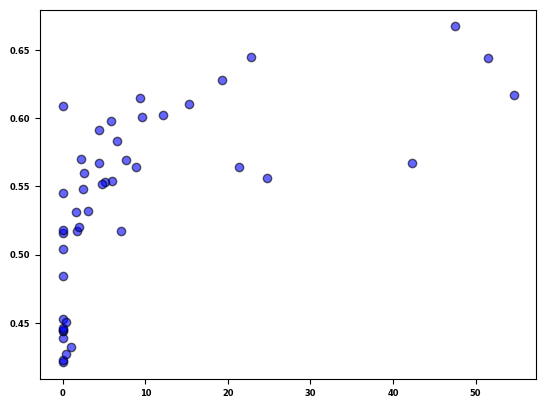

In [51]:
df = estreams_attributes_dfs_all["FR000867"].loc[:, [
       'baseflow_index', 

       'perm_verylow_glob', 'perm_verylow_cont', "perm_high_cont", "perm_low_cont"]]

plt.scatter(df['perm_verylow_glob'], df['baseflow_index'], color='blue', alpha=0.6, edgecolor='black')

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

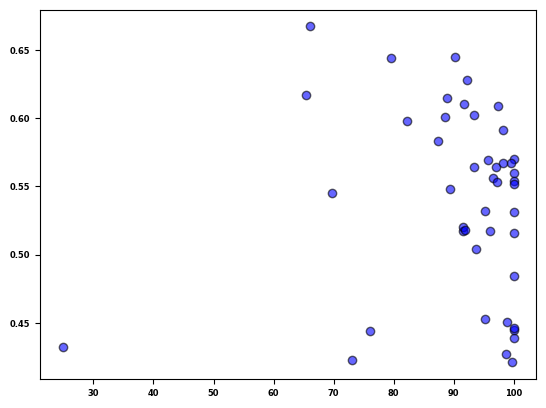

In [52]:
plt.scatter(df['perm_verylow_cont'], df['baseflow_index'], color='blue', alpha=0.6, edgecolor='black')


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

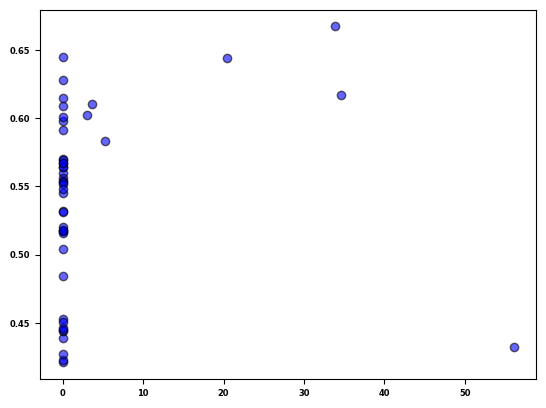

In [54]:
plt.scatter(df['perm_low_cont'], df['baseflow_index'], color='blue', alpha=0.6, edgecolor='black')


In [545]:
estreams_attributes_dfs_all["FR003986"].loc[:, ['perm_high_glob',
       'perm_medium_glob', 'perm_low_glob', 'perm_verylow_glob',
       'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont']]

# Apply condition and count occurrences
counts = estreams_attributes_dfs_all["FR001604"]["perm_verylow_glob"].lt(1).sum()
print(counts)

# Apply condition and count occurrences
counts = estreams_attributes_dfs_all["FR001604"]["perm_verylow_cont"].lt(1).sum()
print(counts)

# Total
counts = estreams_attributes_dfs_all["FR001604"]["perm_verylow_cont"].gt(0).sum()
print(counts)

40
23
44


## Area of Moselle within each country

In [9]:
catchment_boundaries[catchment_boundaries.basin_id == "DEBU1959"]

basin_id  gauge_id country  area_offic  area_estre  area_flag  area_rel  \
3781  DEBU1959  26900400      DE     27088.0     27100.0          0   -0.0443   

      start_date    end_date gauge_flag  upstream  group  \
3781  1901-01-01  2021-07-31          B       210      1   

                                               geometry  
3781  POLYGON Z ((7.14374 50.13125 0.00000, 7.14374 ...

In [11]:
import geopandas as gpd
from shapely.geometry import shape

# Load the world countries shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load your shapefile (replace 'your_shapefile.shp' with the path to your file)
your_shapefile = catchment_boundaries[catchment_boundaries.basin_id == "DEBU1959"].copy()

# Ensure both datasets are in the same CRS (WGS84, EPSG:4326)
your_shapefile = your_shapefile.to_crs(epsg=4326)
world = world.to_crs(epsg=4326)

# Reproject to an equal-area projection for accurate area calculations (e.g., World Eckert IV, EPSG:54012)
equal_area_crs = 'EPSG:3035'  # World Eckert IV projection
your_shapefile = your_shapefile.to_crs(equal_area_crs)
world = world.to_crs(equal_area_crs) 

# Perform a spatial join to find intersections
intersections = gpd.overlay(your_shapefile, world, how='intersection')

# Calculate the area of each intersection
intersections['area'] = intersections.geometry.area

# Calculate the total area of your shapefile
total_area = your_shapefile.geometry.area.sum()

# Group by country and calculate the percentage of area
results = intersections.groupby('name')['area'].sum().reset_index()
results['percentage'] = (results['area'] / total_area) * 100

# Sort by percentage (descending)
results = results.sort_values(by='percentage', ascending=False)

# Print the results
print(results)

         name          area  percentage
1      France  1.478713e+10   54.540232
2     Germany  9.927611e+09   36.616599
3  Luxembourg  2.024718e+09    7.467889
0     Belgium  3.728705e+08    1.375280


# Drop in correlations from the headwaters to the outlet

## Drop in correlation: Moselle

In [105]:
from utils.functions import compute_correlation_score, find_unique_nested_catchments, find_directly_connected_catchments
from utils.plots import plot_histograms_by_group, plot_histograms_by_group_two_subsets, plot_watershed_groups_from_dict

In [251]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]
nested_cats_df

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["DEBU1959"]

# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       "perm_verylow_regi", "perm_low_regi", "perm_medium_regi", "perm_high_regi",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict.keys())
correlation_dict["baseflow_index"]

100%|██████████| 14/14 [00:00<00:00, 35.04it/s]

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


DEBU1959
p_mean                 0.245129
pet_mean              -0.220092
aridity               -0.246028
p_seasonality         -0.129408
frac_snow              0.207157
hp_freq               -0.070253
hp_dur                 0.058948
hp_time                0.163094
lp_freq               -0.084574
lp_dur                -0.138445
lp_time               -0.305336
ele_mt_max             0.380226
ele_mt_mean            0.264162
ele_mt_min             0.010903
slp_dg_mean            0.500220
flat_area_fra         -0.399003
steep_area_fra         0.541406
elon_ratio            -0.118474
strm_dens              0.097372
lit_dom                0.250004
bedrk_dep             -0.126444
perm_verylow_glob      0.307991
perm_low_glob          0.235187
perm_medium_glob      -0.504796
perm_high_glob         0.537650
perm_verylow_cont     -0.022020
perm_low_cont          0.365131
perm_medium_cont      -0.319391
perm_high_cont         0.586709
perm_verylow_regi      0.077384
perm_low_regi         -0.359207
perm_medium_regi      -0.322499
perm_high_regi         0.720739
root_dep_mean         -0.236524
root_dep_max           0.112561
root_dep_min          -0.369851
soil_tawc_mean        -0.470130
soil_fra_sand_mean     0.495665
soil_fra_silt_mean    -0.349427
soil_fra_clay_mean    -0.379796
soil_fra_grav_mean     0.000648
soil_bd_mean           0.449096
soil_oc_mean           0.241028
lai_mean               0.417812
ndvi_mean              0.381175
lulc_2006_urban        0.178137
lulc_2006_NonIrriAgri -0.305518
lulc_2006_Agric       -0.401237
lulc_2006_forest       0.517171
lulc_2006_grass        0.276825
lulc_2006_agriculture -0.587034
dam_num                0.179684
res_num                0.179684
lakes_num              0.025821
sno_cov_mean           0.261473
irri_1990             -0.228059
irri_2005             -0.245386
stations_num_p_mean    0.182545
area_estreams          0.038086

['FR003253', 'FR003262', 'FR000156', 'FR000158', 'FR000159', 'FR003265', 'FR000163', 'FR003272', 'FR003273', 'FR003284', 'DEBU1956', 'DEBU1958', 'DEBU1959']


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 38.10it/s]
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfon

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

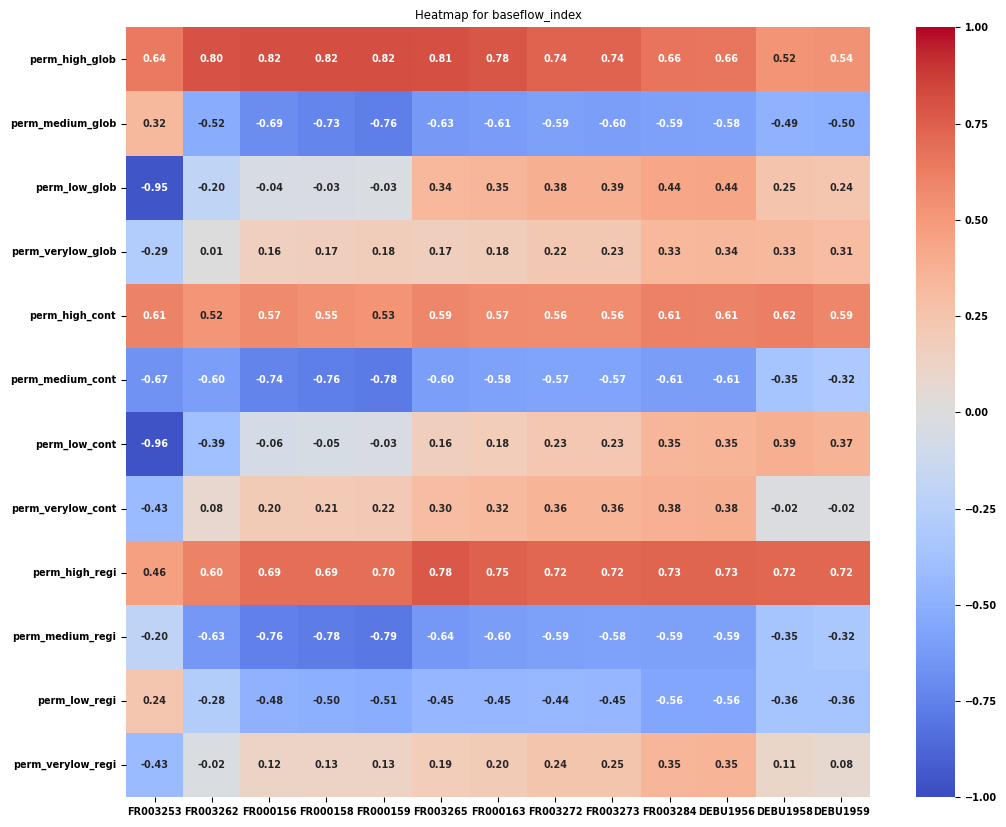

In [252]:
# Filter the catchments in Moselle
catchment = "DEBU1959"
cats_moselle = estreams_attributes_dfs[catchment].index.tolist()

# Filter the attributes for Moselle
estreams_attributes_moselle = estreams_attributes.loc[cats_moselle, :]

# Here we filter again for only the catchments with above a certain number of gauges
list_cats = estreams_attributes_moselle[estreams_attributes_moselle.gauges_upstream >= 5].sort_values(by='gauges_upstream', ascending=True)["gauges_upstream"].index.tolist()

# Create the final potential list of nested
nested_cats_df = nested_catchments.loc[list_cats, :]

 # Find the catchemnts using the headwater (visually selected)
moselle_main = find_directly_connected_catchments(nested_cats_df, "FR003253") #FR000128
print(moselle_main)

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_moselle_dfs = {}

for catchment in tqdm.tqdm(moselle_main):
    
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_moselle_dfs[catchment] = cat_clip


# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict_moselle = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in moselle_main:

        estreams_attributes_dfs_cat = estreams_attributes_moselle_dfs[catchment]

        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 
       'perm_high_glob',
       'perm_medium_glob', 'perm_low_glob', 'perm_verylow_glob',
       'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont',
       'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_verylow_regi',
       ]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict_moselle[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict_moselle.keys())

 # q_mean corrrelations:
signature = "baseflow_index"
correlation_df = correlation_dict_moselle[signature]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin = -1, vmax = 1)

plt.title(f'Heatmap for {signature}')

plt.show()

In [168]:
data_for_plot_drops_rs_bfi = correlation_dict_moselle["baseflow_index"].T[["perm_high_glob"]]
data_for_plot_drops_rs_bfi = data_for_plot_drops_rs_bfi.loc[["FR000159", "FR003265", "FR003273", "FR003284",  "DEBU1959"],:]
data_for_plot_drops_rs_bfi


perm_high_glob
FR000159        0.816316
FR003265        0.808817
FR003273        0.738577
FR003284        0.664588
DEBU1959        0.537650

<Axes: >

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

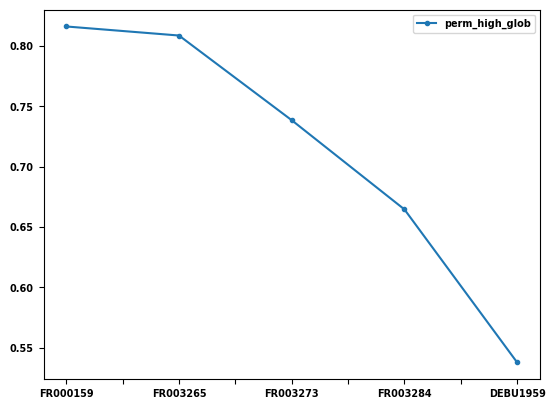

In [179]:
data_for_plot_drops_rs_bfi.plot(marker='o', markersize=3)  # Add marker and size

In [176]:
data_for_plot_drops_rs_qmean = correlation_dict_moselle["slope_sawicz"].T[["perm_high_glob"]]
data_for_plot_drops_rs_qmean = data_for_plot_drops_rs_qmean.loc[["FR000159", "FR003265", "FR003273", "FR003284",  "DEBU1959"],:]
data_for_plot_drops_rs_qmean

perm_high_glob
FR000159       -0.492216
FR003265       -0.597509
FR003273       -0.547176
FR003284       -0.542512
DEBU1959       -0.217995

In [156]:
# Initialize an empty dictionary to store the highest correlation coefficients
max_correlation_dict_moselle = {}

# Iterate over each variable in the correlation_dict
for variable, df in correlation_dict_moselle.items():
    # Get the maximum correlation coefficient for each group
    max_correlation = df.abs().max(axis=0)
    # Store the maximum correlation coefficients in the dictionary
    max_correlation_dict_moselle[variable] = max_correlation

# Create a DataFrame from the dictionary
max_correlation_moselle_df_FR003298 = pd.DataFrame(max_correlation_dict_moselle)

# Print the DataFrame
max_correlation_moselle_df_FR003298

q_mean  q_runoff_ratio  q_elas_Sankarasubramanian  slope_sawicz  \
FR003253  0.785714        0.704187                   0.750000      0.926562   
FR003262  0.859908        0.789665                   0.607892      0.568627   
FR000156  0.833296        0.762776                   0.571990      0.618401   
FR000158  0.823823        0.751677                   0.553230      0.658957   
FR000159  0.817357        0.744312                   0.508669      0.647976   
FR003265  0.890240        0.814816                   0.571593      0.597509   
FR000163  0.882858        0.819435                   0.588666      0.633177   
FR003272  0.875256        0.822338                   0.649249      0.570593   
FR003273  0.870296        0.824867                   0.648825      0.566697   
FR003284  0.845971        0.800021                   0.627609      0.682414   
DEBU1956  0.844643        0.800638                   0.638117      0.677205   
DEBU1958  0.671333        0.662492                   0.499323      0.704157   
DEBU1959  0.663852        0.661883                   0.472935      0.700547   

          baseflow_index  hfd_mean   hfd_std       q_5      q_95   hq_freq  \
FR003253        0.964286  0.678571  0.678571  0.607143  0.964286  0.852437   
FR003262        0.799174  0.835810  0.338034  0.806654  0.908625  0.840129   
FR000156        0.819363  0.864826  0.413081  0.846795  0.843371  0.882372   
FR000158        0.819441  0.792208  0.433284  0.856817  0.848488  0.875085   
FR000159        0.816316  0.755929  0.457801  0.843874  0.850414  0.846838   
FR003265        0.808817  0.697254  0.308477  0.864203  0.853170  0.767152   
FR000163        0.781857  0.638517  0.332189  0.880062  0.841910  0.792960   
FR003272        0.736369  0.609177  0.317269  0.893630  0.840567  0.798389   
FR003273        0.738577  0.608443  0.318665  0.894363  0.829693  0.795285   
FR003284        0.733233  0.601218  0.229176  0.872365  0.794936  0.769539   
DEBU1956        0.732165  0.598803  0.225313  0.871942  0.792672  0.770988   
DEBU1958        0.719512  0.645359  0.279289  0.720453  0.659000  0.688115   
DEBU1959        0.720739  0.638590  0.301786  0.721533  0.653715  0.685766   

            hq_dur   lq_freq    lq_dur  zero_q_freq  
FR003253  0.714286  0.821429  0.642857          NaN  
FR003262  0.190918  0.791538  0.599587          NaN  
FR000156  0.302597  0.813251  0.557973          NaN  
FR000158  0.305477  0.809941  0.559164          NaN  
FR000159  0.286138  0.810971  0.552014          NaN  
FR003265  0.420100  0.767889  0.575664     0.248383  
FR000163  0.496068  0.780580  0.607808     0.231198  
FR003272  0.554614  0.723356  0.610406     0.219019  
FR003273  0.558951  0.722179  0.604447     0.217193  
FR003284  0.607426  0.779724  0.671672     0.265538  
DEBU1956  0.605406  0.777570  0.662821     0.262461  
DEBU1958  0.584538  0.756106  0.664529     0.196200  
DEBU1959  0.589082  0.760834  0.670742     0.187922

## Drop in correlation: FR003986

In [242]:
# First we define the outlet of the Moselle to be used
outlets = ["FR003986"]
nested_cats_df = nested_catchments.loc[outlets, :]
nested_cats_df

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["FR003986"]

# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       "perm_verylow_regi", "perm_low_regi", "perm_medium_regi", "perm_high_regi",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict.keys())
correlation_dict["baseflow_index"]

100%|██████████| 14/14 [00:00<00:00, 26.40it/s]

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


FR003986
p_mean                 0.391240
pet_mean              -0.314021
aridity               -0.369438
p_seasonality         -0.372360
frac_snow              0.218701
hp_freq               -0.184990
hp_dur                 0.371544
hp_time                0.271653
lp_freq               -0.368499
lp_dur                -0.224677
lp_time                     NaN
ele_mt_max             0.323375
ele_mt_mean            0.265787
ele_mt_min             0.149210
slp_dg_mean            0.354517
flat_area_fra         -0.335915
steep_area_fra         0.469908
elon_ratio             0.164242
strm_dens             -0.012250
lit_dom               -0.040491
bedrk_dep              0.097713
perm_verylow_glob      0.107717
perm_low_glob         -0.041637
perm_medium_glob      -0.160076
perm_high_glob        -0.103369
perm_verylow_cont      0.115156
perm_low_cont         -0.127033
perm_medium_cont      -0.099541
perm_high_cont        -0.183550
perm_verylow_regi           NaN
perm_low_regi               NaN
perm_medium_regi            NaN
perm_high_regi              NaN
root_dep_mean         -0.189811
root_dep_max          -0.024461
root_dep_min          -0.076926
soil_tawc_mean         0.354157
soil_fra_sand_mean     0.104402
soil_fra_silt_mean     0.026994
soil_fra_clay_mean    -0.133336
soil_fra_grav_mean     0.301620
soil_bd_mean          -0.535176
soil_oc_mean           0.507520
lai_mean               0.269856
ndvi_mean              0.176953
lulc_2006_urban        0.309766
lulc_2006_NonIrriAgri -0.188940
lulc_2006_Agric       -0.508669
lulc_2006_forest       0.500589
lulc_2006_grass        0.223505
lulc_2006_agriculture -0.499272
dam_num                0.309315
res_num                0.303808
lakes_num              0.108383
sno_cov_mean           0.324605
irri_1990              0.036657
irri_2005             -0.002569
stations_num_p_mean    0.159938
area_estreams          0.146145

['FR001191', 'FR003940', 'FR001196', 'FR001199', 'FR001200', 'FR003943', 'FR001203', 'FR001205', 'FR003945', 'FR003953', 'FR003954', 'FR003984', 'FR003986']


100%|██████████| 14/14 [00:00<00:00, 19.02it/s]
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfon

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

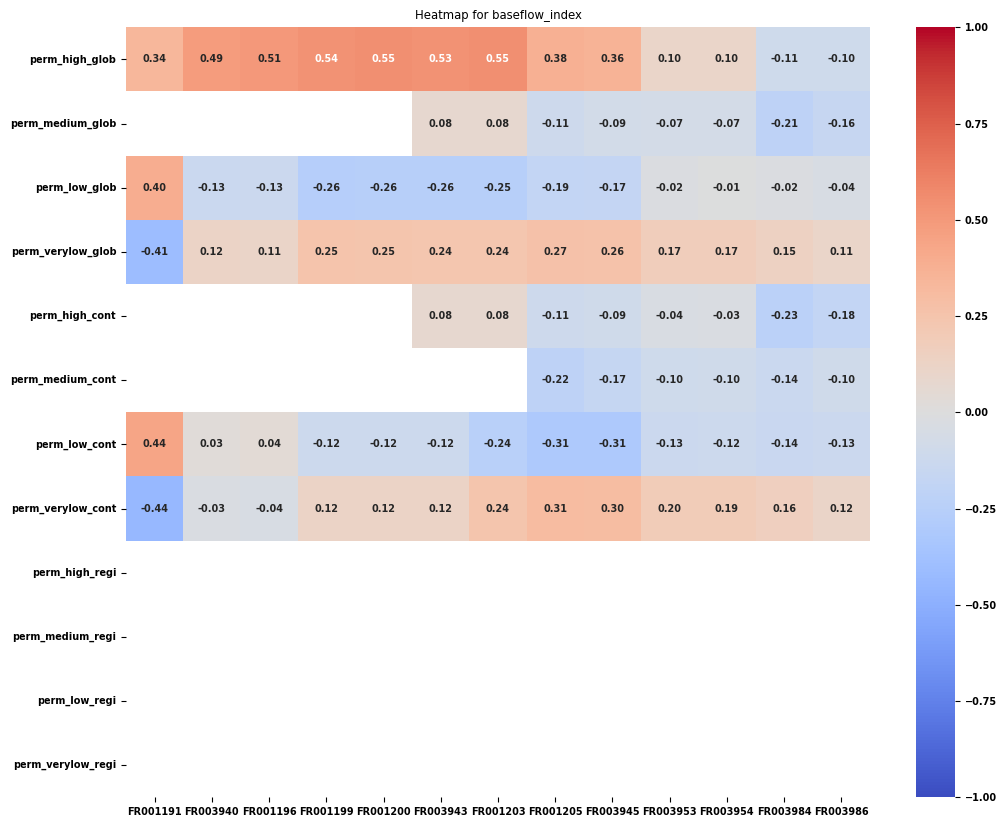

In [243]:
# Filter the catchments in Moselle
catchment = "FR003986"
cats_moselle = estreams_attributes_dfs[catchment].index.tolist()

# Filter the attributes for Moselle
estreams_attributes_moselle = estreams_attributes.loc[cats_moselle, :]

# Here we filter again for only the catchments with above a certain number of gauges
list_cats = estreams_attributes_moselle[estreams_attributes_moselle.gauges_upstream >= 5].sort_values(by='gauges_upstream', ascending=True)["gauges_upstream"].index.tolist()

# Create the final potential list of nested
nested_cats_df = nested_catchments.loc[list_cats, :]

 # Find the catchemnts using the headwater (visually selected)
moselle_main = find_directly_connected_catchments(nested_cats_df, "FR001191") #FR000128
print(moselle_main)

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_moselle_dfs = {}

for catchment in tqdm.tqdm(moselle_main):
    
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_moselle_dfs[catchment] = cat_clip


# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict_moselle = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in moselle_main:

        estreams_attributes_dfs_cat = estreams_attributes_moselle_dfs[catchment]

        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 
       'perm_high_glob',
       'perm_medium_glob', 'perm_low_glob', 'perm_verylow_glob',
       'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont',
       'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_verylow_regi',
       ]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict_moselle[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict_moselle.keys())

 # q_mean corrrelations:
signature = "baseflow_index"
correlation_df = correlation_dict_moselle[signature]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin = -1, vmax = 1)

plt.title(f'Heatmap for {signature}')

plt.show()

## Drop in correlation: PL000936

100%|██████████| 14/14 [00:00<00:00, 33.84it/s]


dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])
['PL000927', 'PL000928', 'PL000929', 'PL000930', 'PL000931', 'PL000932', 'PL000933', 'PL000934', 'PL000935', 'PL000936']


100%|██████████| 14/14 [00:00<00:00, 25.18it/s]
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfon

dict_keys(['q_mean', 'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz', 'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq', 'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq'])


findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: 

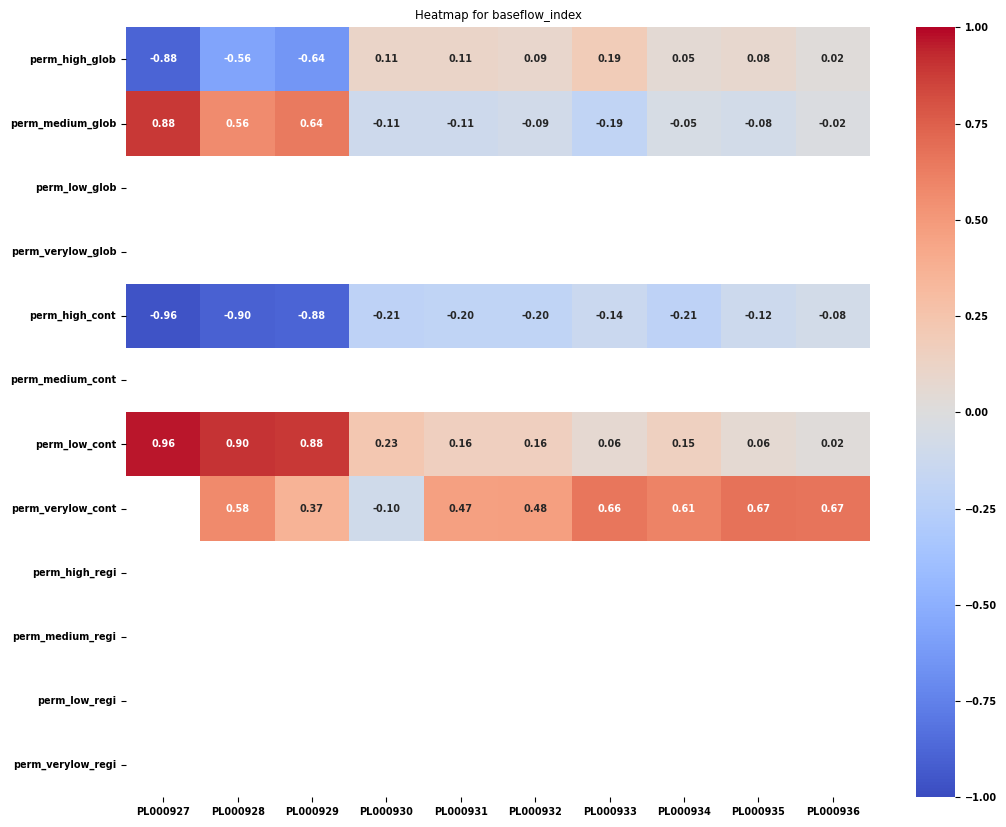

In [244]:
# First we define the outlet of the Moselle to be used
outlets = ["PL000936"]
nested_cats_df = nested_catchments.loc[outlets, :]
nested_cats_df

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

estreams_attributes_dfs["PL000936"]

# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in estreams_attributes_dfs.keys():

        estreams_attributes_dfs_cat = estreams_attributes_dfs[catchment]
        #estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[estreams_attributes_dfs_cat.end_date > "2009"]
        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 'p_mean', 'pet_mean',
       'aridity', 'p_seasonality', 'frac_snow', 'hp_freq', 'hp_dur', 'hp_time',
       'lp_freq', 'lp_dur', 'lp_time', 'ele_mt_max', 'ele_mt_mean',
       'ele_mt_min', 'slp_dg_mean', 'flat_area_fra', 'steep_area_fra',
       'elon_ratio', 'strm_dens', 'lit_dom', 'bedrk_dep',

       'perm_verylow_glob','perm_low_glob', 'perm_medium_glob', 'perm_high_glob', 
       'perm_verylow_cont', 'perm_low_cont', 'perm_medium_cont', 'perm_high_cont',
       "perm_verylow_regi", "perm_low_regi", "perm_medium_regi", "perm_high_regi",
       
       'root_dep_mean', 'root_dep_max', 'root_dep_min', 'soil_tawc_mean',
       'soil_fra_sand_mean', 'soil_fra_silt_mean', 'soil_fra_clay_mean',
       'soil_fra_grav_mean', 'soil_bd_mean', 'soil_oc_mean', 'lai_mean',
       'ndvi_mean', 'lulc_2006_urban', 'lulc_2006_NonIrriAgri',
       'lulc_2006_Agric', 'lulc_2006_forest', 'lulc_2006_grass',
       'lulc_2006_agriculture', 'dam_num', 'res_num', 'lakes_num',
       'sno_cov_mean', 'irri_1990', 'irri_2005', 'stations_num_p_mean', "area_estreams"]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict.keys())
correlation_dict["baseflow_index"]



# Filter the catchments in Moselle
catchment = "PL000936"
cats_moselle = estreams_attributes_dfs[catchment].index.tolist()

# Filter the attributes for Moselle
estreams_attributes_moselle = estreams_attributes.loc[cats_moselle, :]

# Here we filter again for only the catchments with above a certain number of gauges
list_cats = estreams_attributes_moselle[estreams_attributes_moselle.gauges_upstream >= 5].sort_values(by='gauges_upstream', ascending=True)["gauges_upstream"].index.tolist()

# Create the final potential list of nested
nested_cats_df = nested_catchments.loc[list_cats, :]

 # Find the catchemnts using the headwater (visually selected)
moselle_main = find_directly_connected_catchments(nested_cats_df, "PL000927") #FR000128
print(moselle_main)

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_moselle_dfs = {}

for catchment in tqdm.tqdm(moselle_main):
    
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_catchments.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_moselle_dfs[catchment] = cat_clip


# Store the correlation matrices for selected catchments in a dictionary:
# Initialize an empty dictionary to store correlation DataFrames for the selected variables
correlation_dict_moselle = {}

# Iterate over each variable in the first 14 columns of your data
for variable in tqdm.tqdm(estreams_attributes.columns[29:43]):
    # Initialize an empty DataFrame to store correlations
    correlation_df = pd.DataFrame()

    # Iterate over each watershed group
    for catchment in moselle_main:

        estreams_attributes_dfs_cat = estreams_attributes_moselle_dfs[catchment]

        estreams_attributes_dfs_cat = estreams_attributes_dfs_cat[['q_mean',
       'q_runoff_ratio', 'q_elas_Sankarasubramanian', 'slope_sawicz',
       'baseflow_index', 'hfd_mean', 'hfd_std', 'q_5', 'q_95', 'hq_freq',
       'hq_dur', 'lq_freq', 'lq_dur', 'zero_q_freq', 
       'perm_high_glob',
       'perm_medium_glob', 'perm_low_glob', 'perm_verylow_glob',
       'perm_high_cont',
       'perm_medium_cont', 'perm_low_cont', 'perm_verylow_cont',
       'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_verylow_regi',
       ]]
        
        # Calculate correlations between the current variable and other variables
        correlations = estreams_attributes_dfs_cat.corr(method="spearman")[variable].iloc[14:] # We should check carefully
        
        # Add the correlations to the DataFrame
        correlation_df[catchment] = correlations

    # Add the correlation DataFrame to the dictionary
    correlation_dict_moselle[variable] = correlation_df

# Print the keys of the correlation dictionary
print(correlation_dict_moselle.keys())

 # q_mean corrrelations:
signature = "baseflow_index"
correlation_df = correlation_dict_moselle[signature]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", vmin = -1, vmax = 1)

plt.title(f'Heatmap for {signature}')

plt.show()

# End